In [2]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        #  transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        transforms.Normalize([0.5],[0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [3]:
def ss_data(flag='train'):
    if flag == 'train':
        return torch.load('../dataloader_32_train.pt')
    elif flag == 'test':
        return torch.load('../dataloader_32_test.pt')
    else:
        raise NameError("No such data loader")
train_dataloader = ss_data()
num_batches_train = len(train_dataloader)
test_dataloader = ss_data('test')
num_batches_test = len(test_dataloader)

In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 44
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 22, 28)

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0),44)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 11, 4)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 44
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [7]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100,dtype=torch.float32))
    return n


In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [9]:
loss = nn.BCELoss()

In [10]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,dtype=torch.float32))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,dtype=torch.float32))
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [13]:
num_test_samples = 16
test_noise = noise(num_test_samples)

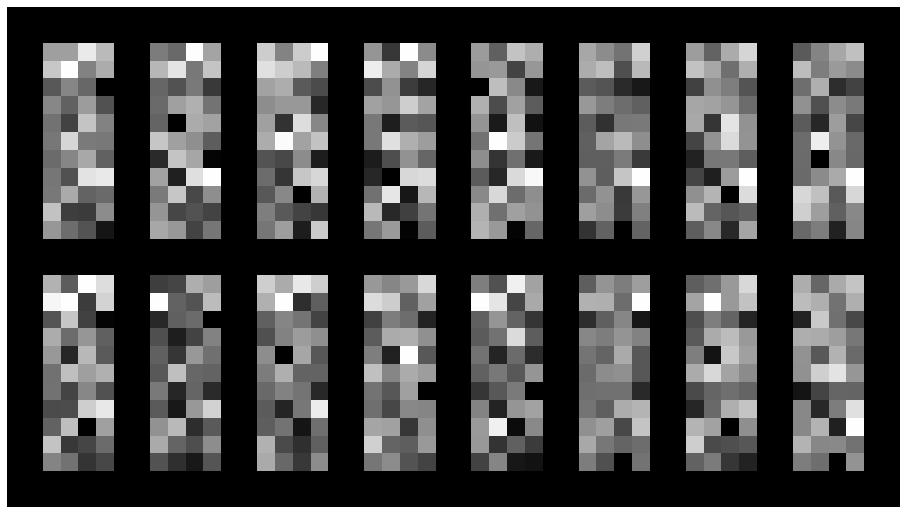

Epoch: [0/200], Batch Num: [0/10]
Discriminator Loss: 1.3812, Generator Loss: 0.7005
D(x): 0.4971, D(G(z)): 0.4931


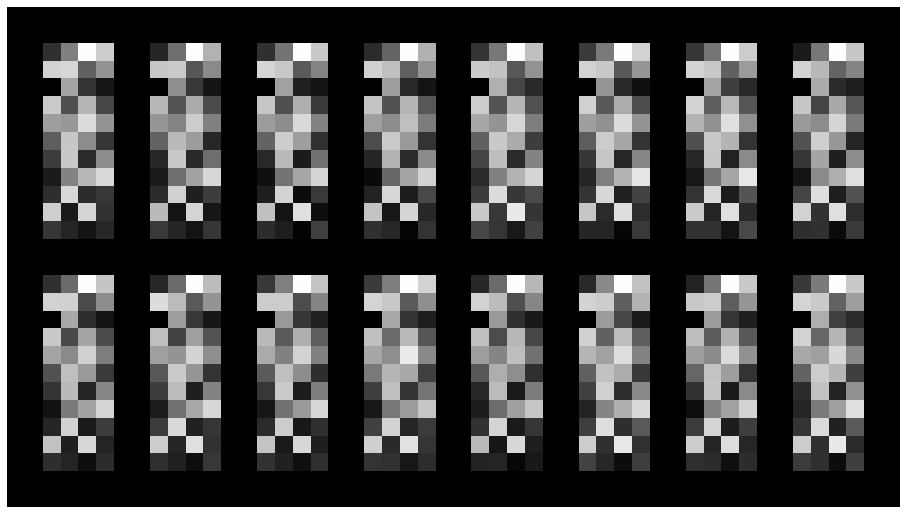

Epoch: [1/200], Batch Num: [0/10]
Discriminator Loss: 0.9792, Generator Loss: 0.6526
D(x): 0.8180, D(G(z)): 0.5334


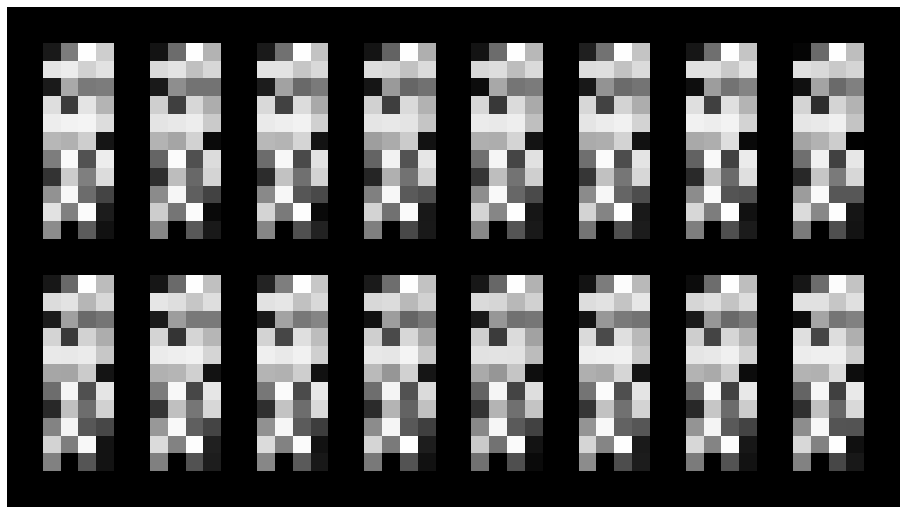

Epoch: [2/200], Batch Num: [0/10]
Discriminator Loss: 0.5835, Generator Loss: 1.0778
D(x): 0.9008, D(G(z)): 0.3728


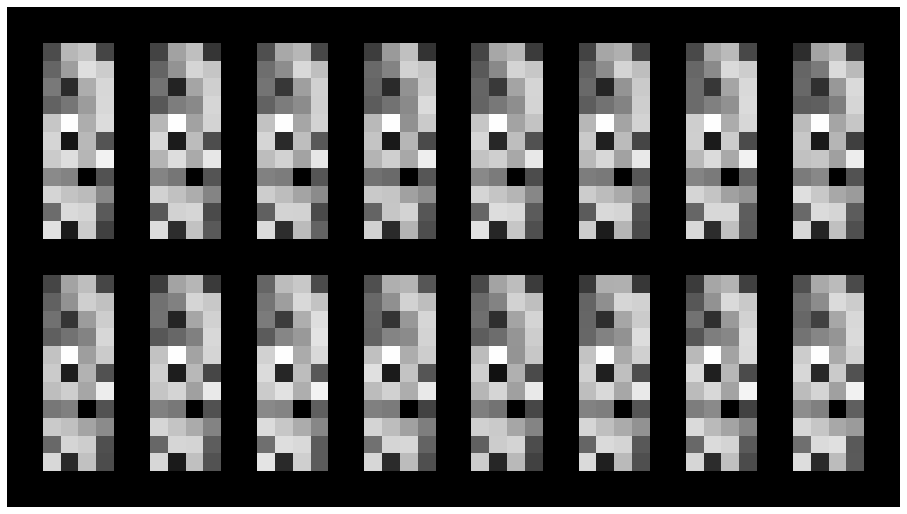

Epoch: [3/200], Batch Num: [0/10]
Discriminator Loss: 0.5887, Generator Loss: 1.2218
D(x): 0.8922, D(G(z)): 0.3616


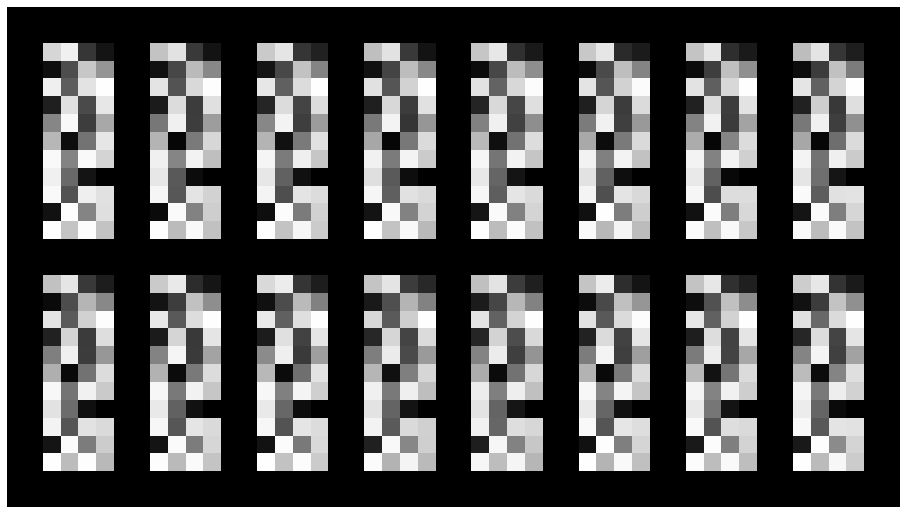

Epoch: [4/200], Batch Num: [0/10]
Discriminator Loss: 2.1697, Generator Loss: 0.2855
D(x): 0.7679, D(G(z)): 0.8287


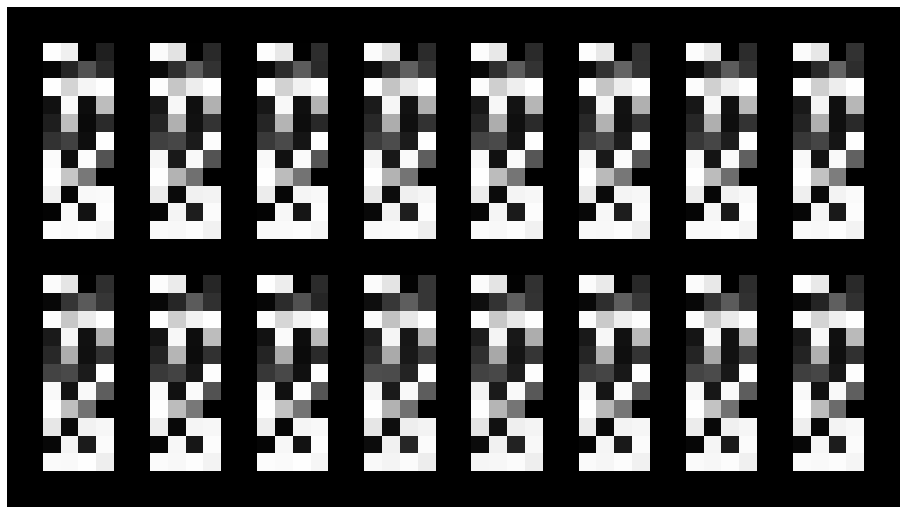

Epoch: [5/200], Batch Num: [0/10]
Discriminator Loss: 1.0712, Generator Loss: 1.0020
D(x): 0.7775, D(G(z)): 0.5215


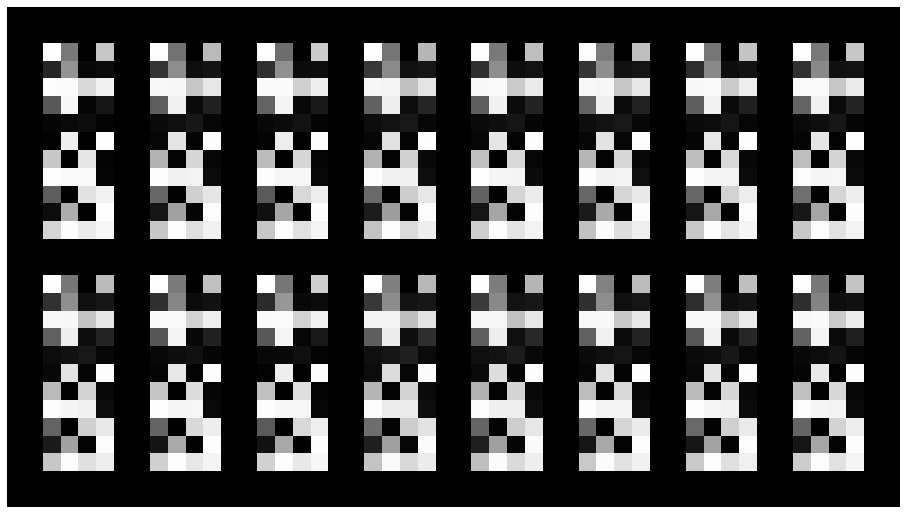

Epoch: [6/200], Batch Num: [0/10]
Discriminator Loss: 0.3338, Generator Loss: 2.4883
D(x): 0.8527, D(G(z)): 0.1304


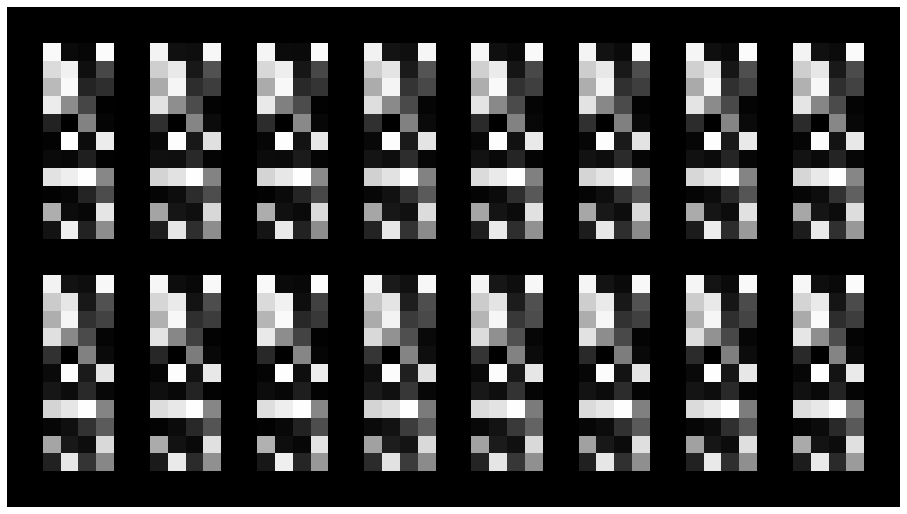

Epoch: [7/200], Batch Num: [0/10]
Discriminator Loss: 0.5435, Generator Loss: 2.0450
D(x): 0.8806, D(G(z)): 0.3143


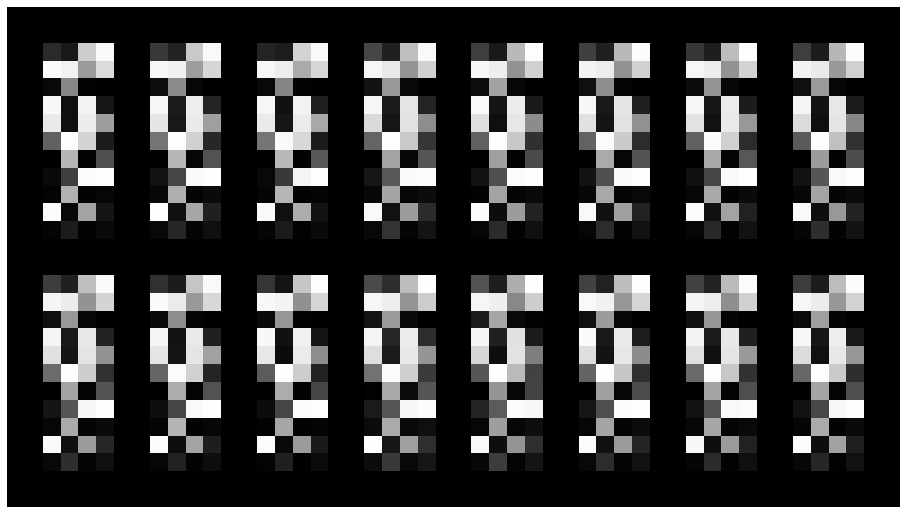

Epoch: [8/200], Batch Num: [0/10]
Discriminator Loss: 1.4633, Generator Loss: 1.0490
D(x): 0.7918, D(G(z)): 0.6619


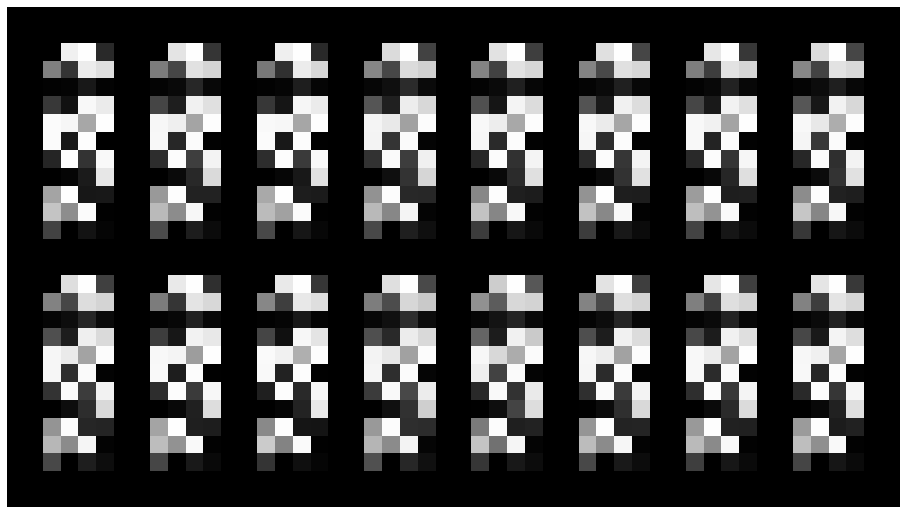

Epoch: [9/200], Batch Num: [0/10]
Discriminator Loss: 1.5032, Generator Loss: 0.8676
D(x): 0.7335, D(G(z)): 0.6514


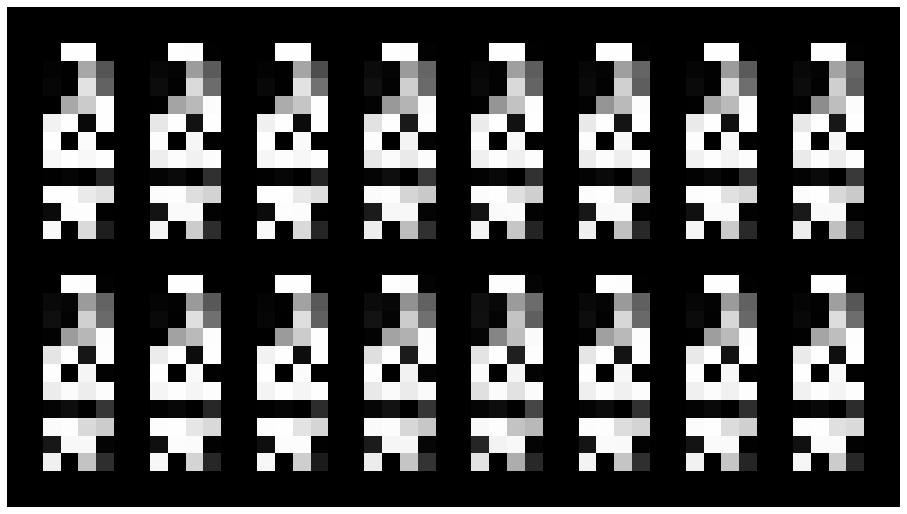

Epoch: [10/200], Batch Num: [0/10]
Discriminator Loss: 0.7040, Generator Loss: 1.3872
D(x): 0.8369, D(G(z)): 0.3666


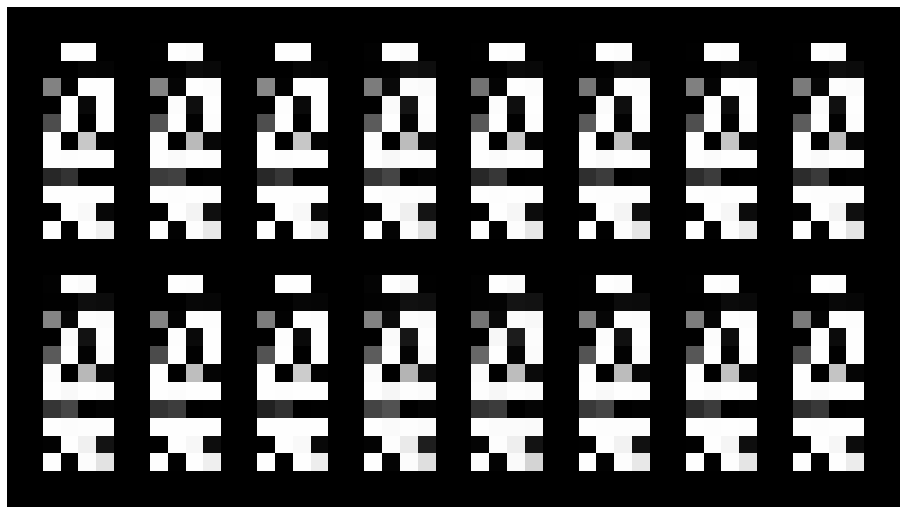

Epoch: [11/200], Batch Num: [0/10]
Discriminator Loss: 0.1953, Generator Loss: 3.4995
D(x): 0.9010, D(G(z)): 0.0480


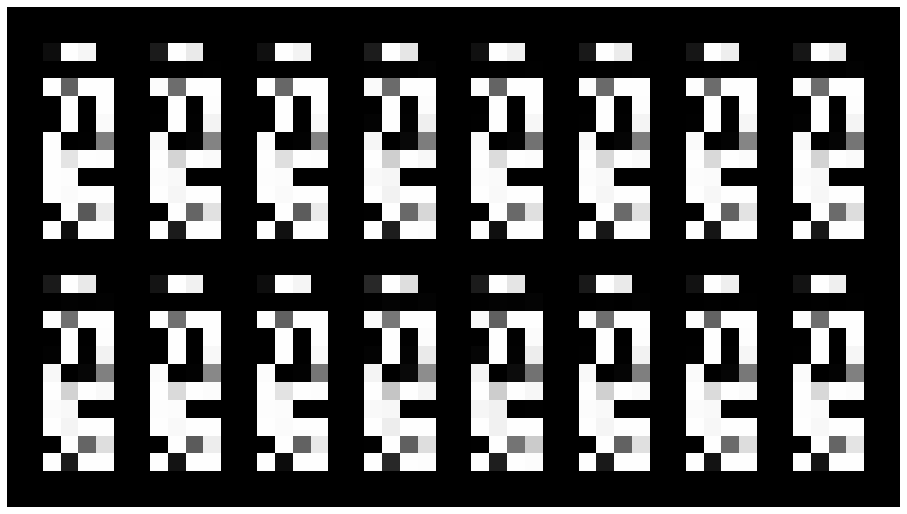

Epoch: [12/200], Batch Num: [0/10]
Discriminator Loss: 0.1884, Generator Loss: 3.2720
D(x): 0.9149, D(G(z)): 0.0543


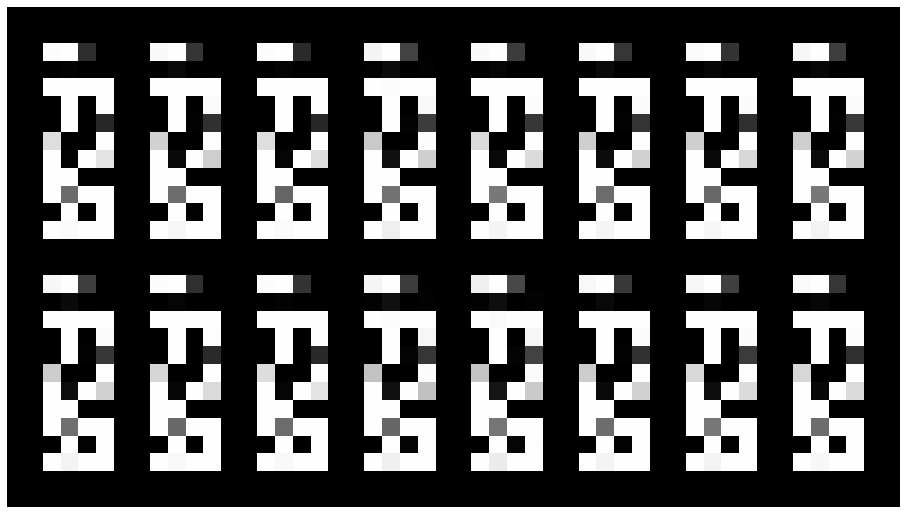

Epoch: [13/200], Batch Num: [0/10]
Discriminator Loss: 0.1795, Generator Loss: 3.2520
D(x): 0.9264, D(G(z)): 0.0623


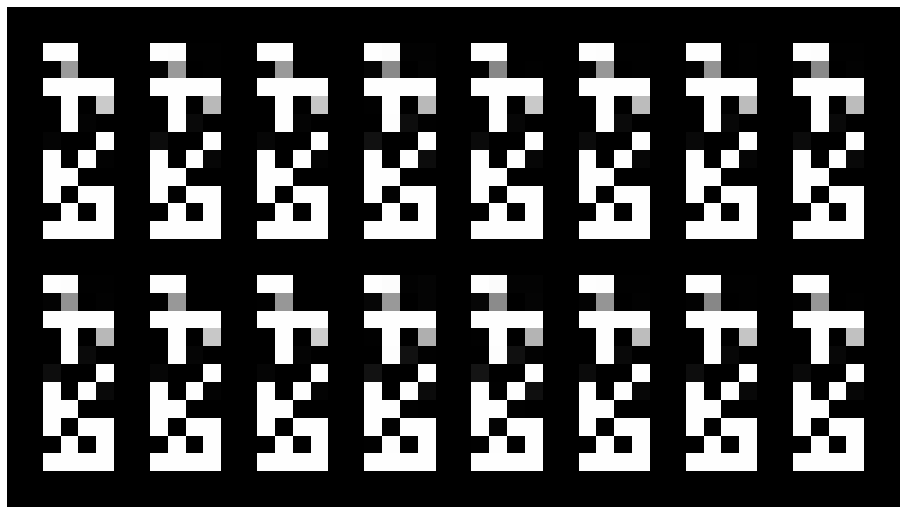

Epoch: [14/200], Batch Num: [0/10]
Discriminator Loss: 0.1123, Generator Loss: 4.7447
D(x): 0.9386, D(G(z)): 0.0137


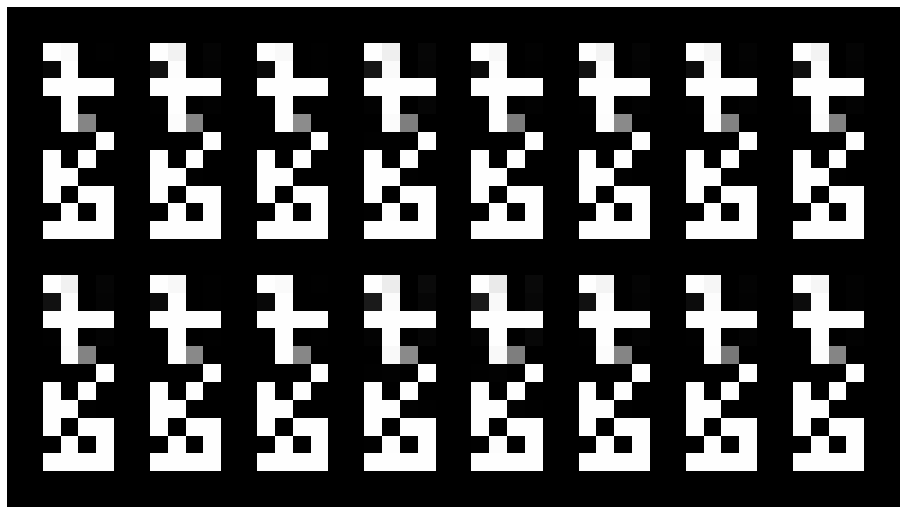

Epoch: [15/200], Batch Num: [0/10]
Discriminator Loss: 0.0627, Generator Loss: 5.3579
D(x): 0.9614, D(G(z)): 0.0069


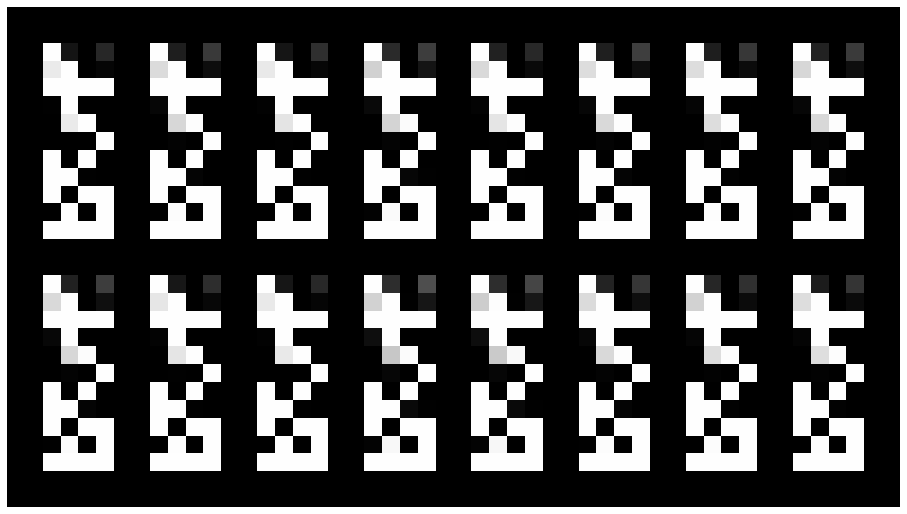

Epoch: [16/200], Batch Num: [0/10]
Discriminator Loss: 0.0763, Generator Loss: 4.6196
D(x): 0.9561, D(G(z)): 0.0123


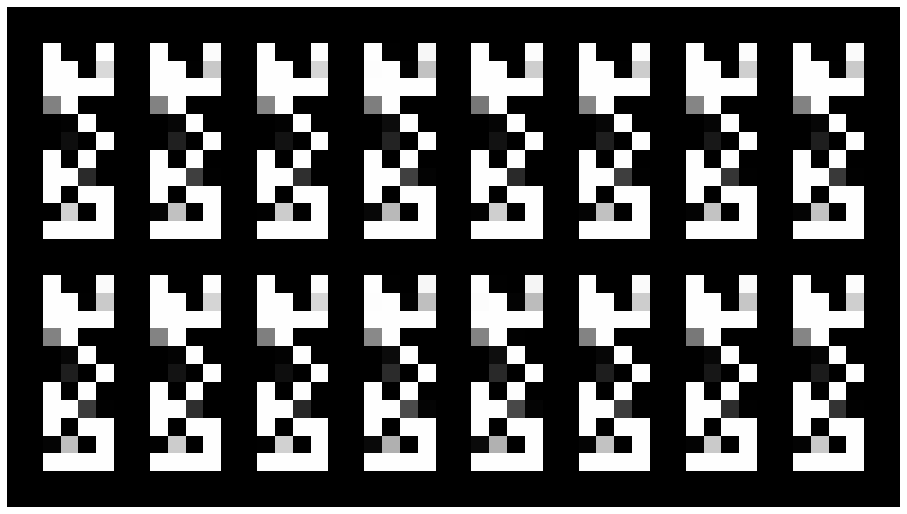

Epoch: [17/200], Batch Num: [0/10]
Discriminator Loss: 0.0753, Generator Loss: 3.6160
D(x): 0.9732, D(G(z)): 0.0382


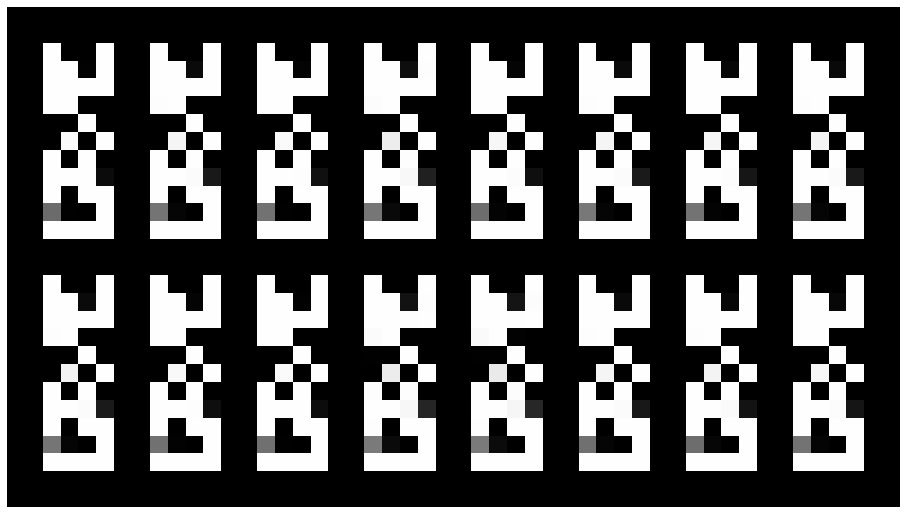

Epoch: [18/200], Batch Num: [0/10]
Discriminator Loss: 0.0737, Generator Loss: 4.8638
D(x): 0.9569, D(G(z)): 0.0166


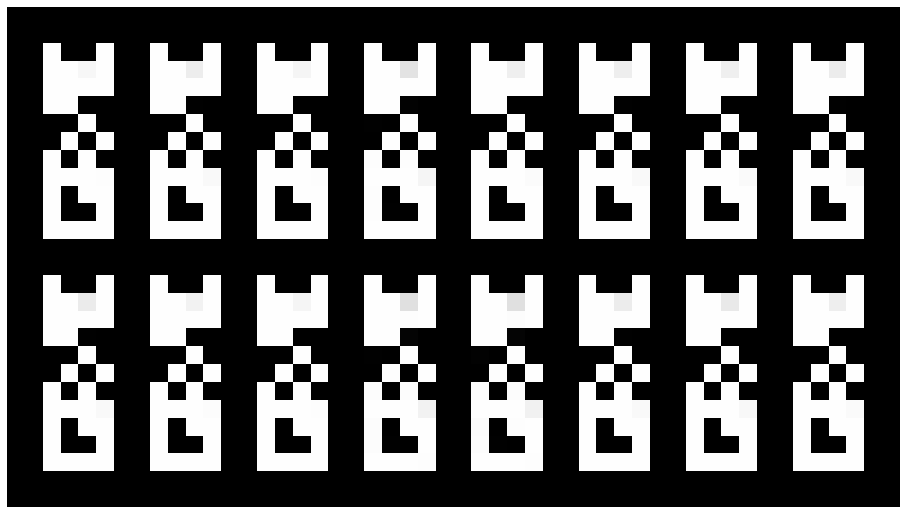

Epoch: [19/200], Batch Num: [0/10]
Discriminator Loss: 0.0871, Generator Loss: 4.6938
D(x): 0.9572, D(G(z)): 0.0266


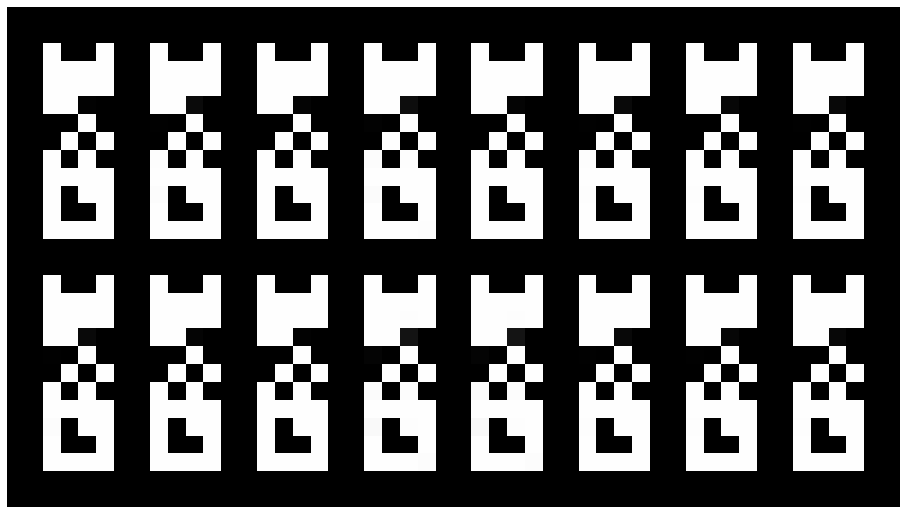

Epoch: [20/200], Batch Num: [0/10]
Discriminator Loss: 0.0605, Generator Loss: 8.1086
D(x): 0.9575, D(G(z)): 0.0007


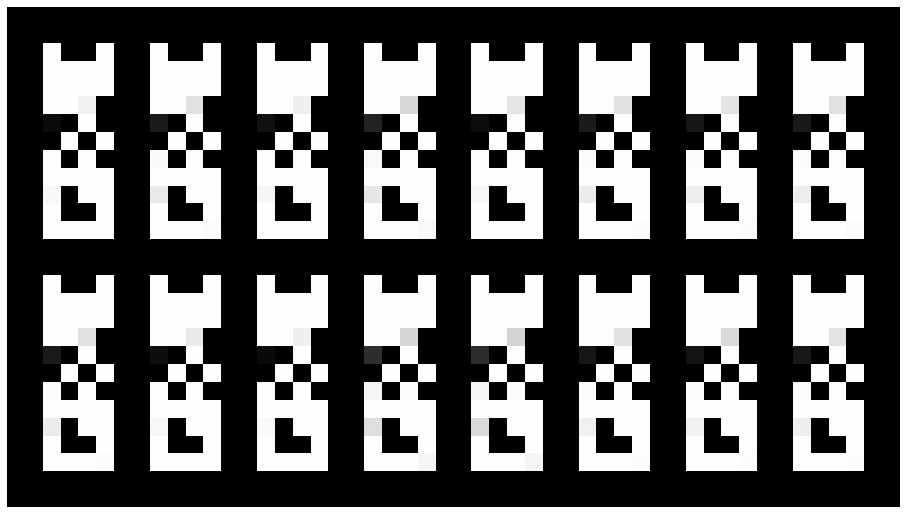

Epoch: [21/200], Batch Num: [0/10]
Discriminator Loss: 0.0520, Generator Loss: 8.0004
D(x): 0.9612, D(G(z)): 0.0007


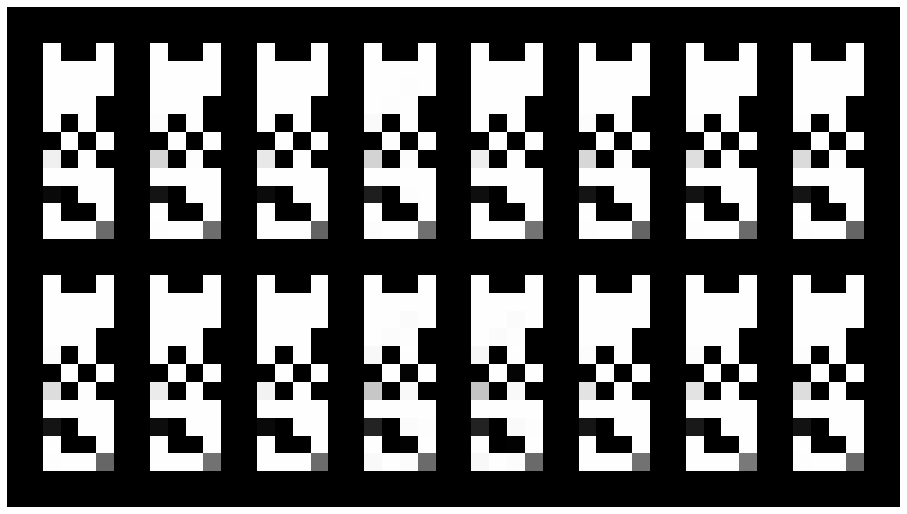

Epoch: [22/200], Batch Num: [0/10]
Discriminator Loss: 0.0469, Generator Loss: 4.8625
D(x): 0.9755, D(G(z)): 0.0157


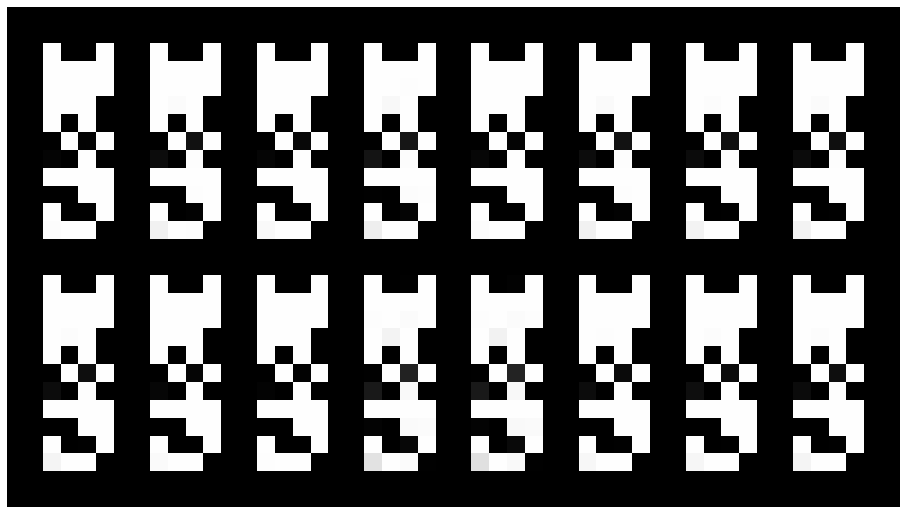

Epoch: [23/200], Batch Num: [0/10]
Discriminator Loss: 0.0408, Generator Loss: 6.6320
D(x): 0.9709, D(G(z)): 0.0031


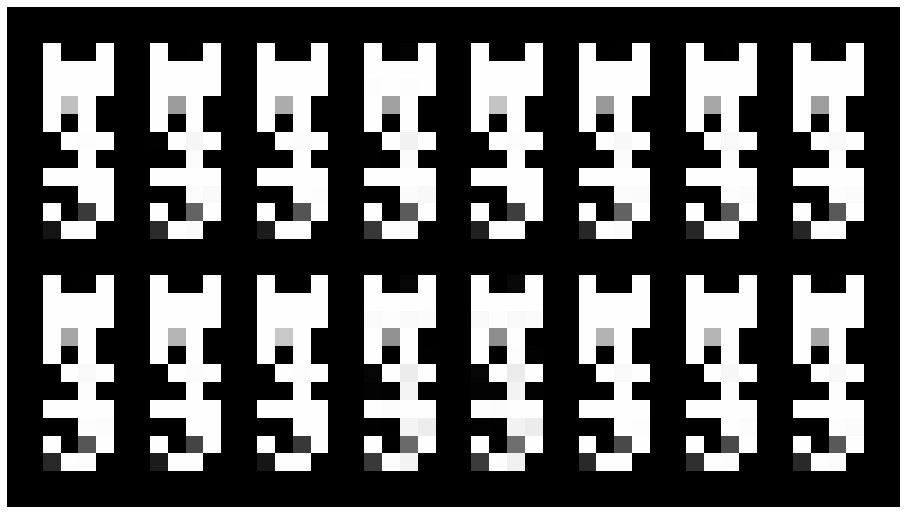

Epoch: [24/200], Batch Num: [0/10]
Discriminator Loss: 0.0516, Generator Loss: 5.5492
D(x): 0.9674, D(G(z)): 0.0093


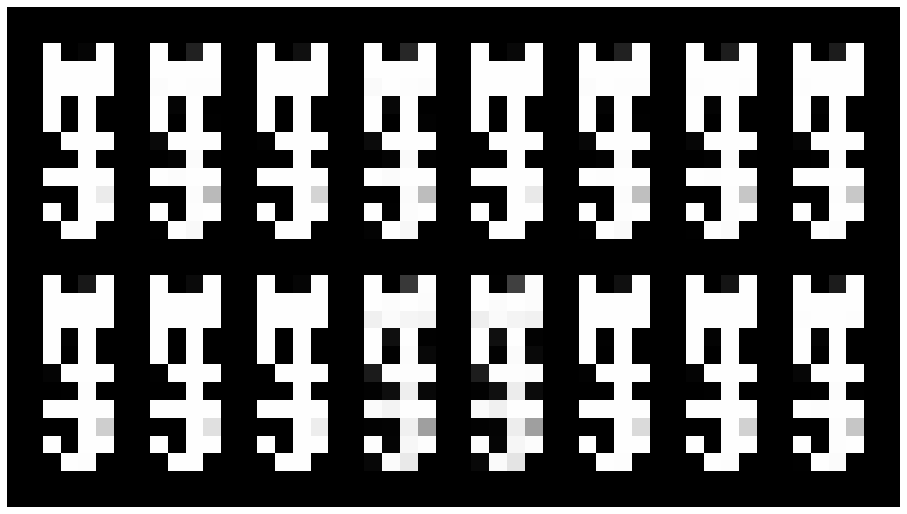

Epoch: [25/200], Batch Num: [0/10]
Discriminator Loss: 0.0444, Generator Loss: 6.2477
D(x): 0.9716, D(G(z)): 0.0056


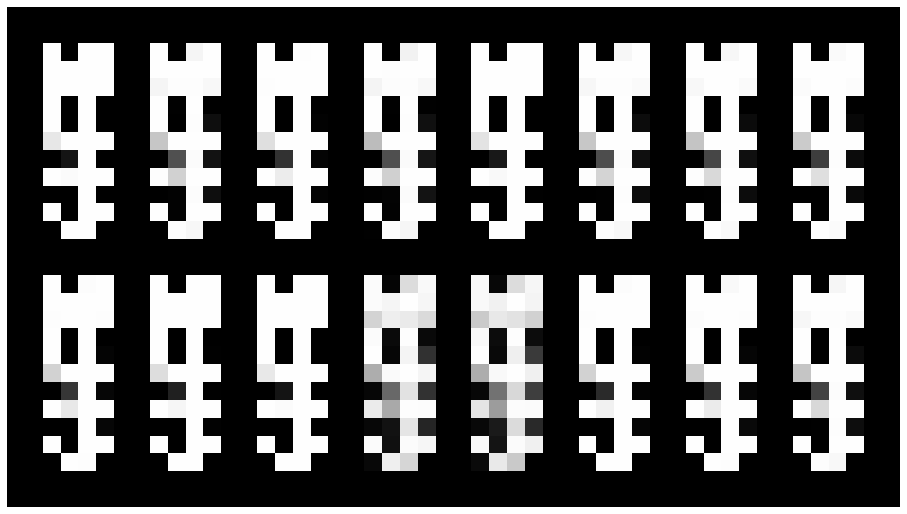

Epoch: [26/200], Batch Num: [0/10]
Discriminator Loss: 0.0677, Generator Loss: 4.4567
D(x): 0.9729, D(G(z)): 0.0319


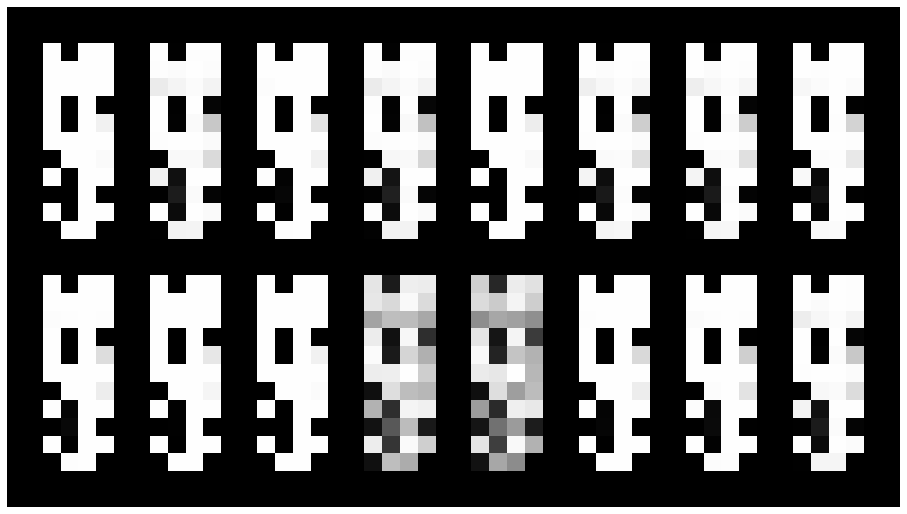

Epoch: [27/200], Batch Num: [0/10]
Discriminator Loss: 0.0791, Generator Loss: 5.6252
D(x): 0.9615, D(G(z)): 0.0214


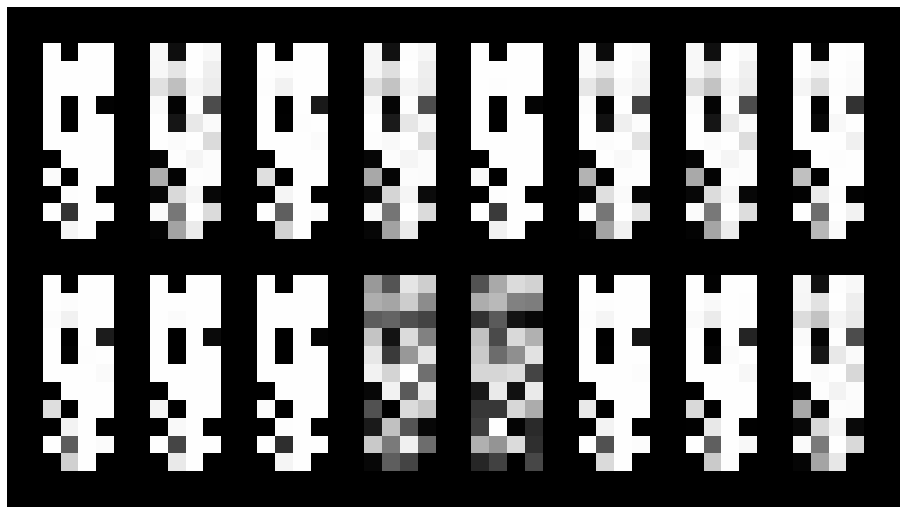

Epoch: [28/200], Batch Num: [0/10]
Discriminator Loss: 0.1075, Generator Loss: 6.1253
D(x): 0.9559, D(G(z)): 0.0215


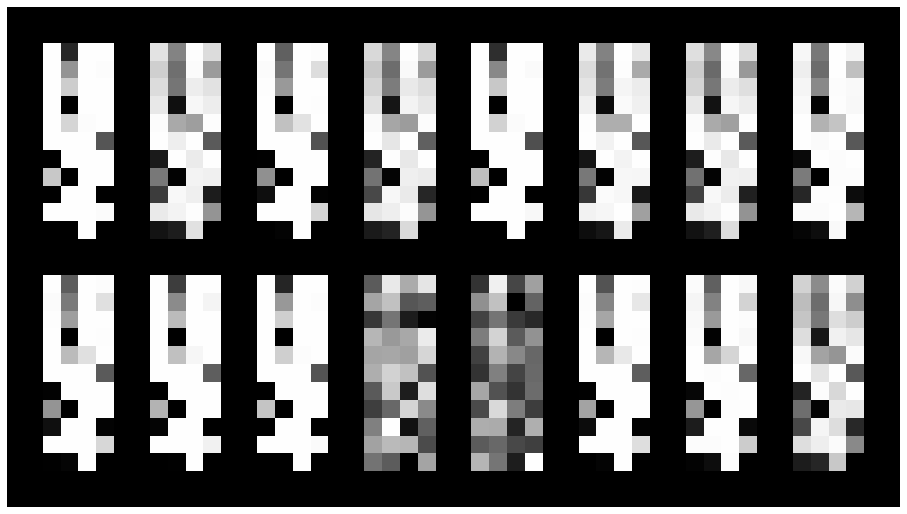

Epoch: [29/200], Batch Num: [0/10]
Discriminator Loss: 0.1612, Generator Loss: 4.6240
D(x): 0.9548, D(G(z)): 0.0629


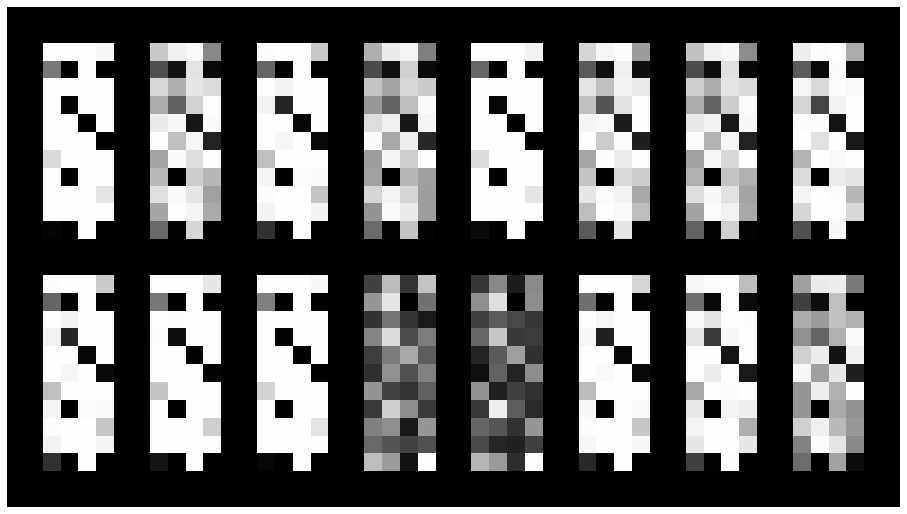

Epoch: [30/200], Batch Num: [0/10]
Discriminator Loss: 0.4496, Generator Loss: 3.2222
D(x): 0.9215, D(G(z)): 0.1882


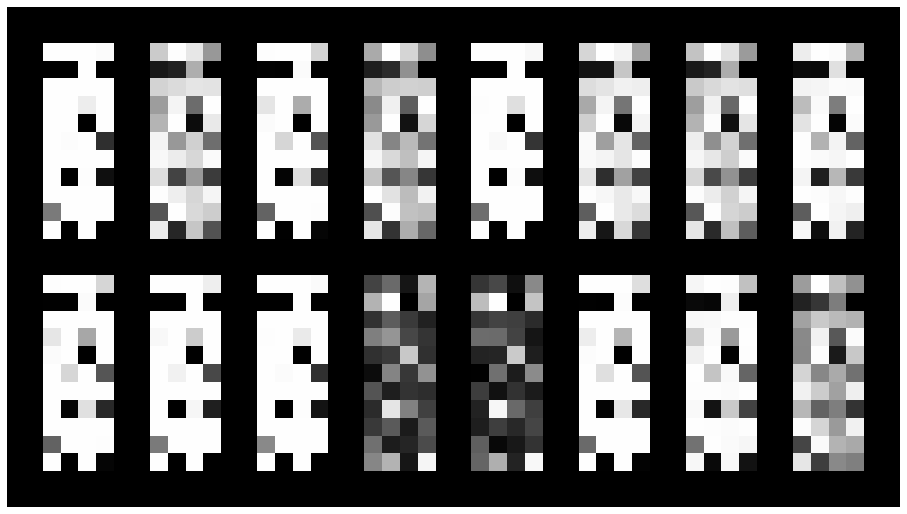

Epoch: [31/200], Batch Num: [0/10]
Discriminator Loss: 0.3456, Generator Loss: 3.9284
D(x): 0.9165, D(G(z)): 0.1134


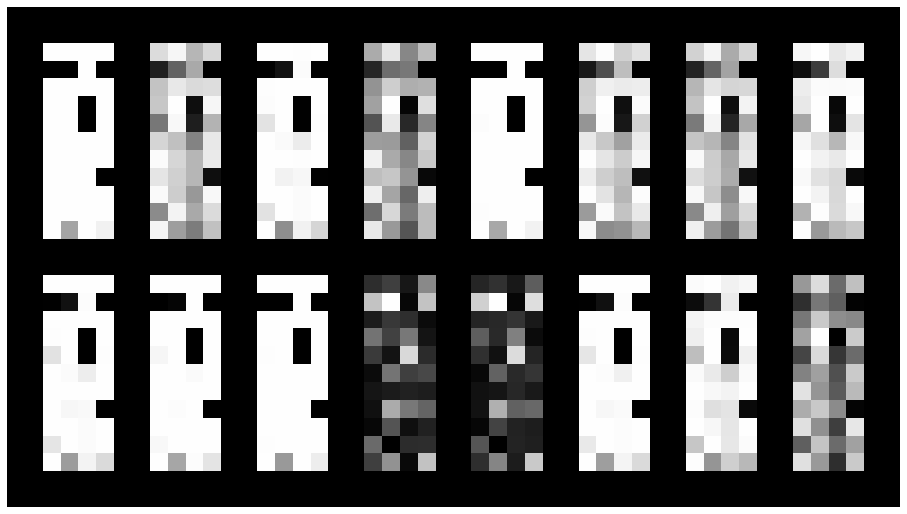

Epoch: [32/200], Batch Num: [0/10]
Discriminator Loss: 0.3088, Generator Loss: 3.7192
D(x): 0.9107, D(G(z)): 0.1295


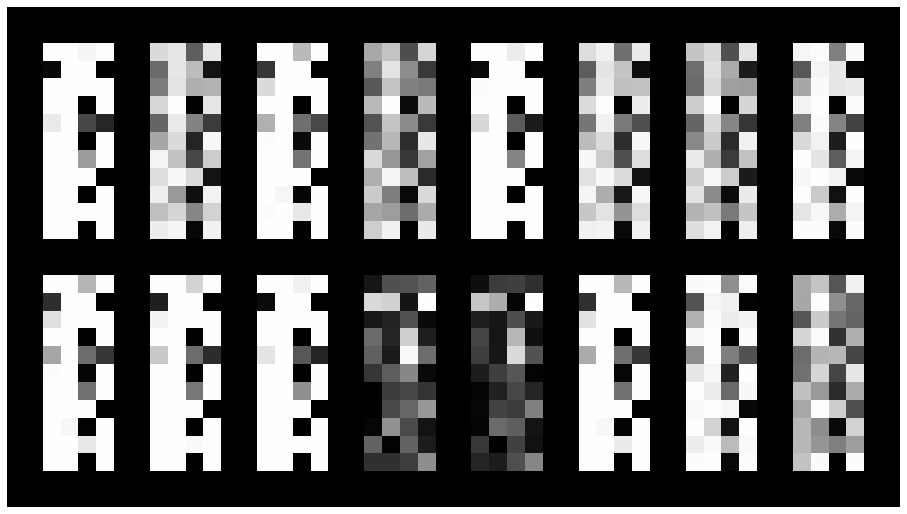

Epoch: [33/200], Batch Num: [0/10]
Discriminator Loss: 0.3888, Generator Loss: 3.6629
D(x): 0.8468, D(G(z)): 0.1198


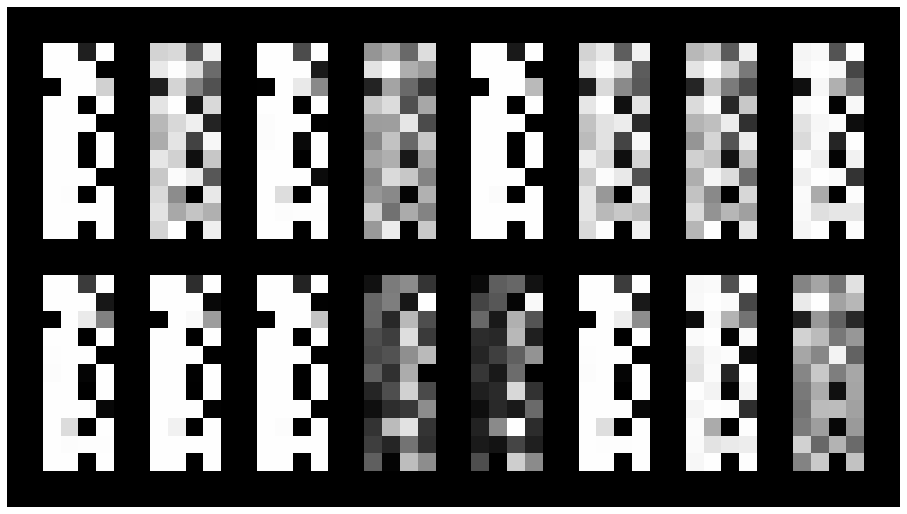

Epoch: [34/200], Batch Num: [0/10]
Discriminator Loss: 0.3488, Generator Loss: 5.4534
D(x): 0.8796, D(G(z)): 0.0922


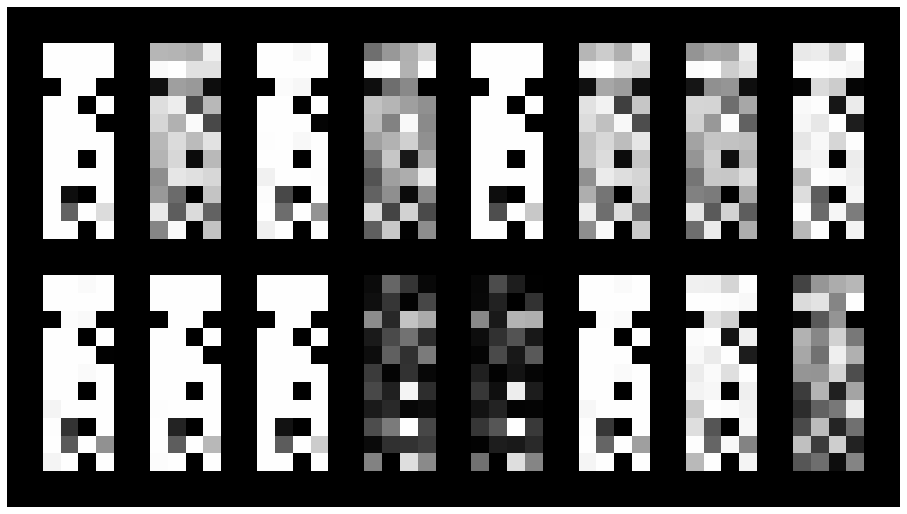

Epoch: [35/200], Batch Num: [0/10]
Discriminator Loss: 0.4470, Generator Loss: 5.7761
D(x): 0.8736, D(G(z)): 0.1177


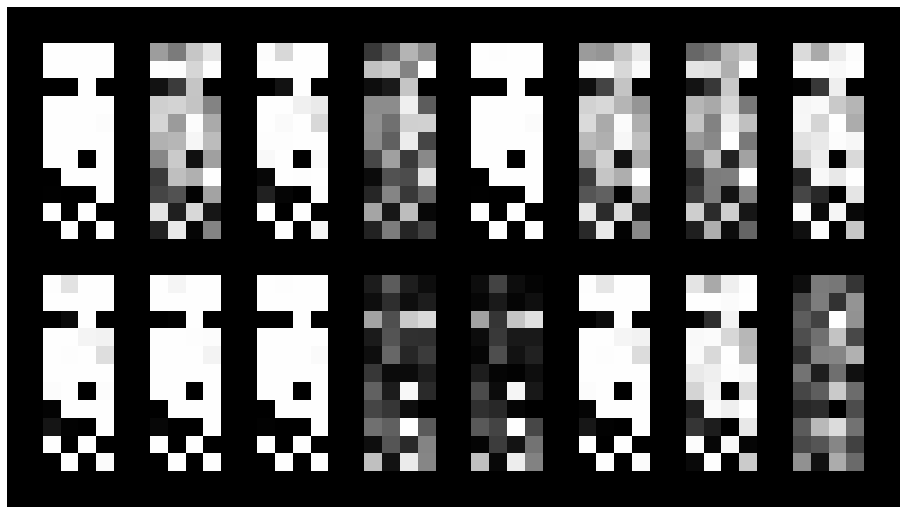

Epoch: [36/200], Batch Num: [0/10]
Discriminator Loss: 0.3485, Generator Loss: 3.1387
D(x): 0.8672, D(G(z)): 0.1377


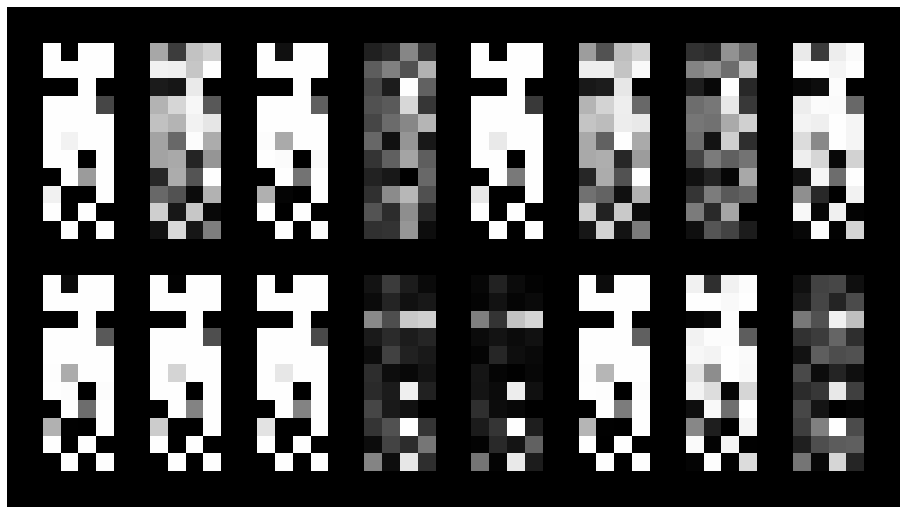

Epoch: [37/200], Batch Num: [0/10]
Discriminator Loss: 0.2241, Generator Loss: 5.7287
D(x): 0.9334, D(G(z)): 0.0938


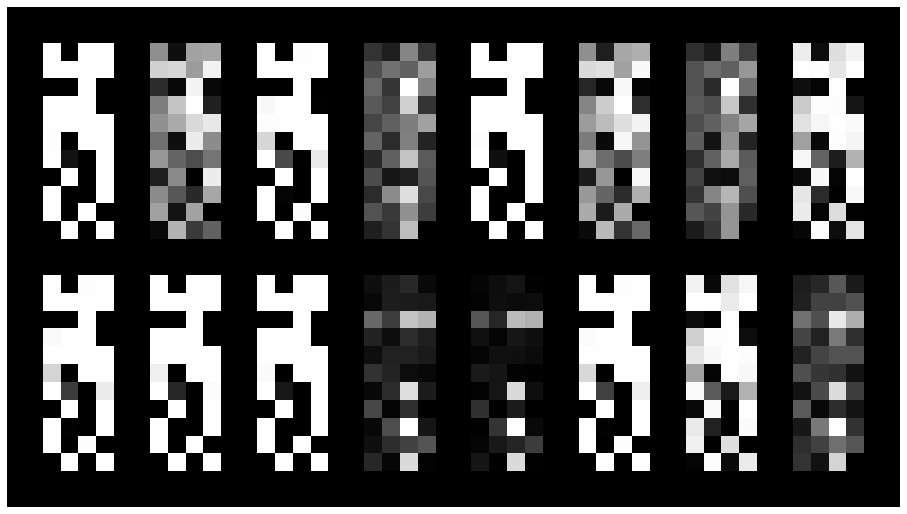

Epoch: [38/200], Batch Num: [0/10]
Discriminator Loss: 0.3609, Generator Loss: 4.2368
D(x): 0.8655, D(G(z)): 0.1079


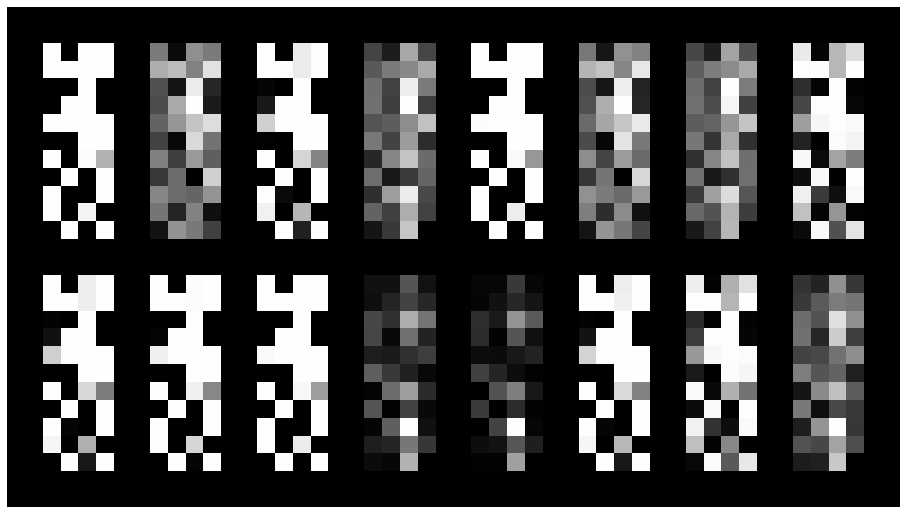

Epoch: [39/200], Batch Num: [0/10]
Discriminator Loss: 0.4123, Generator Loss: 3.5036
D(x): 0.8642, D(G(z)): 0.1580


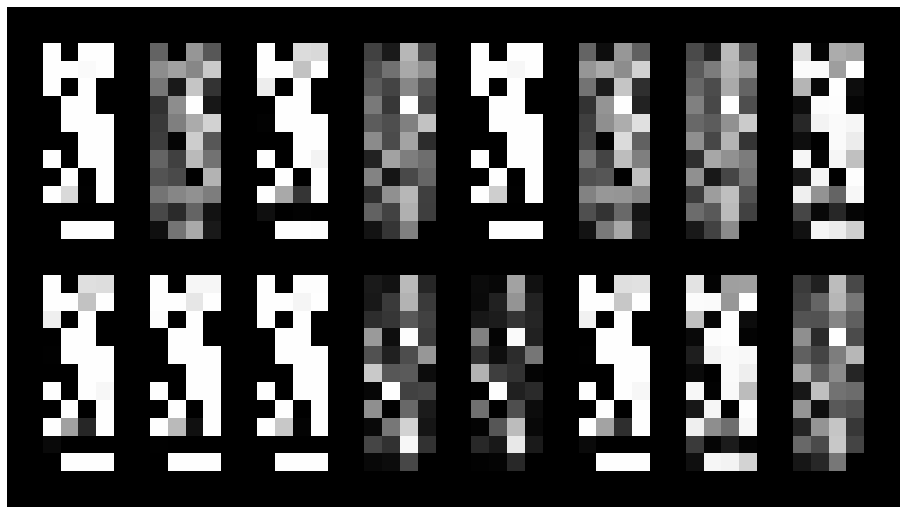

Epoch: [40/200], Batch Num: [0/10]
Discriminator Loss: 0.3160, Generator Loss: 4.1886
D(x): 0.9020, D(G(z)): 0.1159


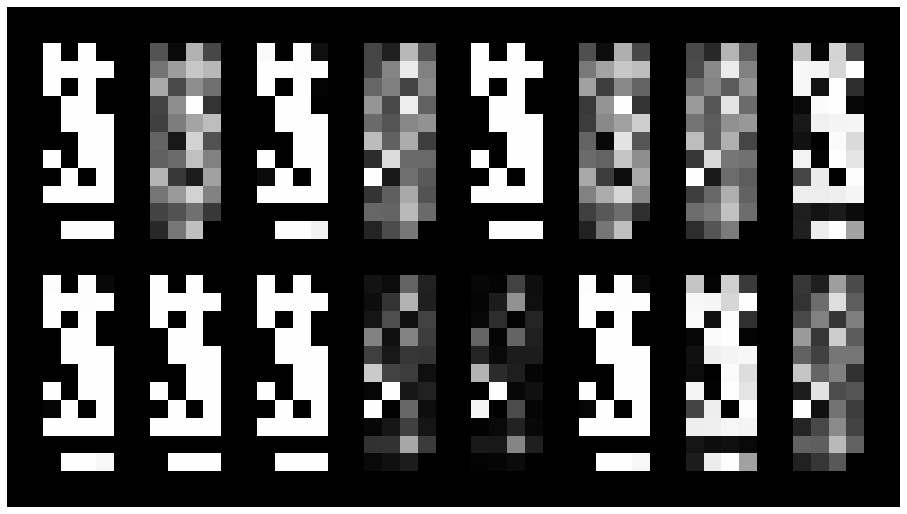

Epoch: [41/200], Batch Num: [0/10]
Discriminator Loss: 0.4122, Generator Loss: 5.8033
D(x): 0.8408, D(G(z)): 0.1093


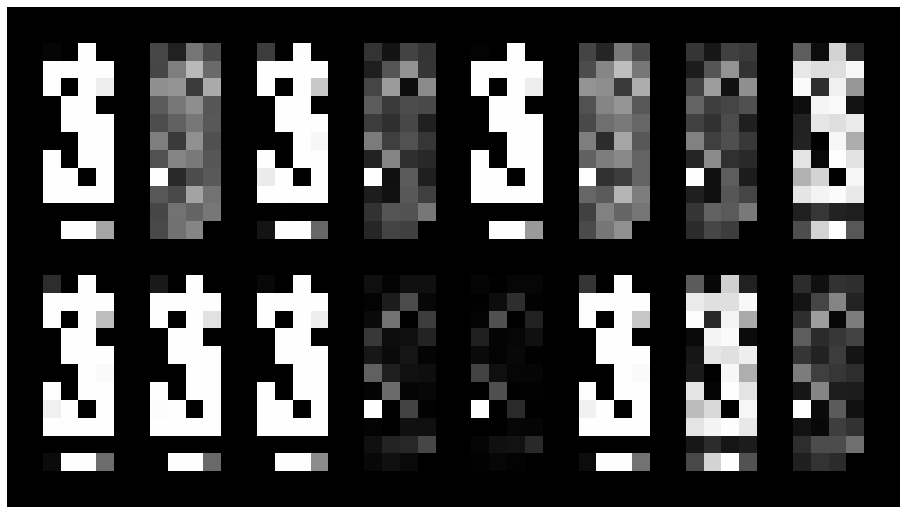

Epoch: [42/200], Batch Num: [0/10]
Discriminator Loss: 0.5900, Generator Loss: 3.8918
D(x): 0.8440, D(G(z)): 0.1939


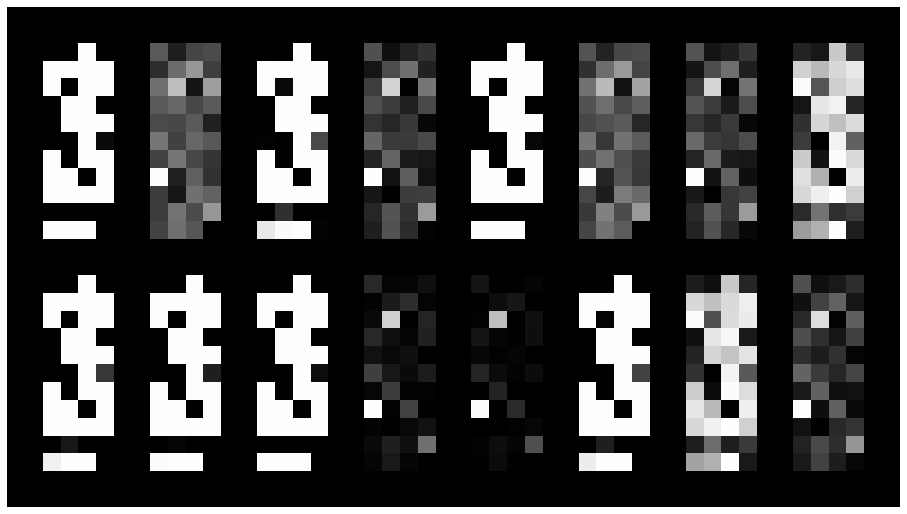

Epoch: [43/200], Batch Num: [0/10]
Discriminator Loss: 0.5095, Generator Loss: 3.5546
D(x): 0.8384, D(G(z)): 0.1754


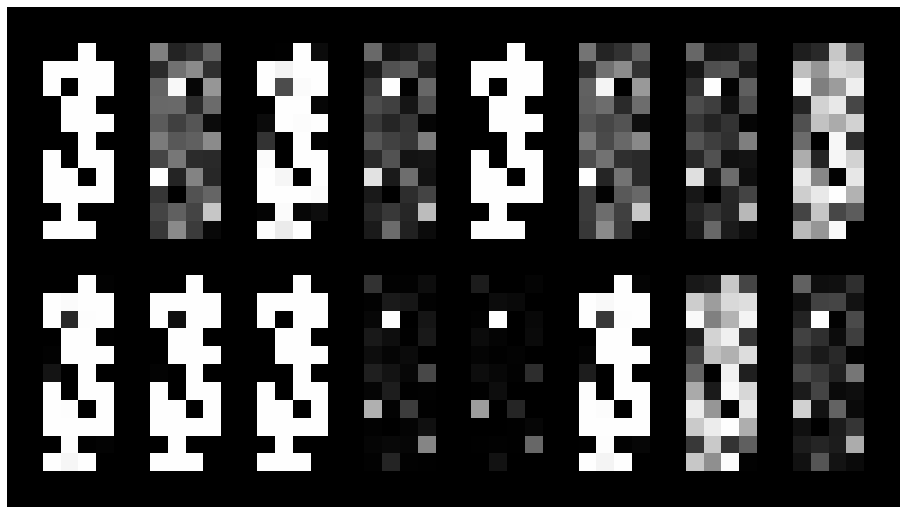

Epoch: [44/200], Batch Num: [0/10]
Discriminator Loss: 0.4645, Generator Loss: 4.9125
D(x): 0.8233, D(G(z)): 0.1561


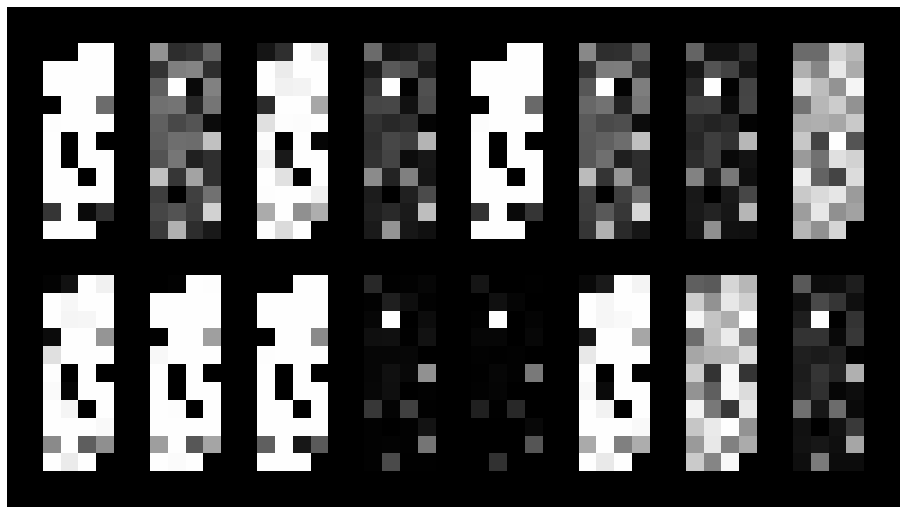

Epoch: [45/200], Batch Num: [0/10]
Discriminator Loss: 0.6154, Generator Loss: 3.6883
D(x): 0.8284, D(G(z)): 0.2517


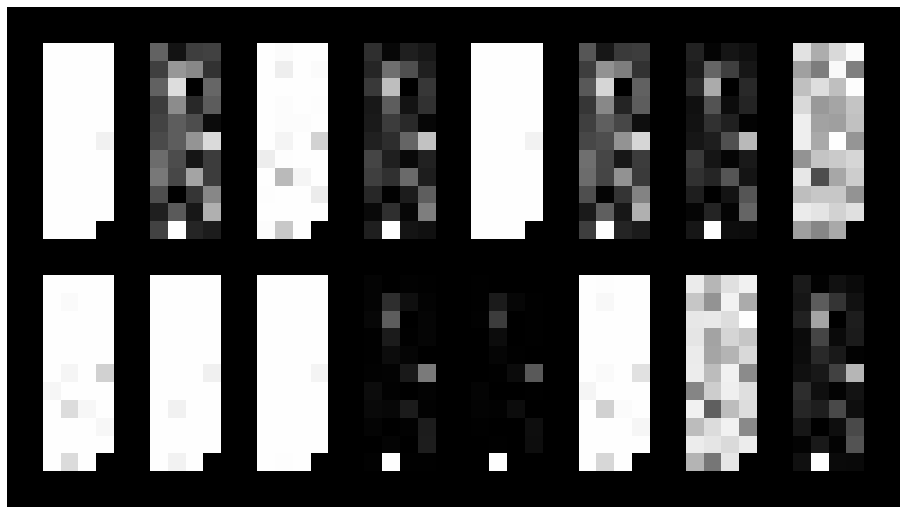

Epoch: [46/200], Batch Num: [0/10]
Discriminator Loss: 1.2244, Generator Loss: 2.0450
D(x): 0.6588, D(G(z)): 0.3921


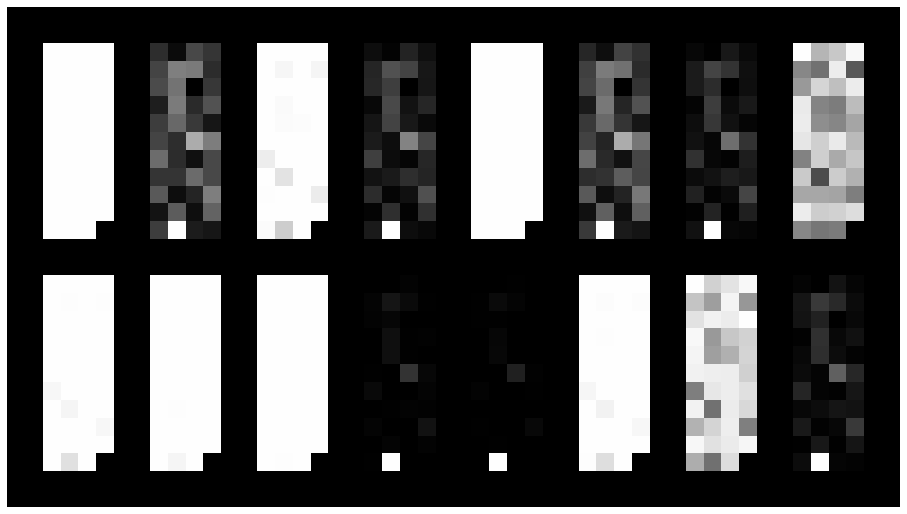

Epoch: [47/200], Batch Num: [0/10]
Discriminator Loss: 0.8647, Generator Loss: 2.4630
D(x): 0.6673, D(G(z)): 0.1896


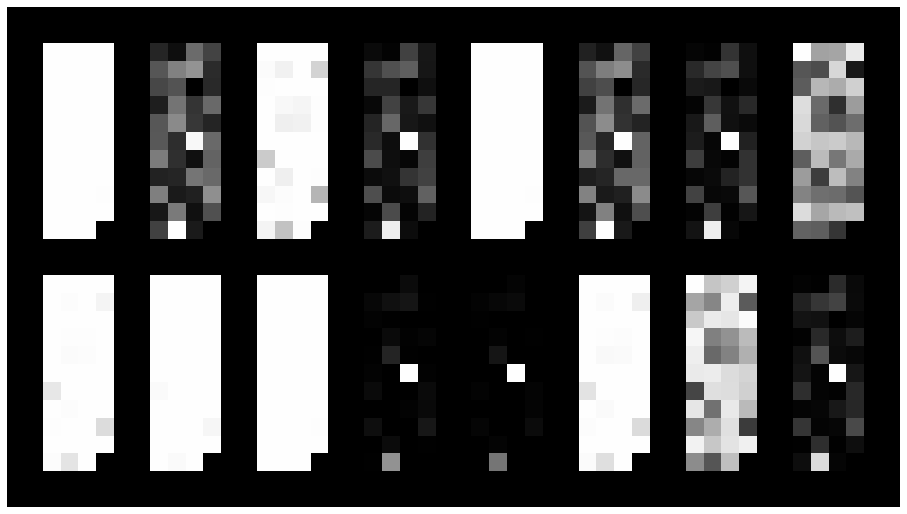

Epoch: [48/200], Batch Num: [0/10]
Discriminator Loss: 1.3611, Generator Loss: 1.4105
D(x): 0.6797, D(G(z)): 0.4731


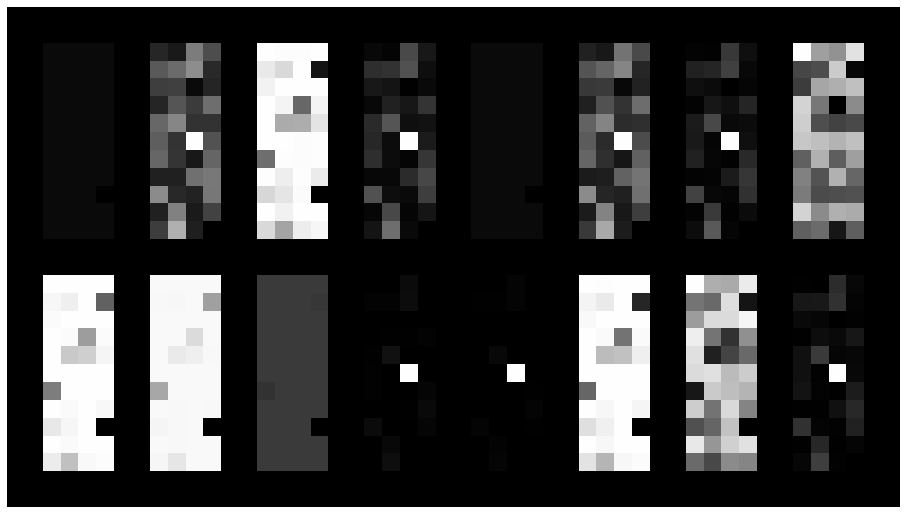

Epoch: [49/200], Batch Num: [0/10]
Discriminator Loss: 1.3022, Generator Loss: 0.7916
D(x): 0.6551, D(G(z)): 0.4216


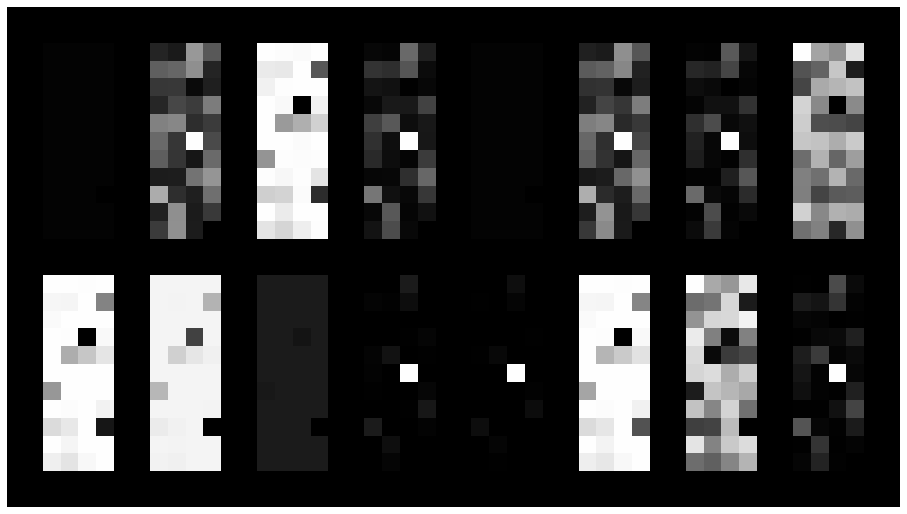

Epoch: [50/200], Batch Num: [0/10]
Discriminator Loss: 1.1072, Generator Loss: 0.9296
D(x): 0.7227, D(G(z)): 0.4792


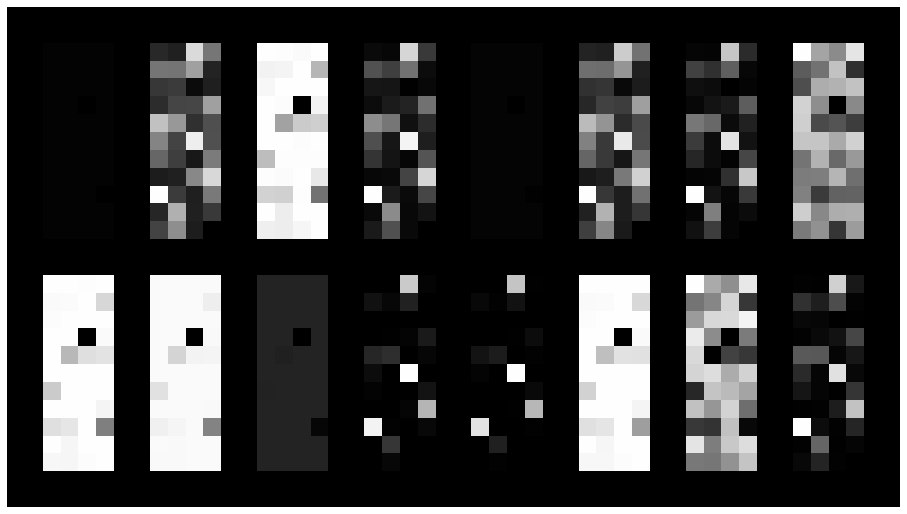

Epoch: [51/200], Batch Num: [0/10]
Discriminator Loss: 0.8822, Generator Loss: 1.2247
D(x): 0.7285, D(G(z)): 0.3642


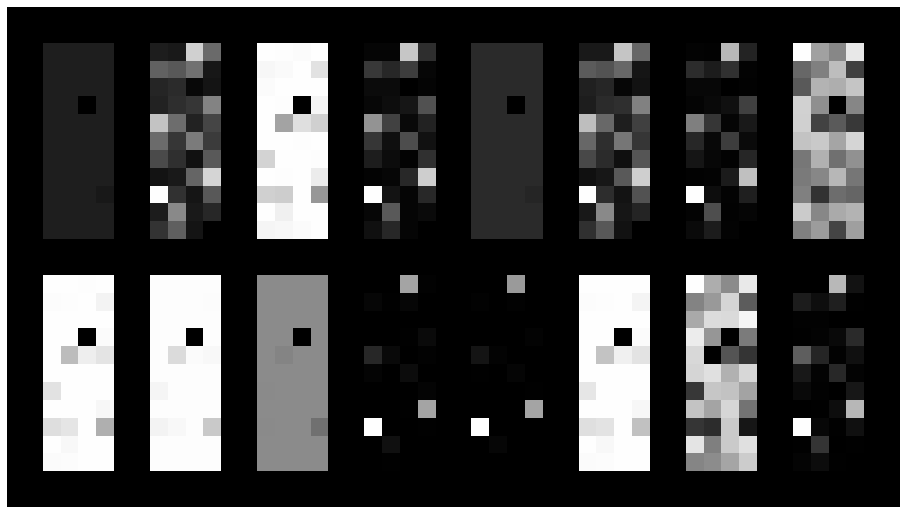

Epoch: [52/200], Batch Num: [0/10]
Discriminator Loss: 0.8355, Generator Loss: 1.3077
D(x): 0.7320, D(G(z)): 0.3287


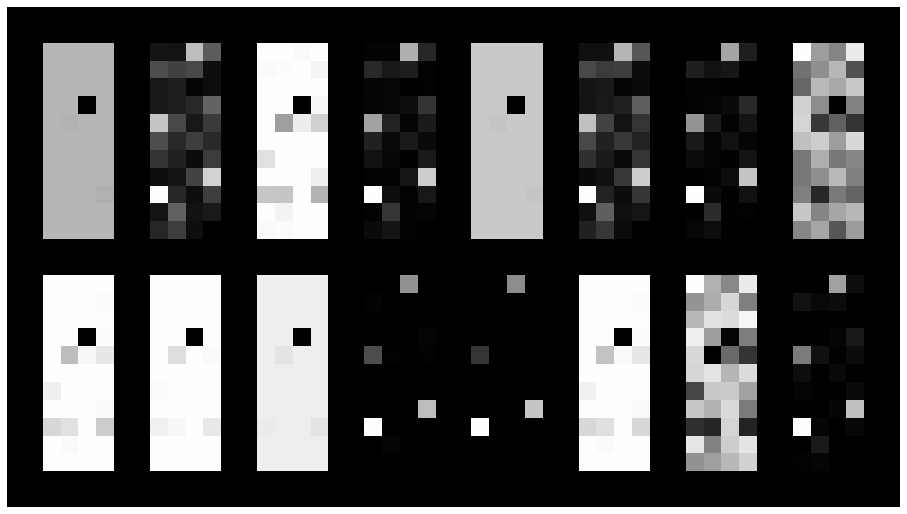

Epoch: [53/200], Batch Num: [0/10]
Discriminator Loss: 0.7436, Generator Loss: 1.4902
D(x): 0.7549, D(G(z)): 0.3071


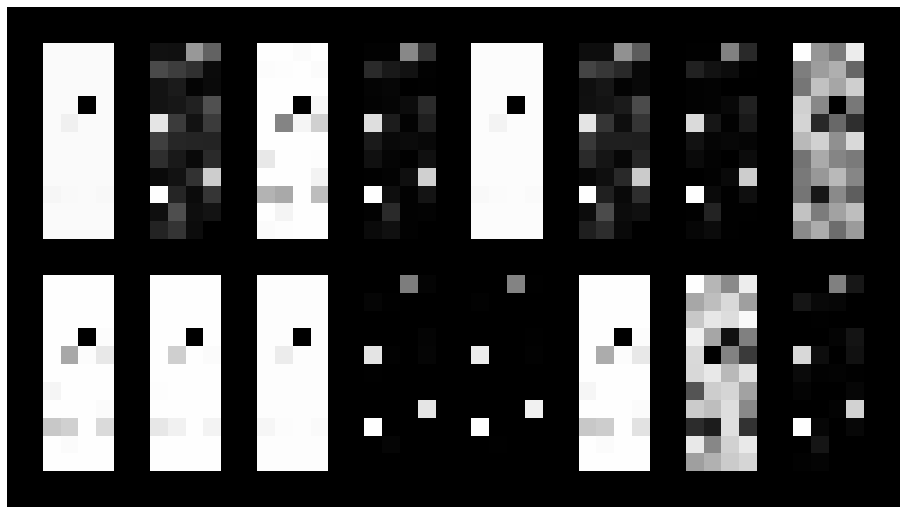

Epoch: [54/200], Batch Num: [0/10]
Discriminator Loss: 0.5432, Generator Loss: 1.8385
D(x): 0.7792, D(G(z)): 0.1950


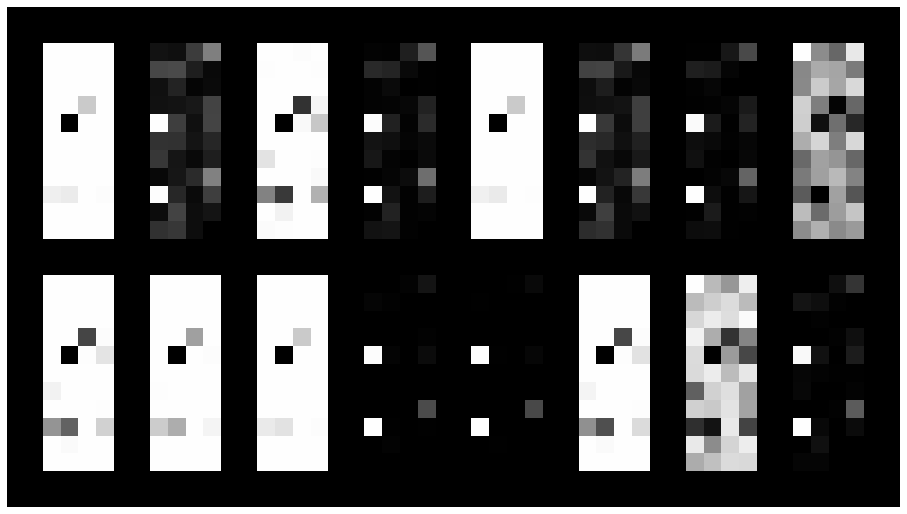

Epoch: [55/200], Batch Num: [0/10]
Discriminator Loss: 0.3839, Generator Loss: 2.3125
D(x): 0.8568, D(G(z)): 0.1628


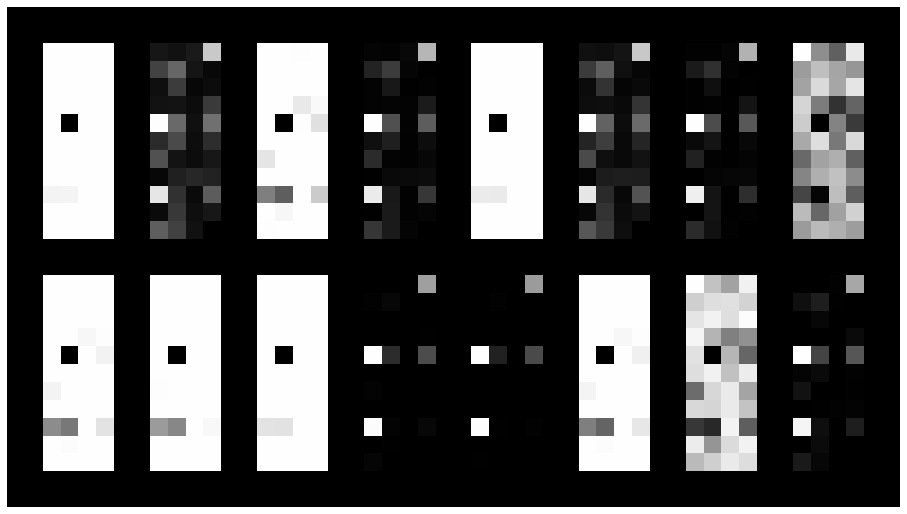

Epoch: [56/200], Batch Num: [0/10]
Discriminator Loss: 0.4378, Generator Loss: 2.5748
D(x): 0.8097, D(G(z)): 0.1334


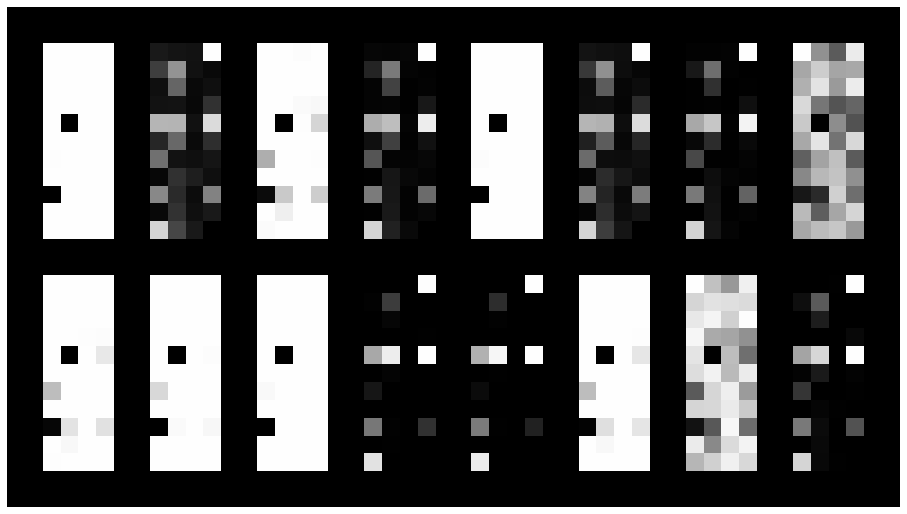

Epoch: [57/200], Batch Num: [0/10]
Discriminator Loss: 0.6186, Generator Loss: 3.0008
D(x): 0.8449, D(G(z)): 0.2282


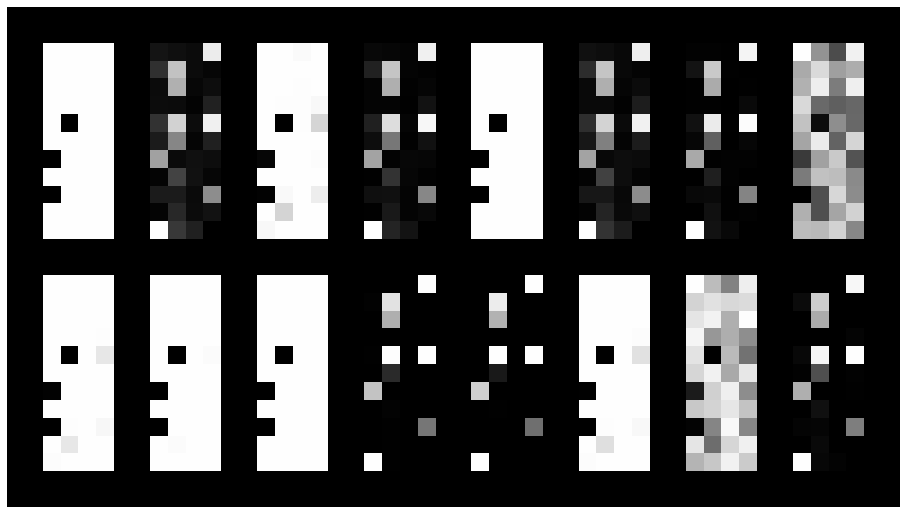

Epoch: [58/200], Batch Num: [0/10]
Discriminator Loss: 0.3158, Generator Loss: 3.7457
D(x): 0.8568, D(G(z)): 0.0863


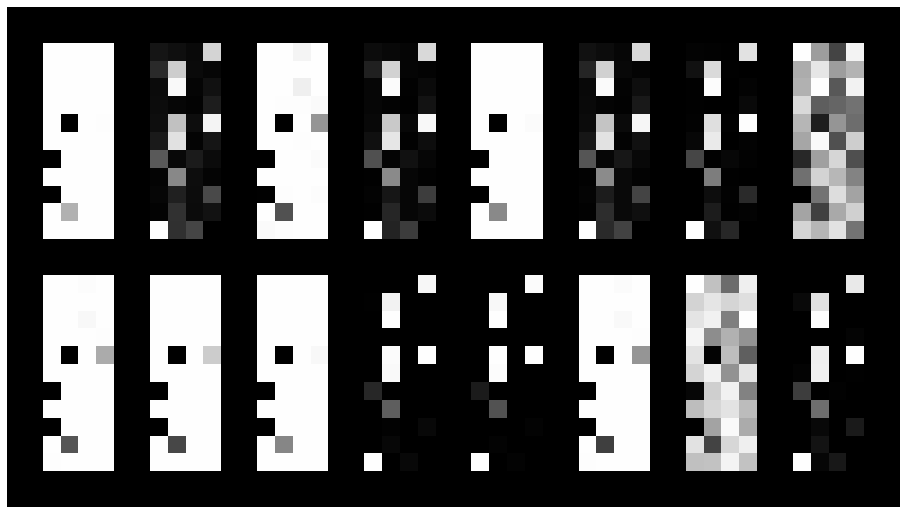

Epoch: [59/200], Batch Num: [0/10]
Discriminator Loss: 0.1563, Generator Loss: 4.3952
D(x): 0.9247, D(G(z)): 0.0428


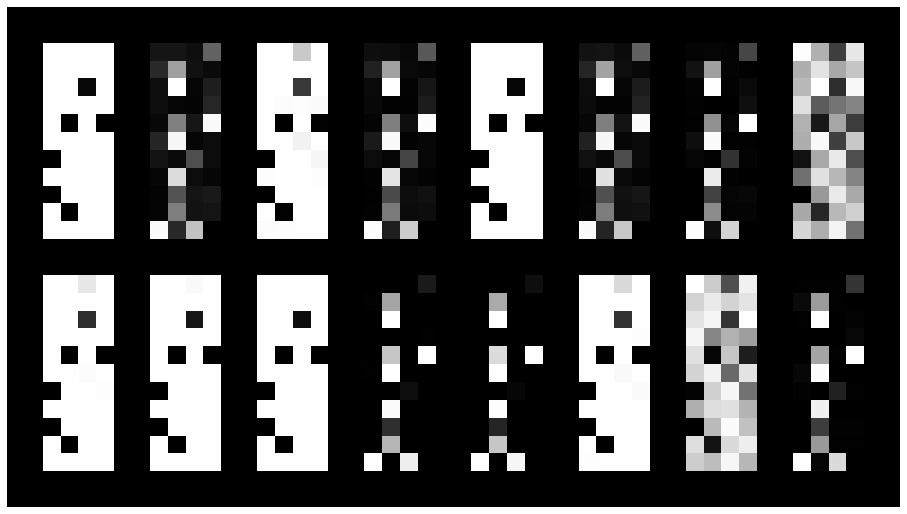

Epoch: [60/200], Batch Num: [0/10]
Discriminator Loss: 0.2241, Generator Loss: 4.5573
D(x): 0.9362, D(G(z)): 0.1036


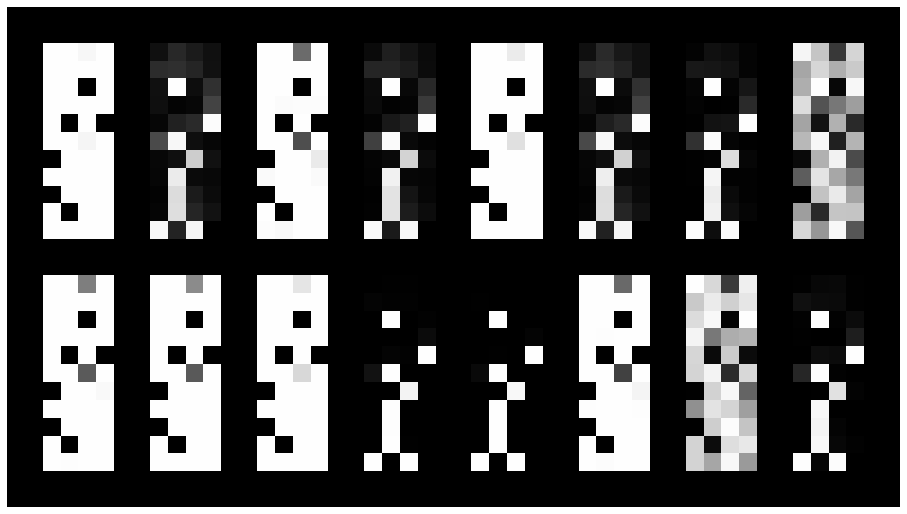

Epoch: [61/200], Batch Num: [0/10]
Discriminator Loss: 0.2213, Generator Loss: 5.7036
D(x): 0.8924, D(G(z)): 0.0390


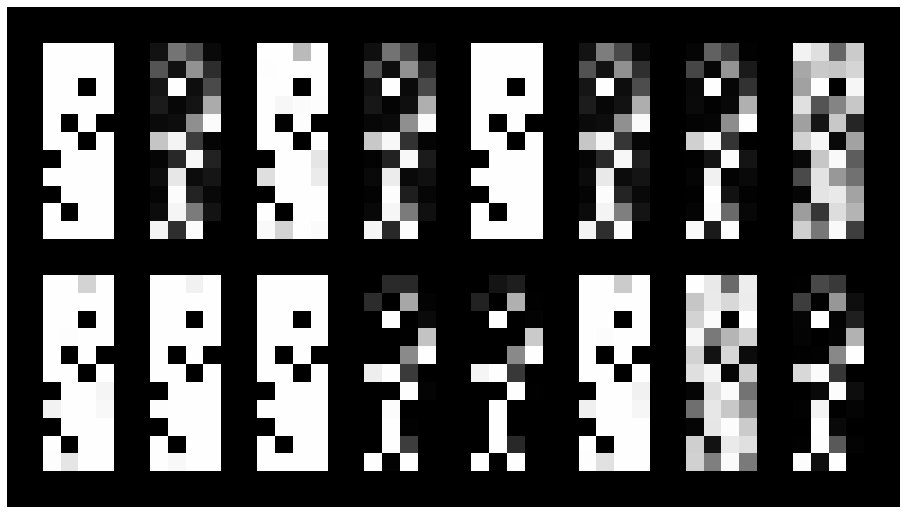

Epoch: [62/200], Batch Num: [0/10]
Discriminator Loss: 0.2227, Generator Loss: 5.5004
D(x): 0.9310, D(G(z)): 0.0876


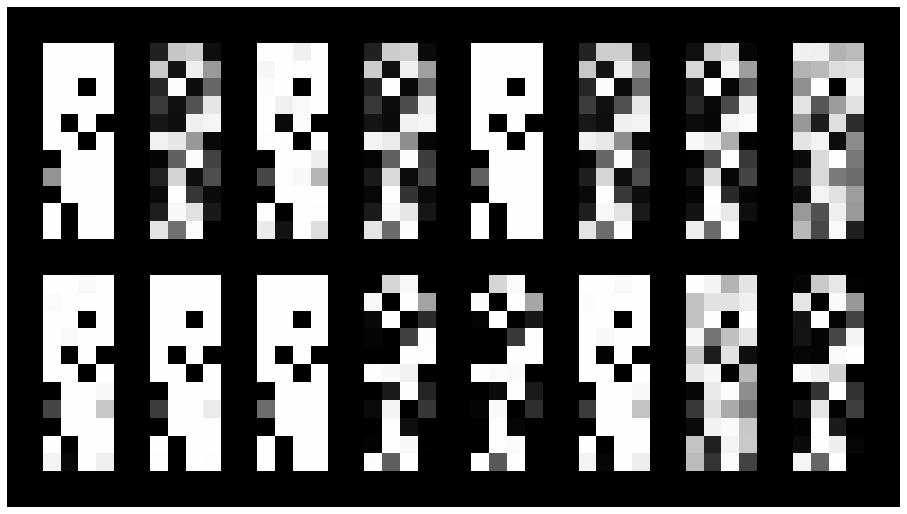

Epoch: [63/200], Batch Num: [0/10]
Discriminator Loss: 0.1854, Generator Loss: 6.7763
D(x): 0.9057, D(G(z)): 0.0216


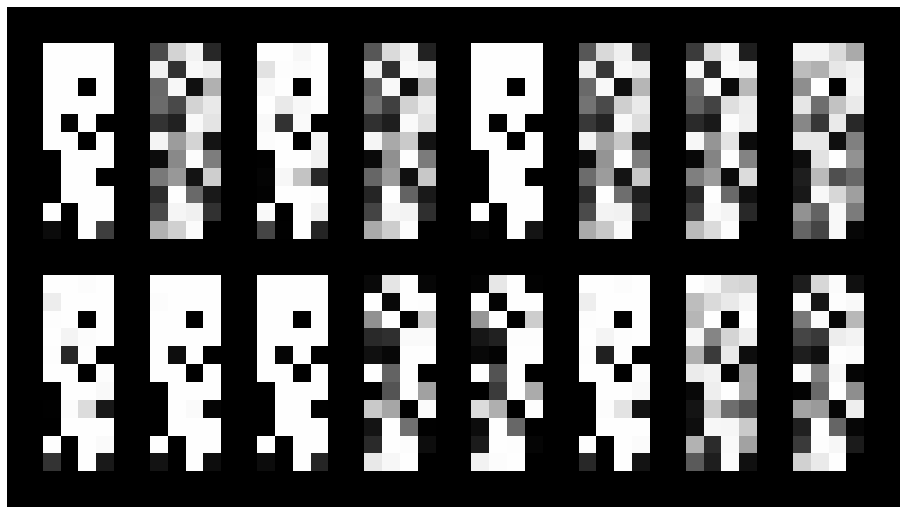

Epoch: [64/200], Batch Num: [0/10]
Discriminator Loss: 0.1797, Generator Loss: 4.7223
D(x): 0.9337, D(G(z)): 0.0577


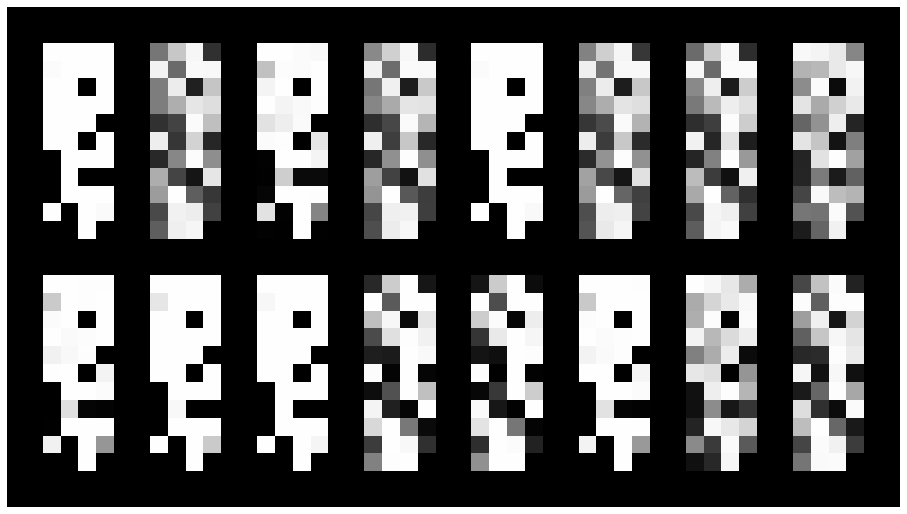

Epoch: [65/200], Batch Num: [0/10]
Discriminator Loss: 0.2807, Generator Loss: 6.0095
D(x): 0.8953, D(G(z)): 0.0668


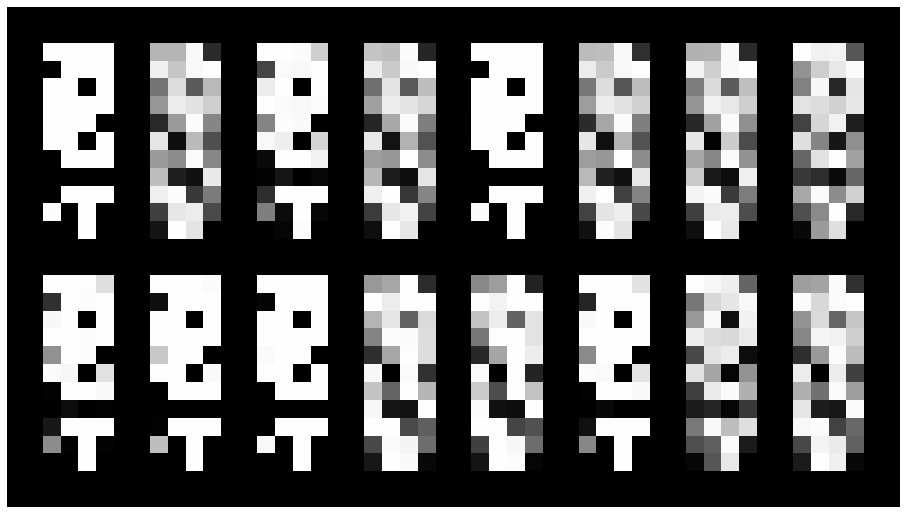

Epoch: [66/200], Batch Num: [0/10]
Discriminator Loss: 0.2732, Generator Loss: 6.6062
D(x): 0.9192, D(G(z)): 0.0797


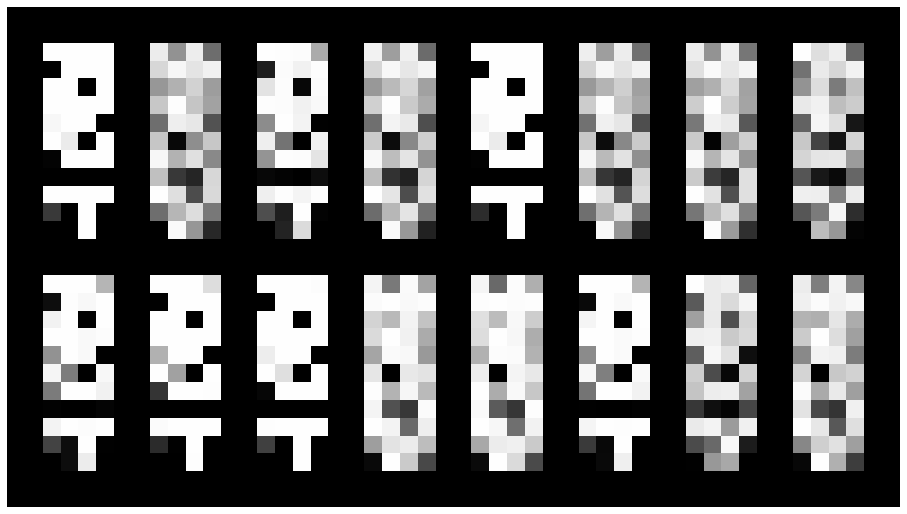

Epoch: [67/200], Batch Num: [0/10]
Discriminator Loss: 0.2899, Generator Loss: 7.0622
D(x): 0.9030, D(G(z)): 0.0663


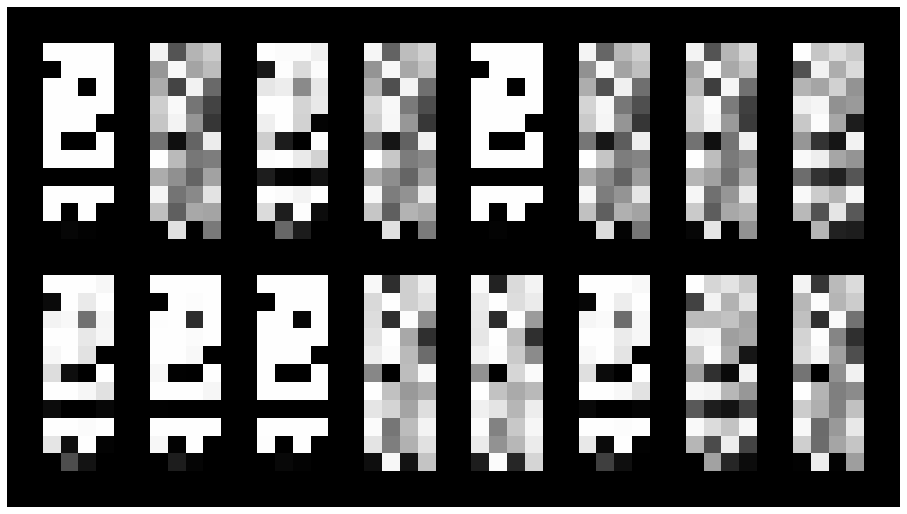

Epoch: [68/200], Batch Num: [0/10]
Discriminator Loss: 0.7994, Generator Loss: 5.3982
D(x): 0.8188, D(G(z)): 0.1876


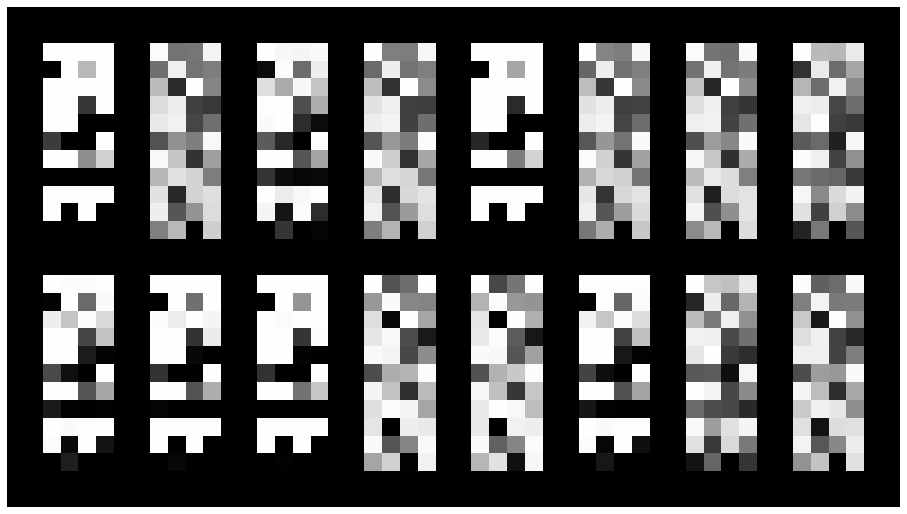

Epoch: [69/200], Batch Num: [0/10]
Discriminator Loss: 0.4820, Generator Loss: 4.3586
D(x): 0.8742, D(G(z)): 0.1489


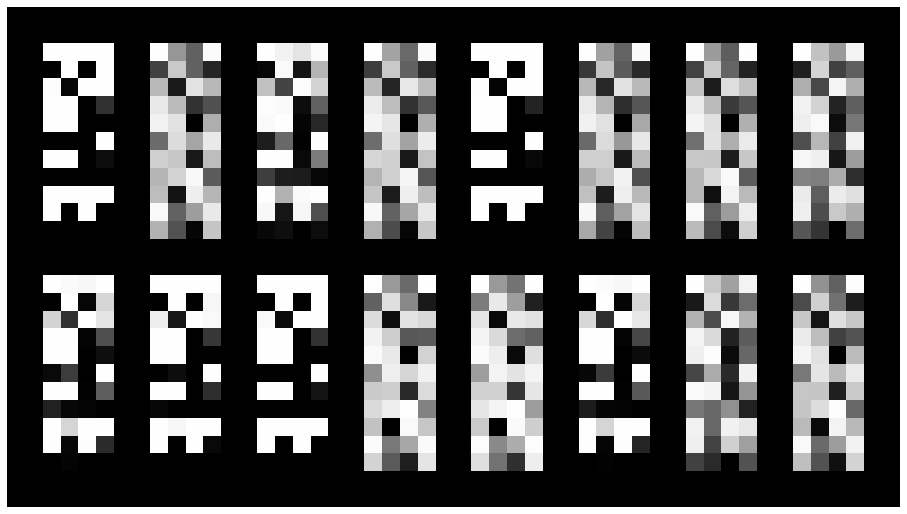

Epoch: [70/200], Batch Num: [0/10]
Discriminator Loss: 0.2486, Generator Loss: 5.7643
D(x): 0.9004, D(G(z)): 0.0525


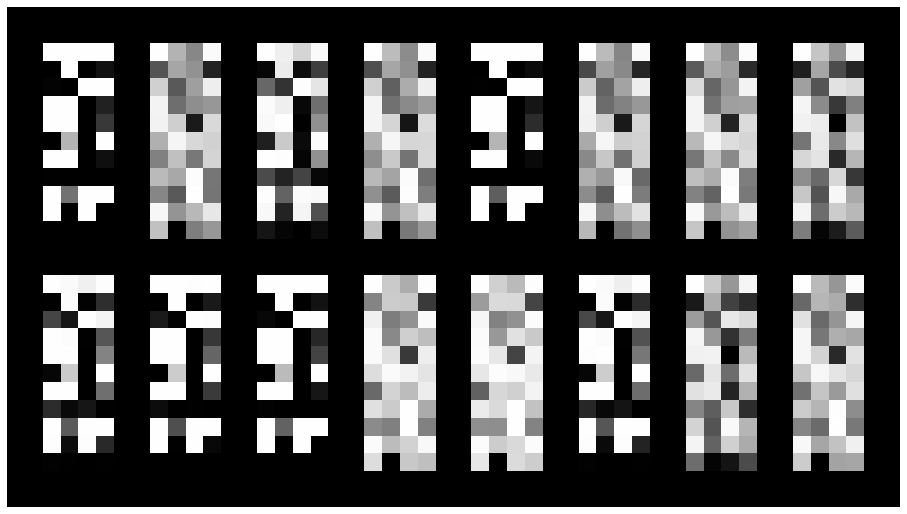

Epoch: [71/200], Batch Num: [0/10]
Discriminator Loss: 0.3620, Generator Loss: 6.4545
D(x): 0.9053, D(G(z)): 0.0969


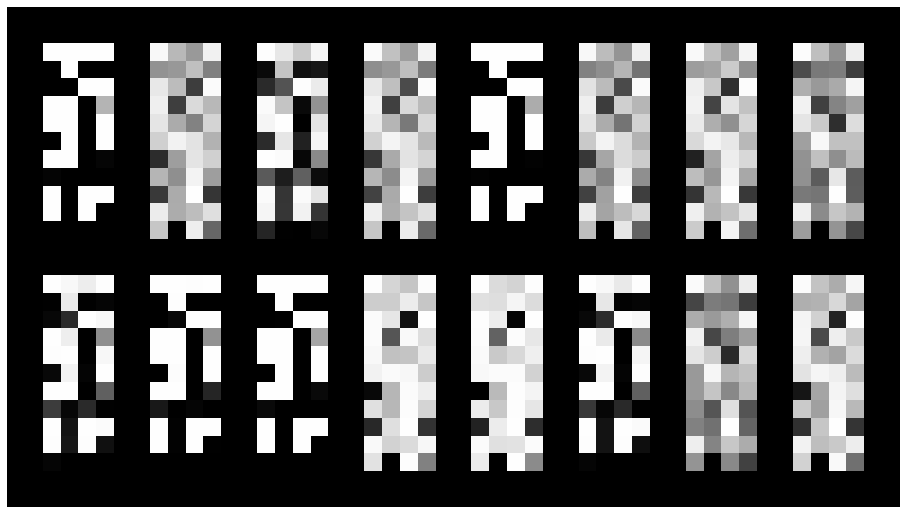

Epoch: [72/200], Batch Num: [0/10]
Discriminator Loss: 0.3001, Generator Loss: 7.0046
D(x): 0.9041, D(G(z)): 0.0978


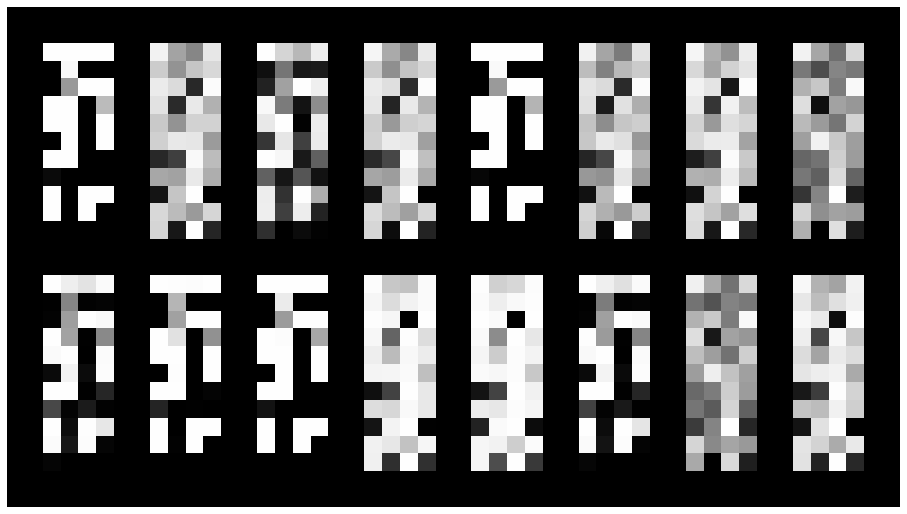

Epoch: [73/200], Batch Num: [0/10]
Discriminator Loss: 0.1867, Generator Loss: 6.2034
D(x): 0.9072, D(G(z)): 0.0409


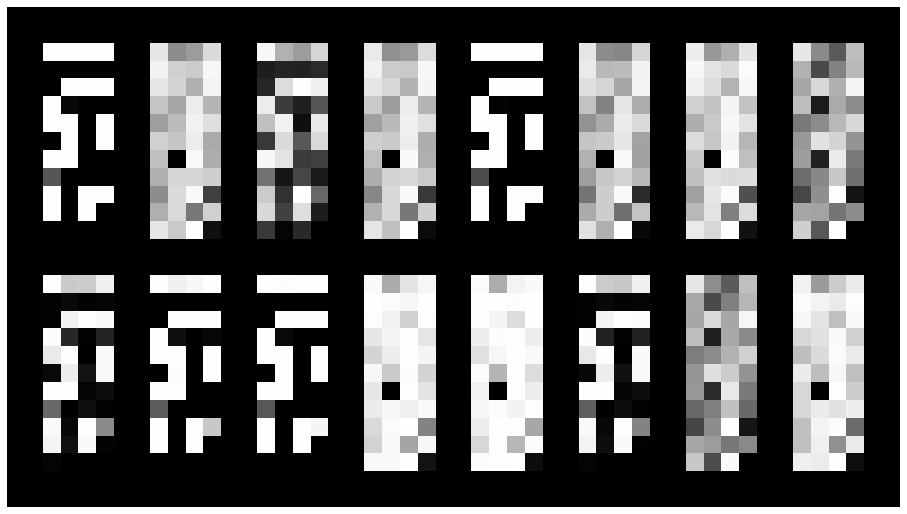

Epoch: [74/200], Batch Num: [0/10]
Discriminator Loss: 0.5363, Generator Loss: 3.4448
D(x): 0.8170, D(G(z)): 0.1282


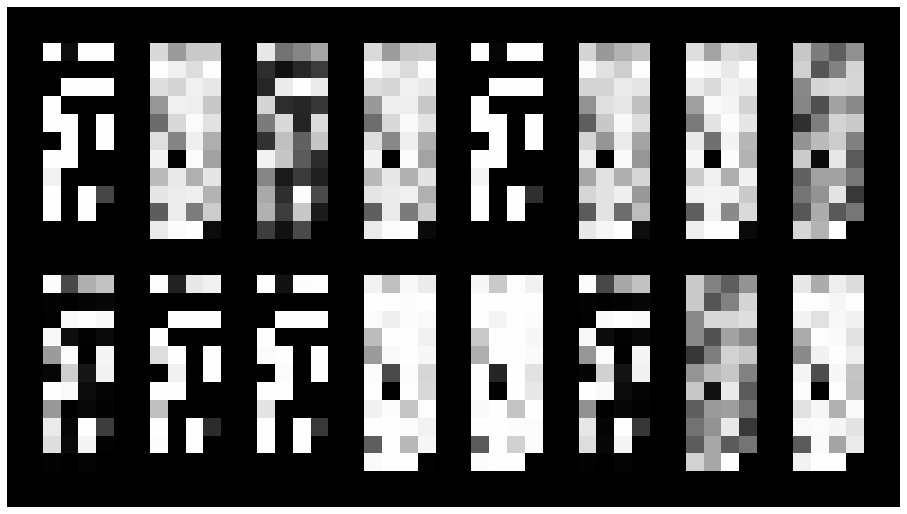

Epoch: [75/200], Batch Num: [0/10]
Discriminator Loss: 0.5358, Generator Loss: 3.3086
D(x): 0.8252, D(G(z)): 0.1439


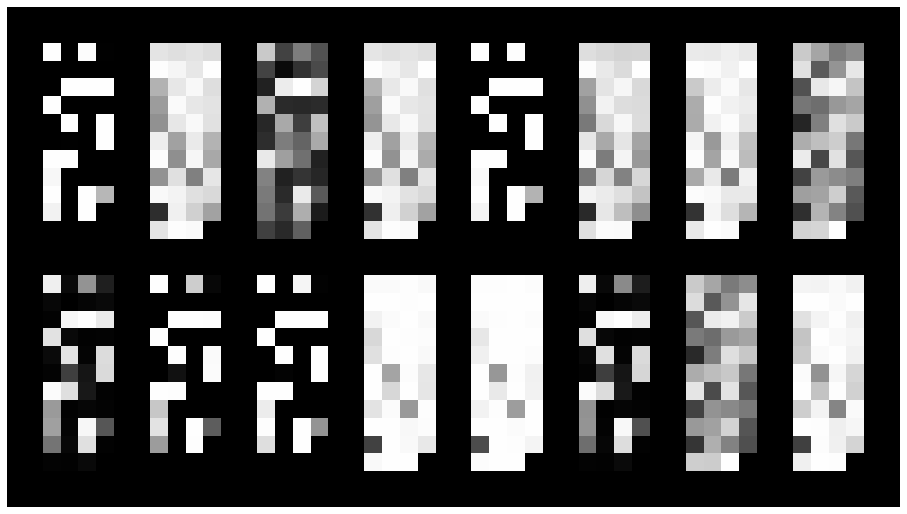

Epoch: [76/200], Batch Num: [0/10]
Discriminator Loss: 0.5069, Generator Loss: 3.4162
D(x): 0.8777, D(G(z)): 0.1971


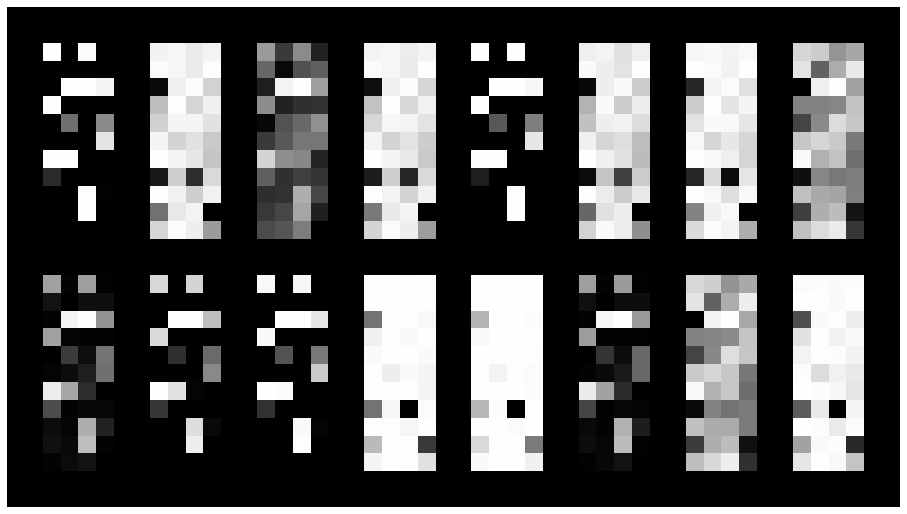

Epoch: [77/200], Batch Num: [0/10]
Discriminator Loss: 1.0501, Generator Loss: 2.8464
D(x): 0.7652, D(G(z)): 0.2899


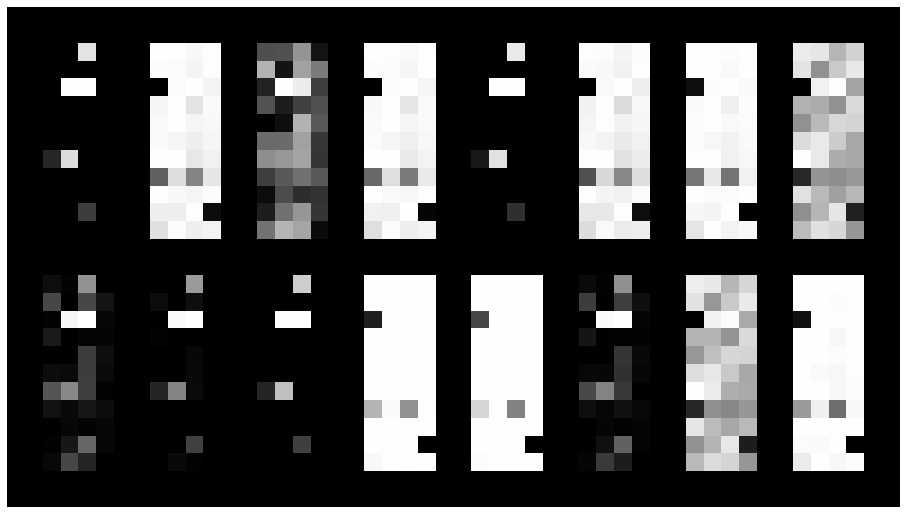

Epoch: [78/200], Batch Num: [0/10]
Discriminator Loss: 0.8744, Generator Loss: 3.5678
D(x): 0.6471, D(G(z)): 0.1145


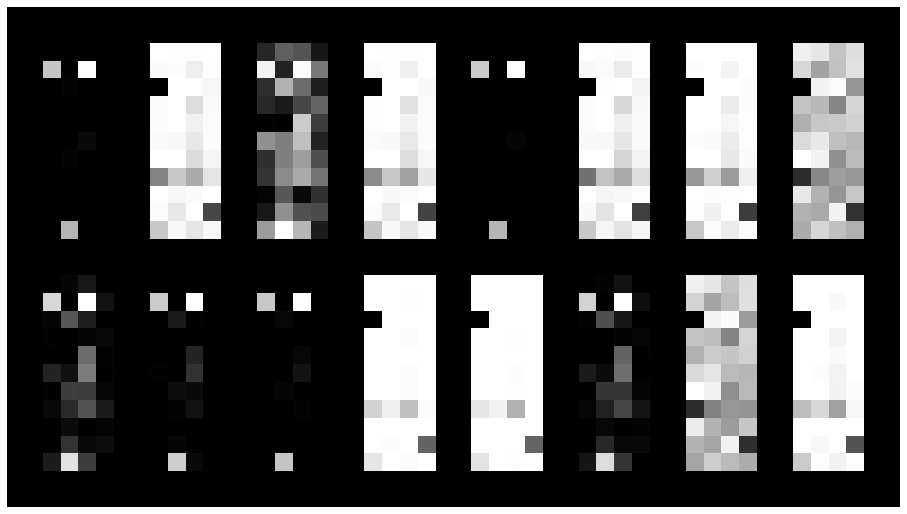

Epoch: [79/200], Batch Num: [0/10]
Discriminator Loss: 1.0596, Generator Loss: 1.7495
D(x): 0.7127, D(G(z)): 0.3193


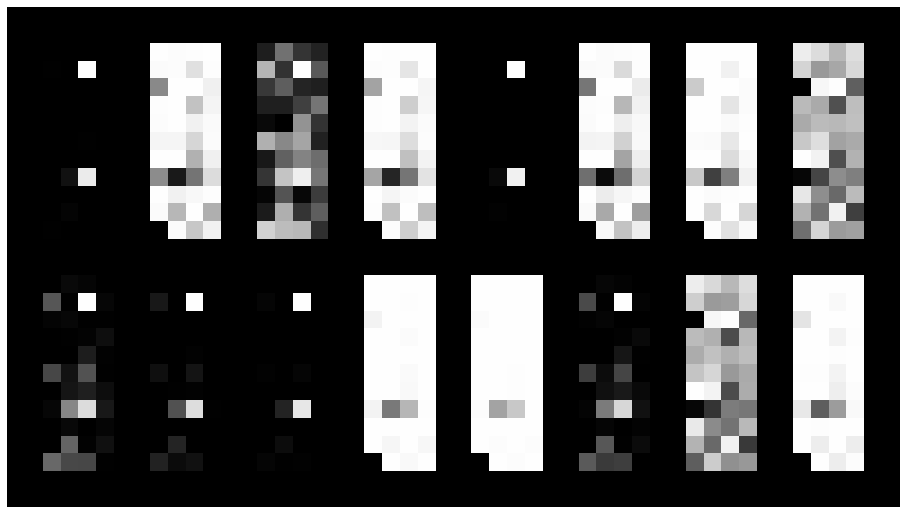

Epoch: [80/200], Batch Num: [0/10]
Discriminator Loss: 0.7797, Generator Loss: 1.8850
D(x): 0.7142, D(G(z)): 0.2487


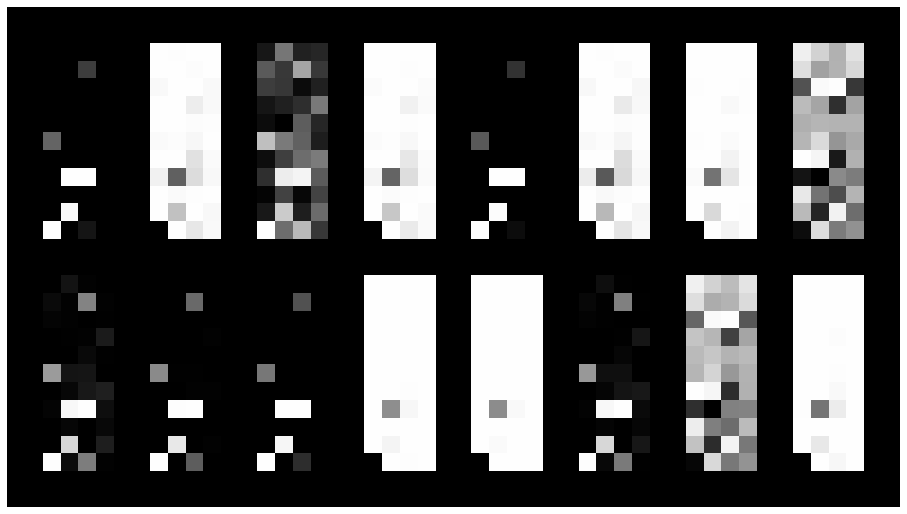

Epoch: [81/200], Batch Num: [0/10]
Discriminator Loss: 0.5683, Generator Loss: 2.3570
D(x): 0.7672, D(G(z)): 0.1834


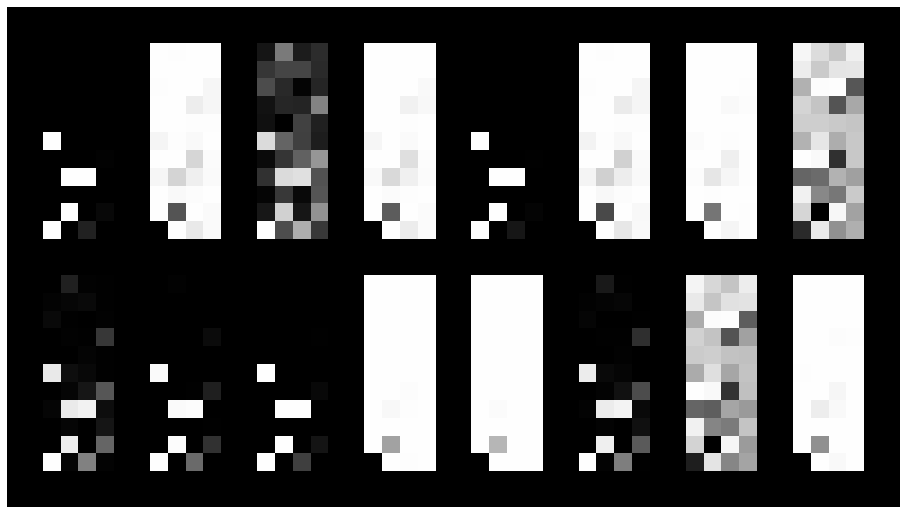

Epoch: [82/200], Batch Num: [0/10]
Discriminator Loss: 0.3151, Generator Loss: 3.8957
D(x): 0.8579, D(G(z)): 0.1006


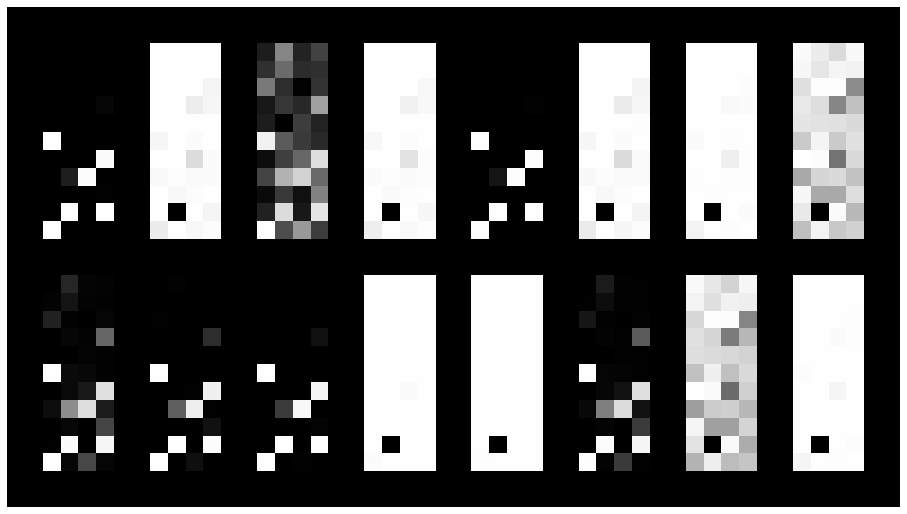

Epoch: [83/200], Batch Num: [0/10]
Discriminator Loss: 0.3577, Generator Loss: 3.0265
D(x): 0.8798, D(G(z)): 0.1455


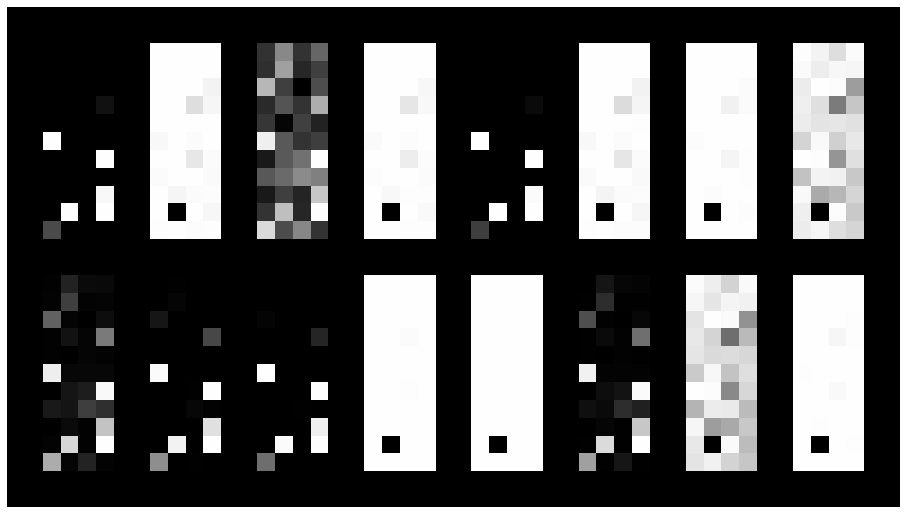

Epoch: [84/200], Batch Num: [0/10]
Discriminator Loss: 0.3499, Generator Loss: 3.0173
D(x): 0.8588, D(G(z)): 0.1254


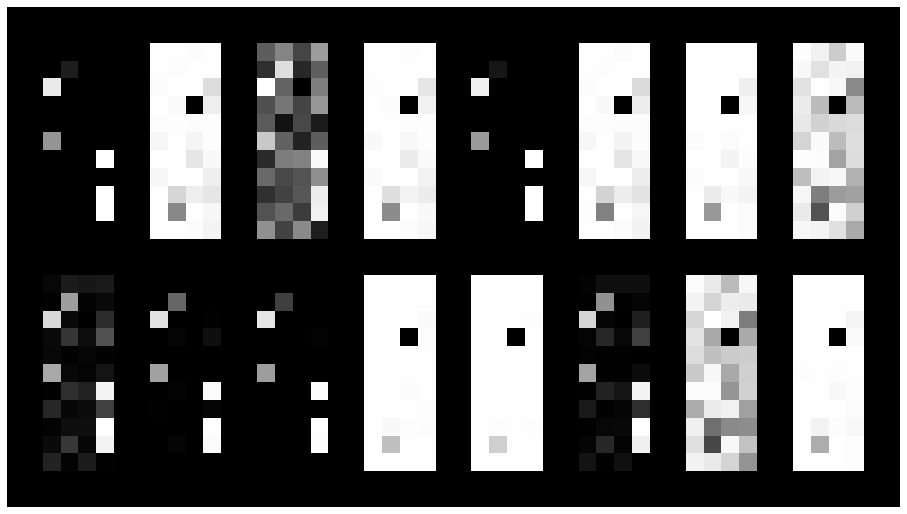

Epoch: [85/200], Batch Num: [0/10]
Discriminator Loss: 0.3910, Generator Loss: 2.9308
D(x): 0.8847, D(G(z)): 0.1856


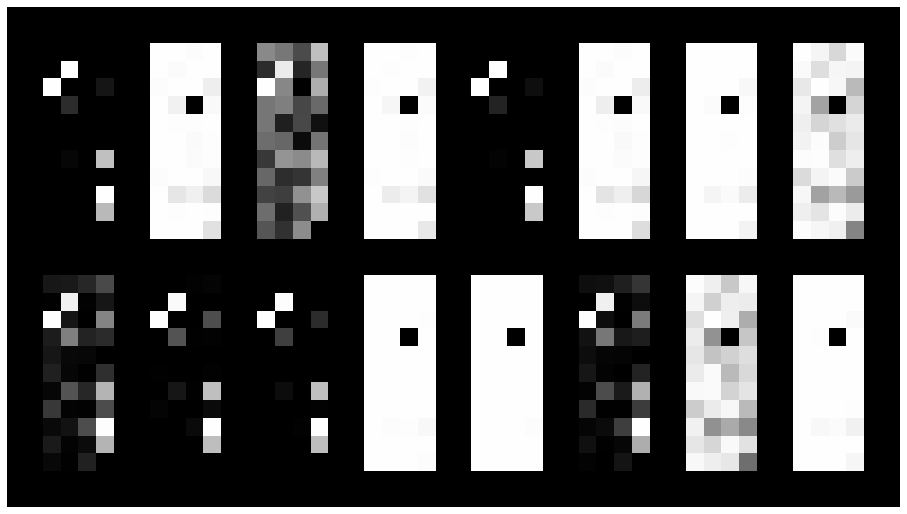

Epoch: [86/200], Batch Num: [0/10]
Discriminator Loss: 0.3818, Generator Loss: 3.6225
D(x): 0.8859, D(G(z)): 0.1558


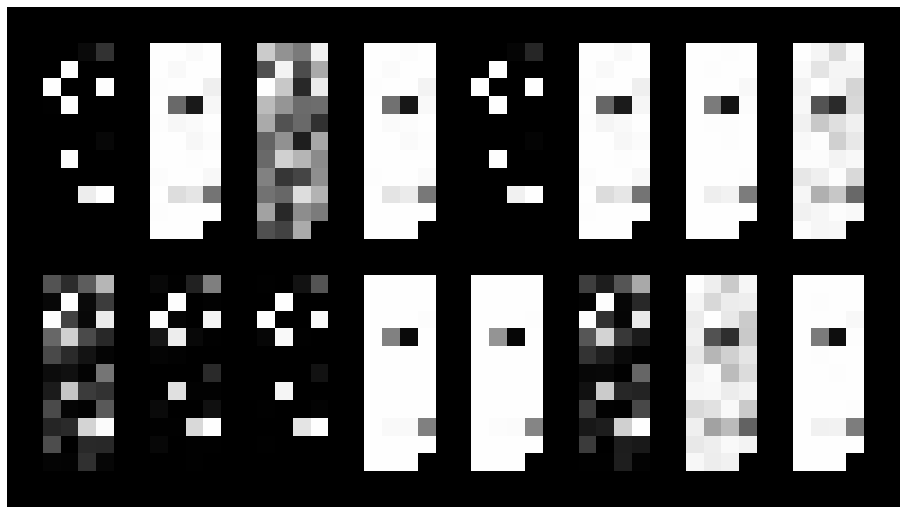

Epoch: [87/200], Batch Num: [0/10]
Discriminator Loss: 0.7441, Generator Loss: 3.7763
D(x): 0.7665, D(G(z)): 0.1882


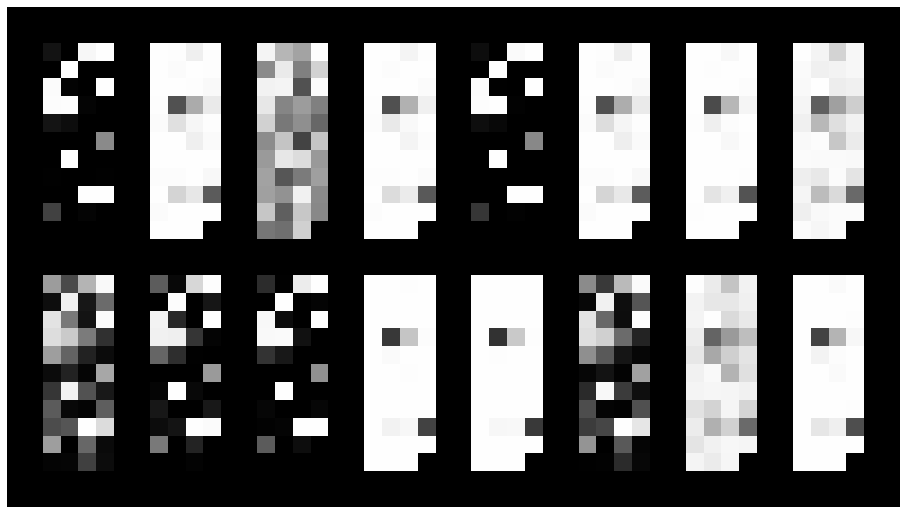

Epoch: [88/200], Batch Num: [0/10]
Discriminator Loss: 0.4523, Generator Loss: 3.7248
D(x): 0.8616, D(G(z)): 0.1598


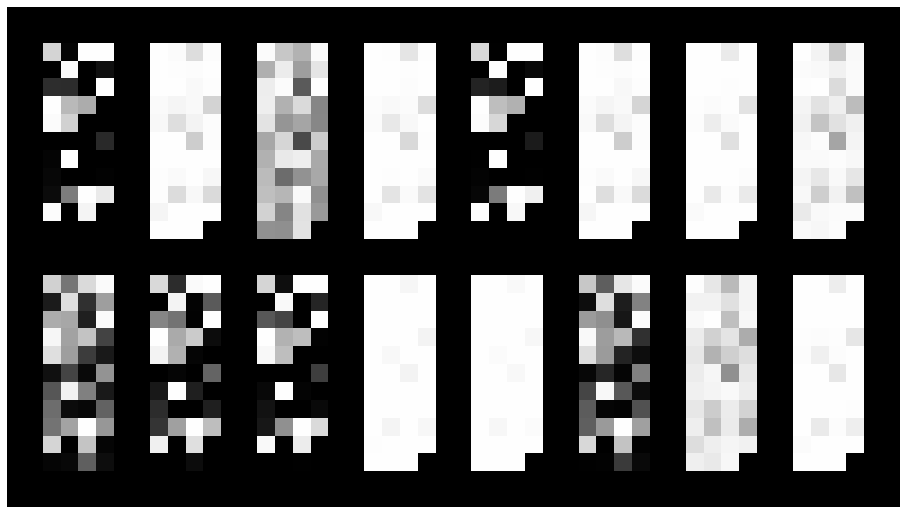

Epoch: [89/200], Batch Num: [0/10]
Discriminator Loss: 0.5379, Generator Loss: 2.8795
D(x): 0.8285, D(G(z)): 0.1353


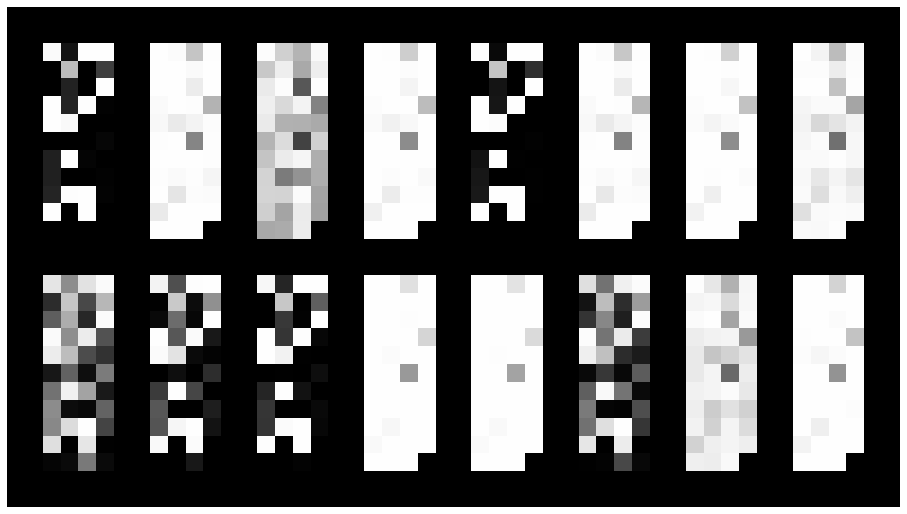

Epoch: [90/200], Batch Num: [0/10]
Discriminator Loss: 0.4543, Generator Loss: 4.2451
D(x): 0.8371, D(G(z)): 0.0634


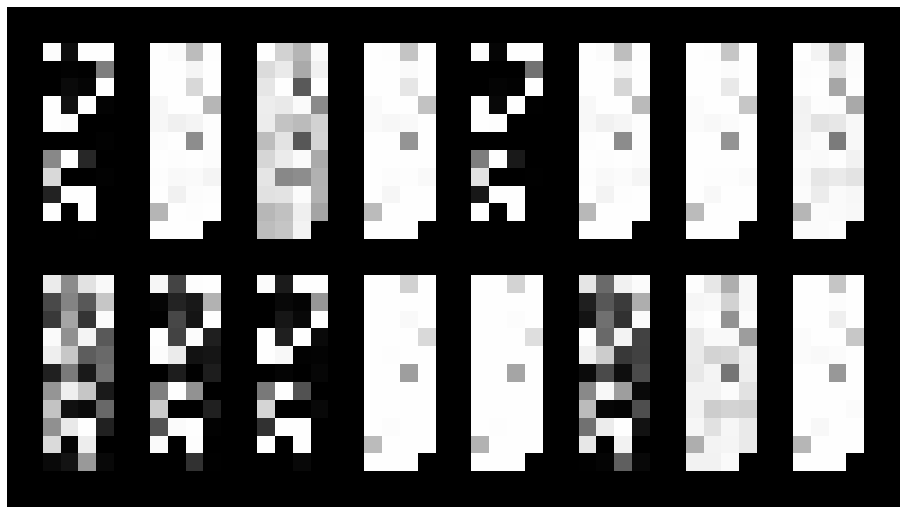

Epoch: [91/200], Batch Num: [0/10]
Discriminator Loss: 0.3273, Generator Loss: 3.7423
D(x): 0.8732, D(G(z)): 0.0725


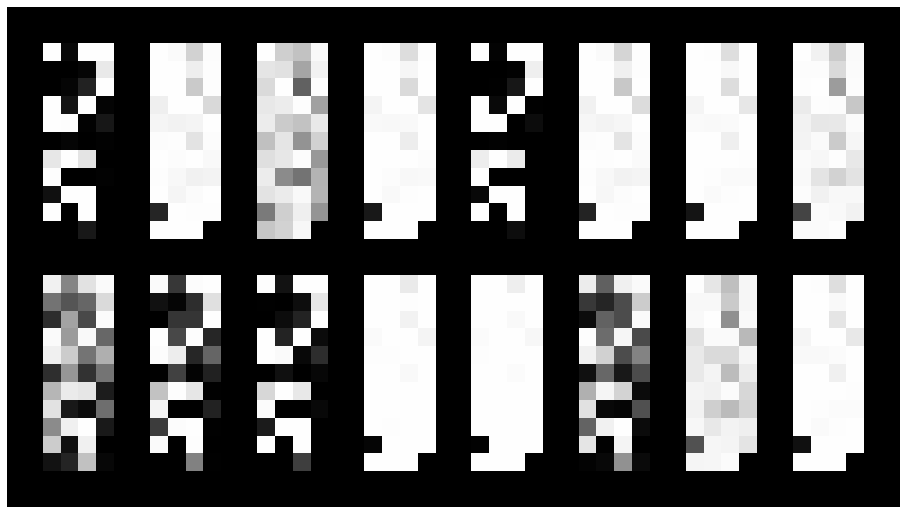

Epoch: [92/200], Batch Num: [0/10]
Discriminator Loss: 0.3398, Generator Loss: 3.4493
D(x): 0.8710, D(G(z)): 0.0601


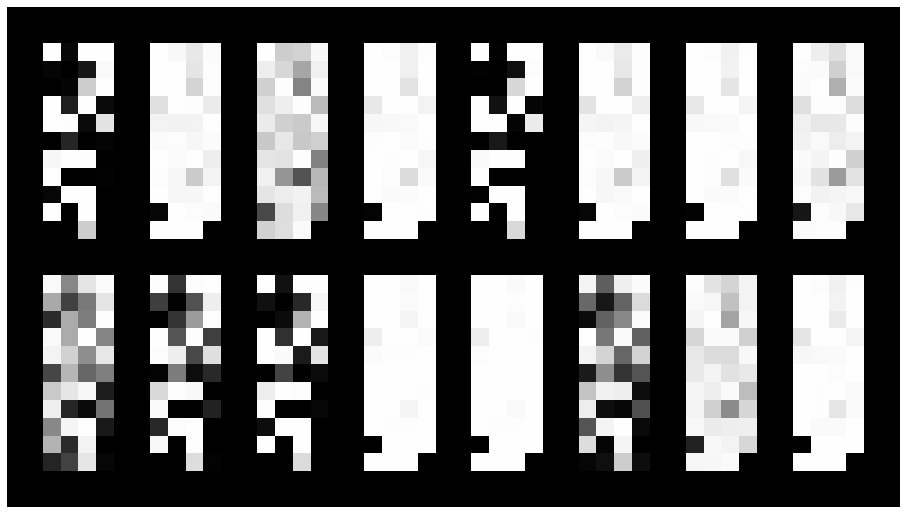

Epoch: [93/200], Batch Num: [0/10]
Discriminator Loss: 0.2399, Generator Loss: 3.3791
D(x): 0.9096, D(G(z)): 0.0772


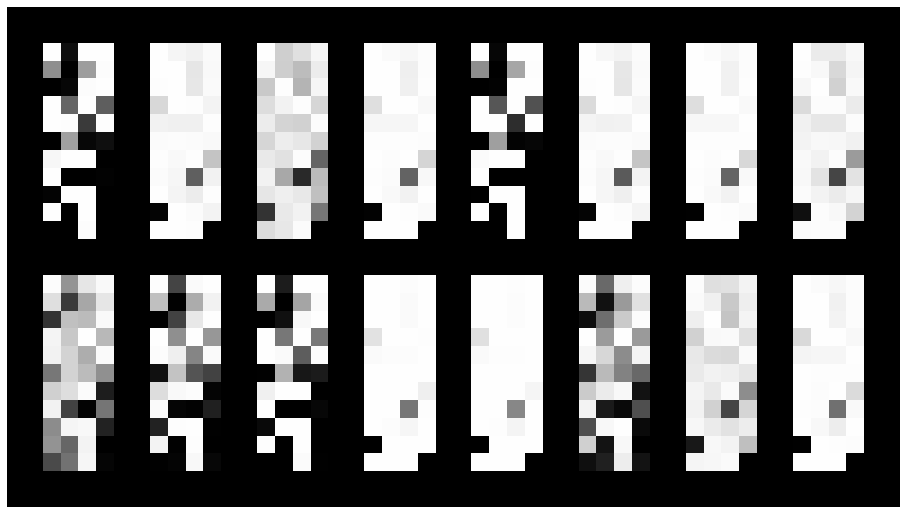

Epoch: [94/200], Batch Num: [0/10]
Discriminator Loss: 0.2158, Generator Loss: 4.0718
D(x): 0.9112, D(G(z)): 0.0507


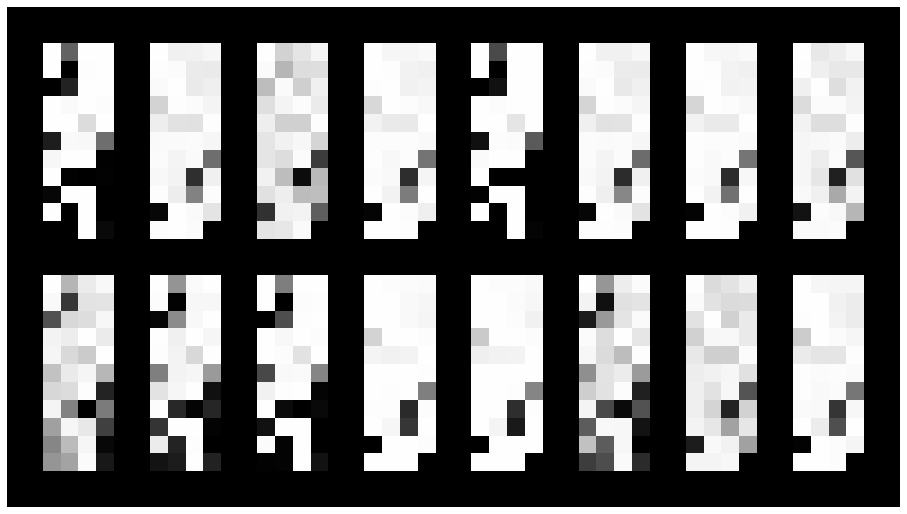

Epoch: [95/200], Batch Num: [0/10]
Discriminator Loss: 0.1702, Generator Loss: 4.3436
D(x): 0.9352, D(G(z)): 0.0477


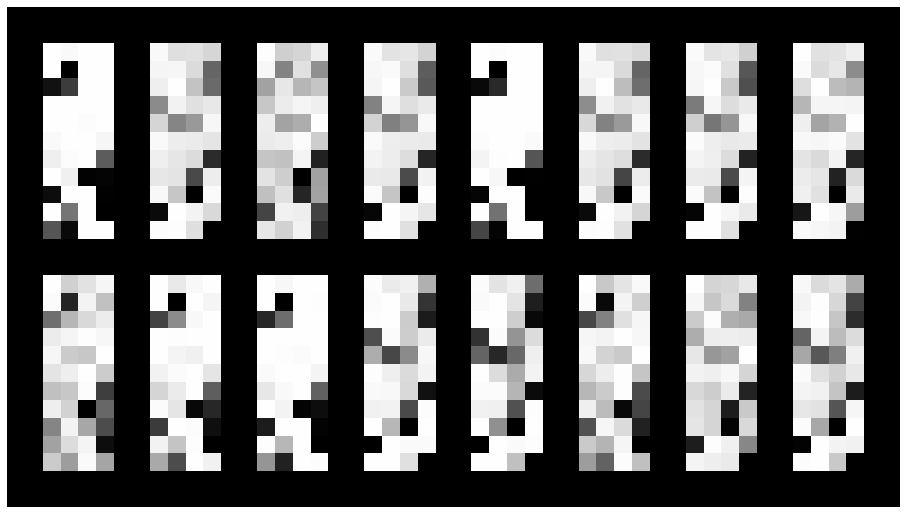

Epoch: [96/200], Batch Num: [0/10]
Discriminator Loss: 0.5280, Generator Loss: 4.5895
D(x): 0.8718, D(G(z)): 0.1479


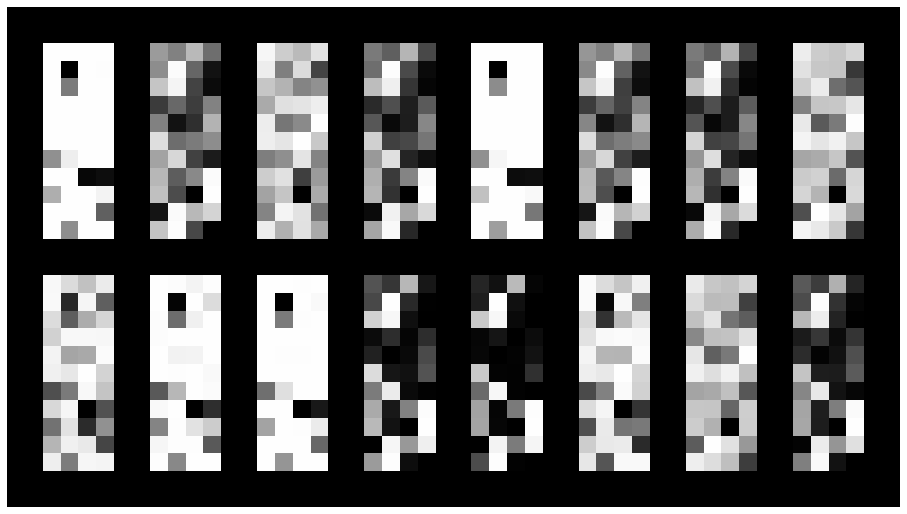

Epoch: [97/200], Batch Num: [0/10]
Discriminator Loss: 1.0623, Generator Loss: 2.9867
D(x): 0.8335, D(G(z)): 0.3210


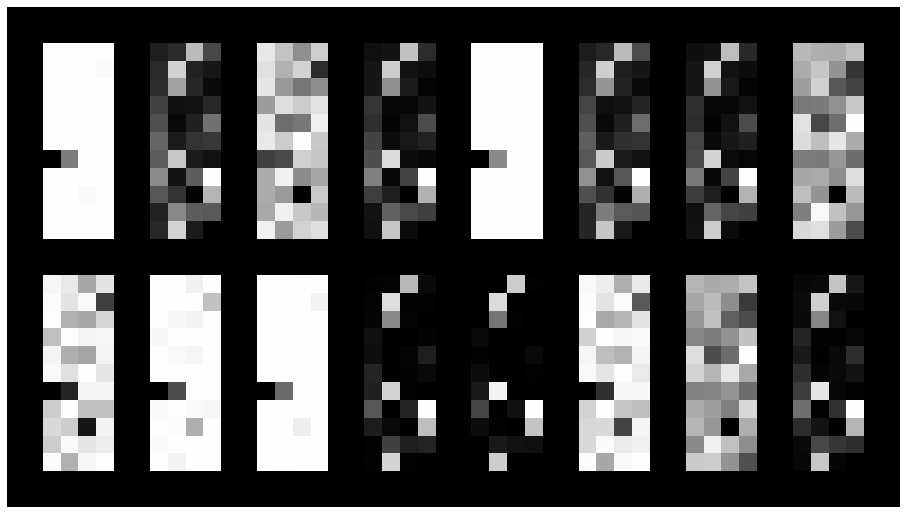

Epoch: [98/200], Batch Num: [0/10]
Discriminator Loss: 0.9903, Generator Loss: 3.1474
D(x): 0.7503, D(G(z)): 0.1966


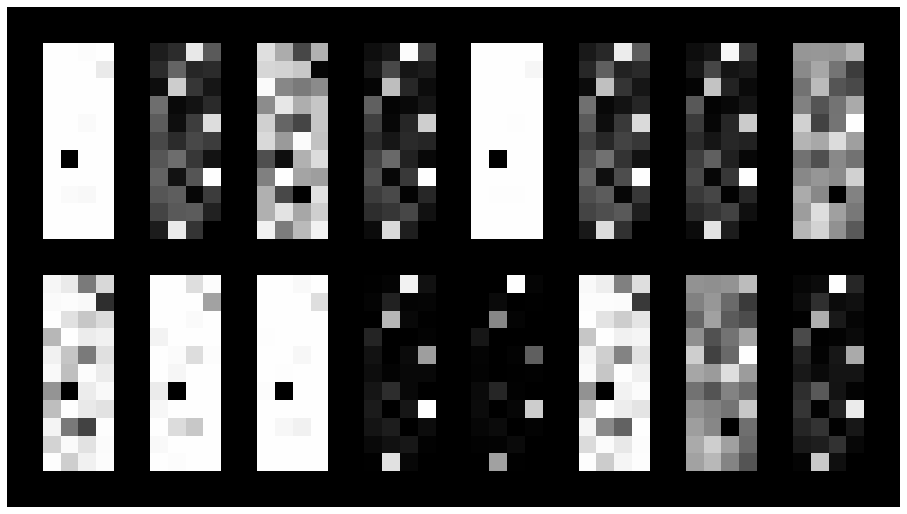

Epoch: [99/200], Batch Num: [0/10]
Discriminator Loss: 1.0155, Generator Loss: 1.8951
D(x): 0.6648, D(G(z)): 0.2339


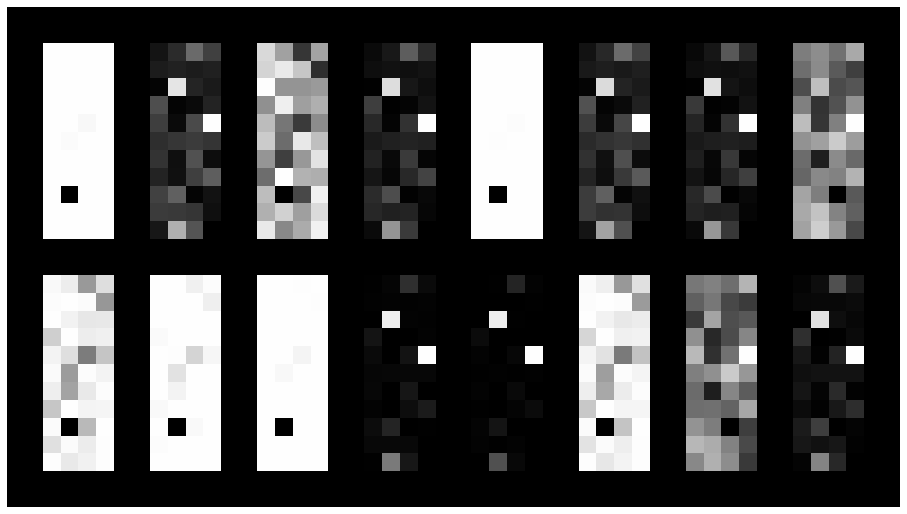

Epoch: [100/200], Batch Num: [0/10]
Discriminator Loss: 1.1669, Generator Loss: 1.3287
D(x): 0.6348, D(G(z)): 0.3571


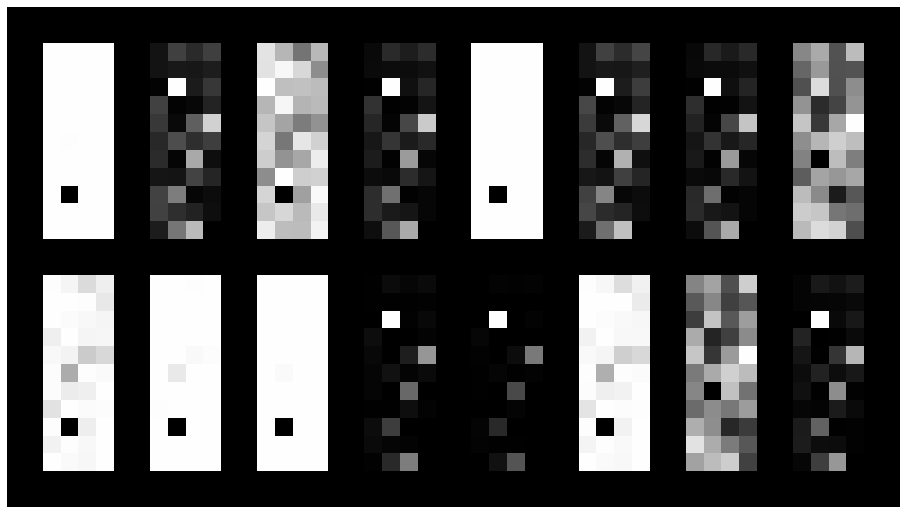

Epoch: [101/200], Batch Num: [0/10]
Discriminator Loss: 1.0554, Generator Loss: 1.2119
D(x): 0.6771, D(G(z)): 0.3832


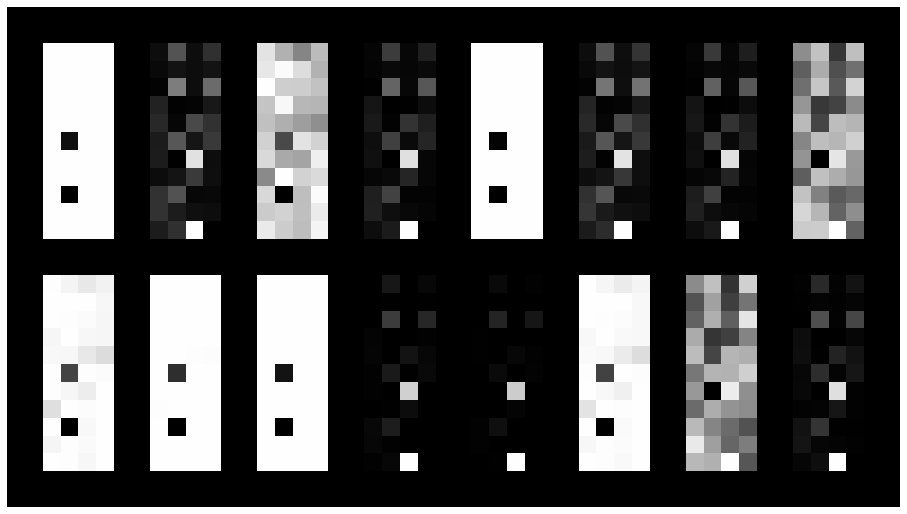

Epoch: [102/200], Batch Num: [0/10]
Discriminator Loss: 0.9587, Generator Loss: 1.4299
D(x): 0.7100, D(G(z)): 0.3342


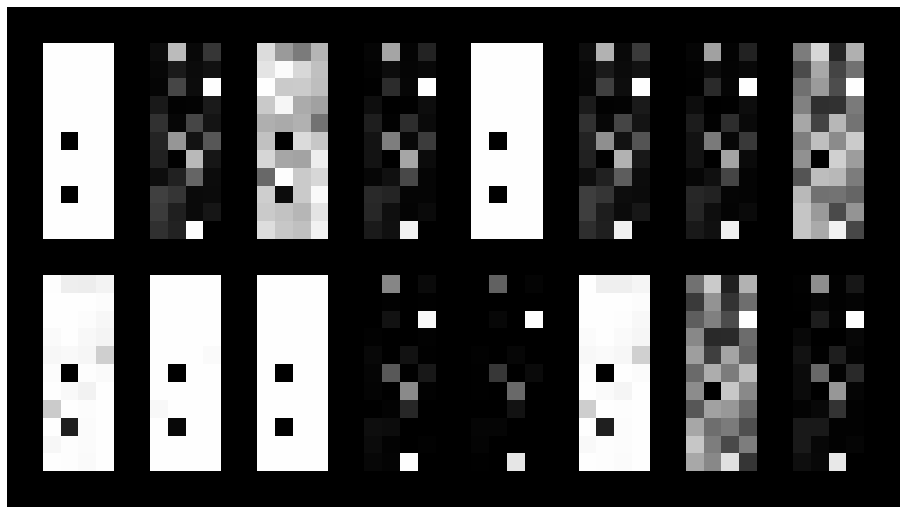

Epoch: [103/200], Batch Num: [0/10]
Discriminator Loss: 0.5985, Generator Loss: 2.4221
D(x): 0.7720, D(G(z)): 0.1953


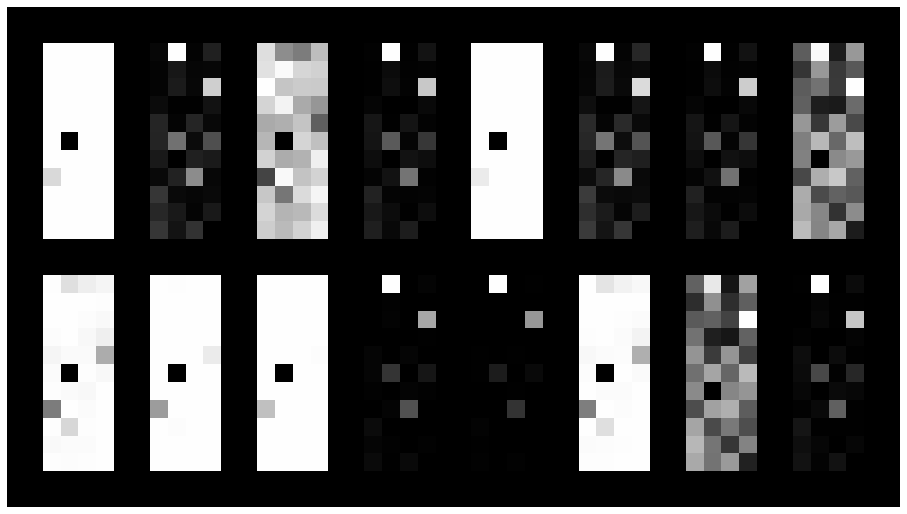

Epoch: [104/200], Batch Num: [0/10]
Discriminator Loss: 0.7948, Generator Loss: 1.8436
D(x): 0.7718, D(G(z)): 0.3196


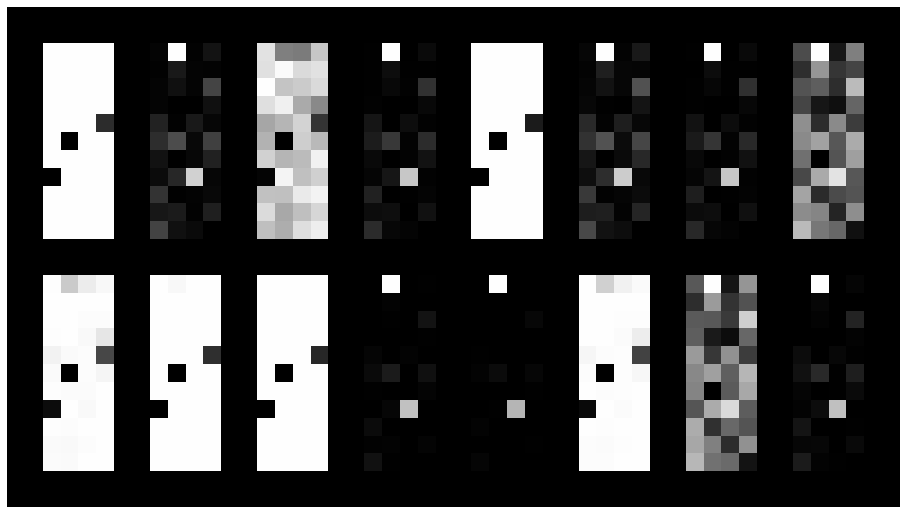

Epoch: [105/200], Batch Num: [0/10]
Discriminator Loss: 0.5106, Generator Loss: 2.3234
D(x): 0.8341, D(G(z)): 0.2046


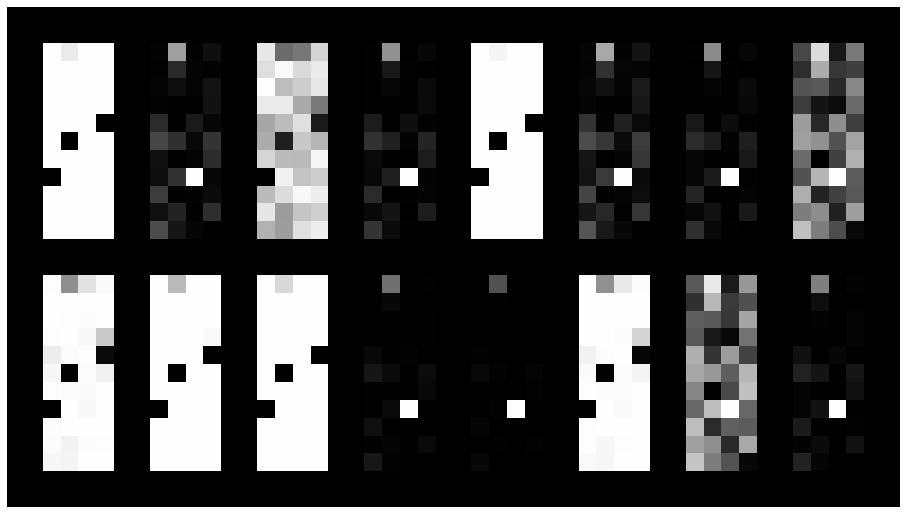

Epoch: [106/200], Batch Num: [0/10]
Discriminator Loss: 0.2878, Generator Loss: 3.4984
D(x): 0.8727, D(G(z)): 0.0969


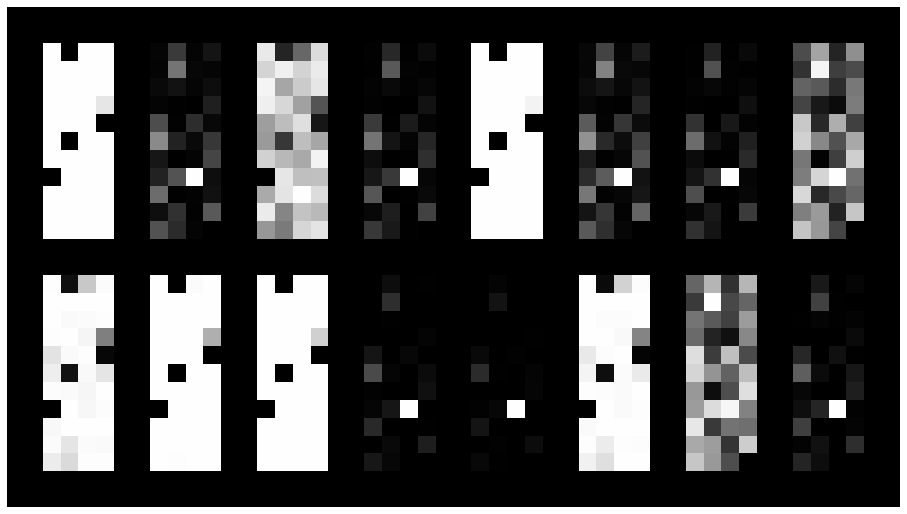

Epoch: [107/200], Batch Num: [0/10]
Discriminator Loss: 0.3250, Generator Loss: 3.4606
D(x): 0.8606, D(G(z)): 0.1142


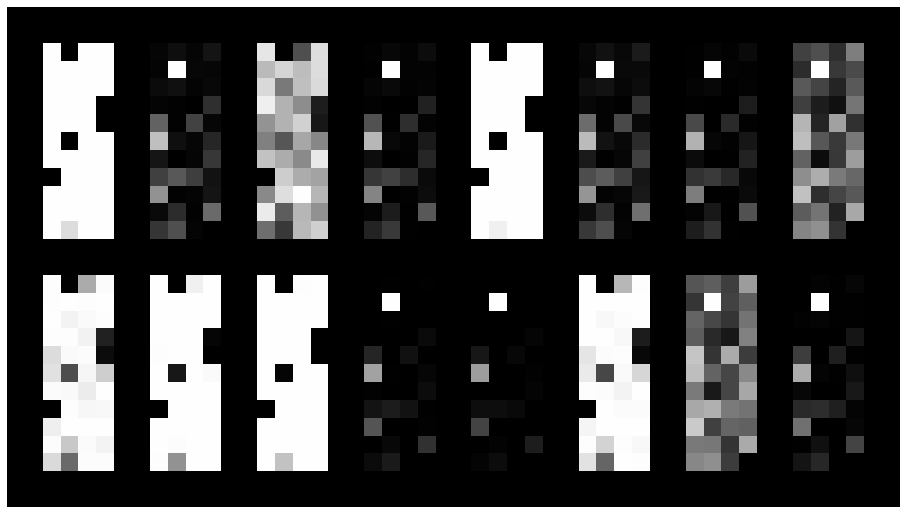

Epoch: [108/200], Batch Num: [0/10]
Discriminator Loss: 0.4920, Generator Loss: 3.5570
D(x): 0.8262, D(G(z)): 0.1590


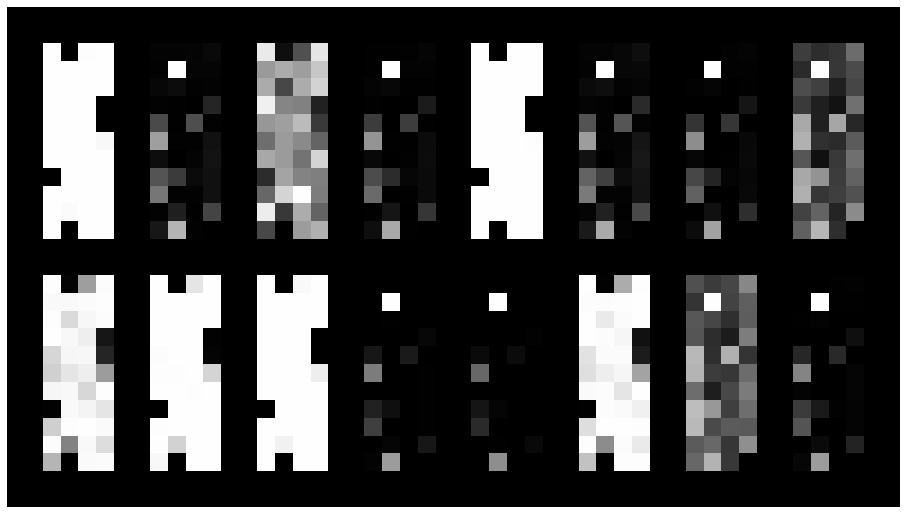

Epoch: [109/200], Batch Num: [0/10]
Discriminator Loss: 0.4309, Generator Loss: 3.3407
D(x): 0.8282, D(G(z)): 0.1320


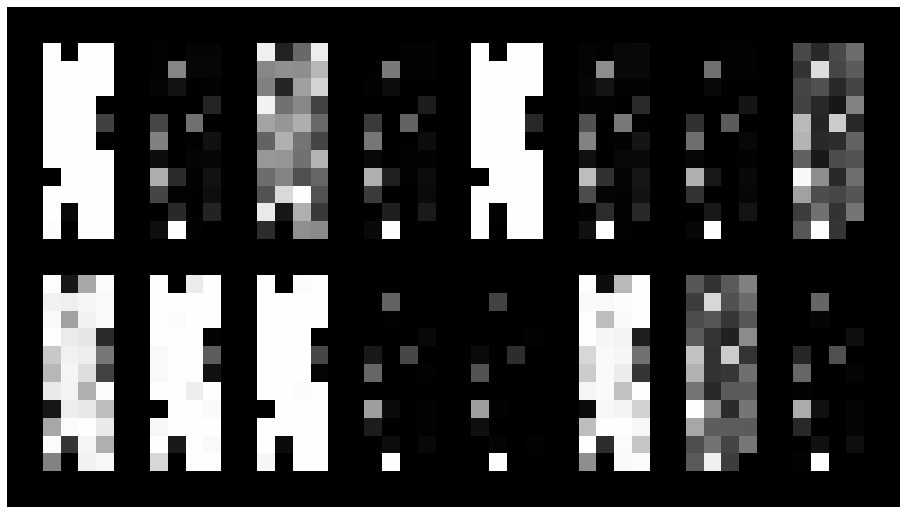

Epoch: [110/200], Batch Num: [0/10]
Discriminator Loss: 0.3422, Generator Loss: 3.6976
D(x): 0.8722, D(G(z)): 0.1239


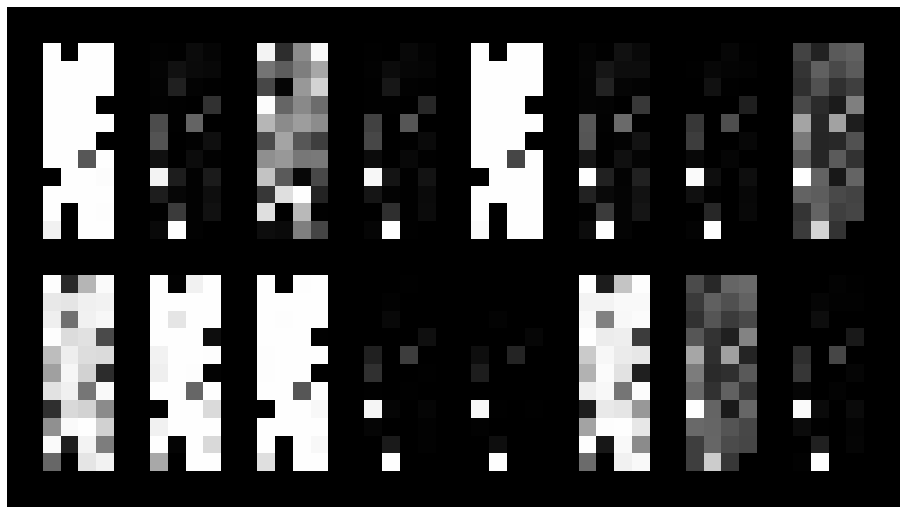

Epoch: [111/200], Batch Num: [0/10]
Discriminator Loss: 0.2526, Generator Loss: 3.8645
D(x): 0.9130, D(G(z)): 0.1090


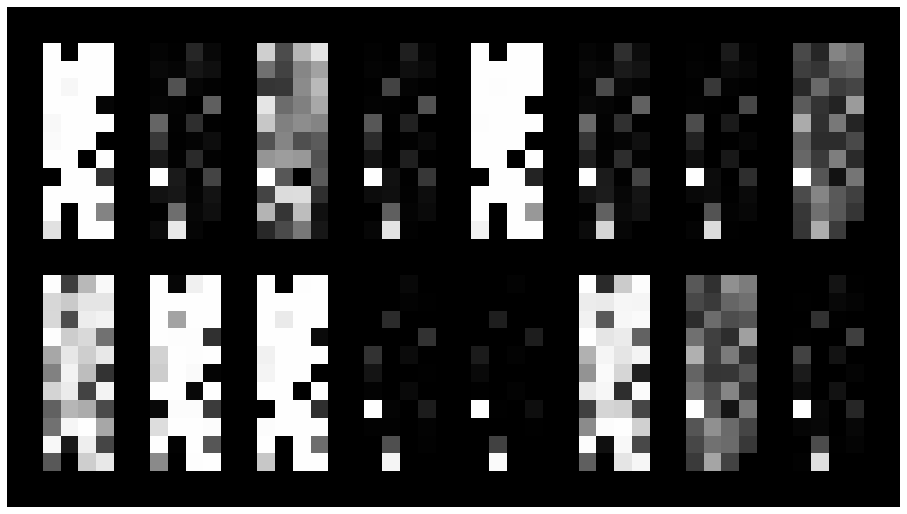

Epoch: [112/200], Batch Num: [0/10]
Discriminator Loss: 0.2120, Generator Loss: 4.2113
D(x): 0.9363, D(G(z)): 0.0950


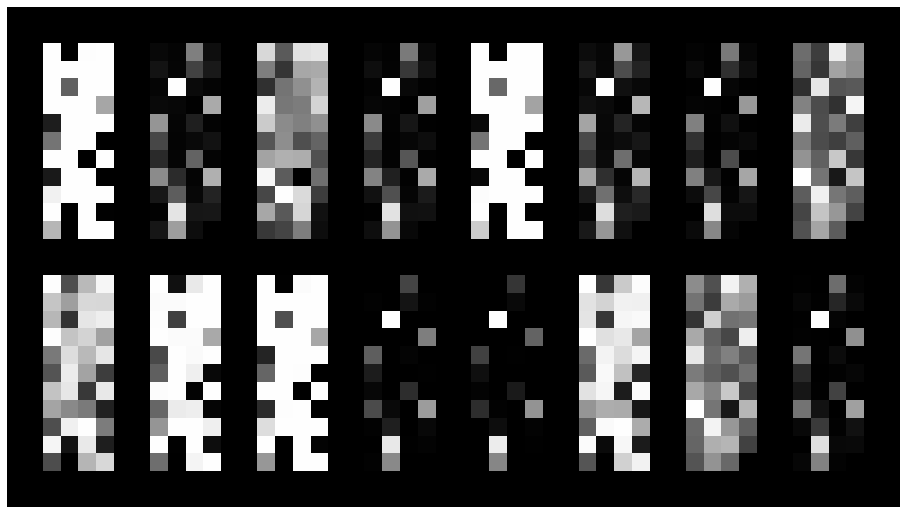

Epoch: [113/200], Batch Num: [0/10]
Discriminator Loss: 0.5193, Generator Loss: 2.7720
D(x): 0.8678, D(G(z)): 0.2031


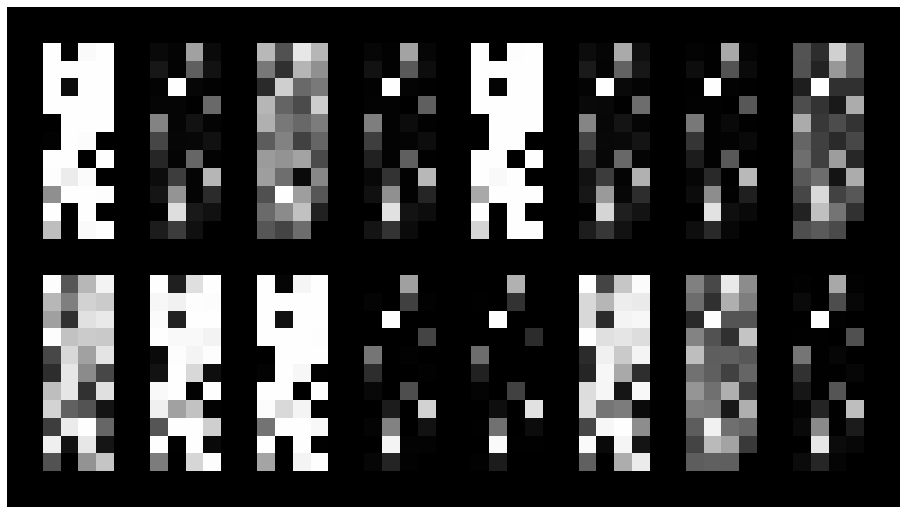

Epoch: [114/200], Batch Num: [0/10]
Discriminator Loss: 0.4034, Generator Loss: 4.3967
D(x): 0.8337, D(G(z)): 0.0740


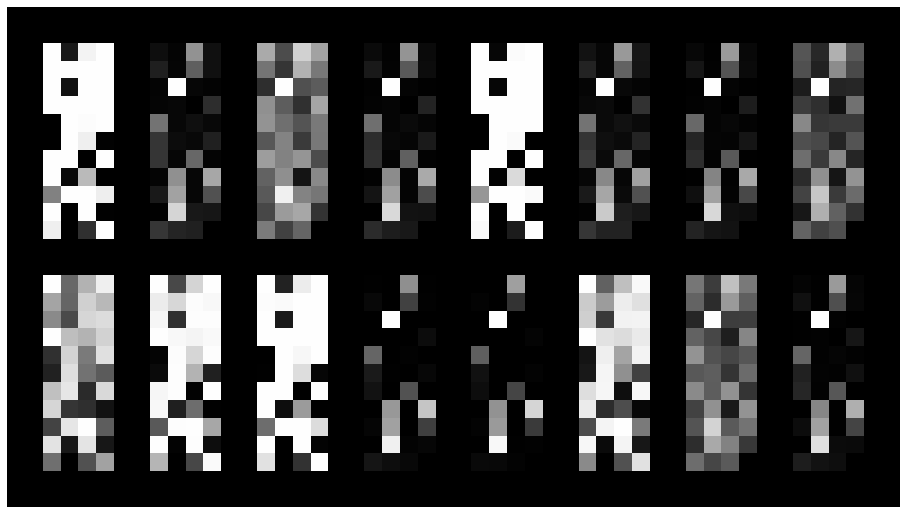

Epoch: [115/200], Batch Num: [0/10]
Discriminator Loss: 0.2402, Generator Loss: 3.5193
D(x): 0.9254, D(G(z)): 0.0967


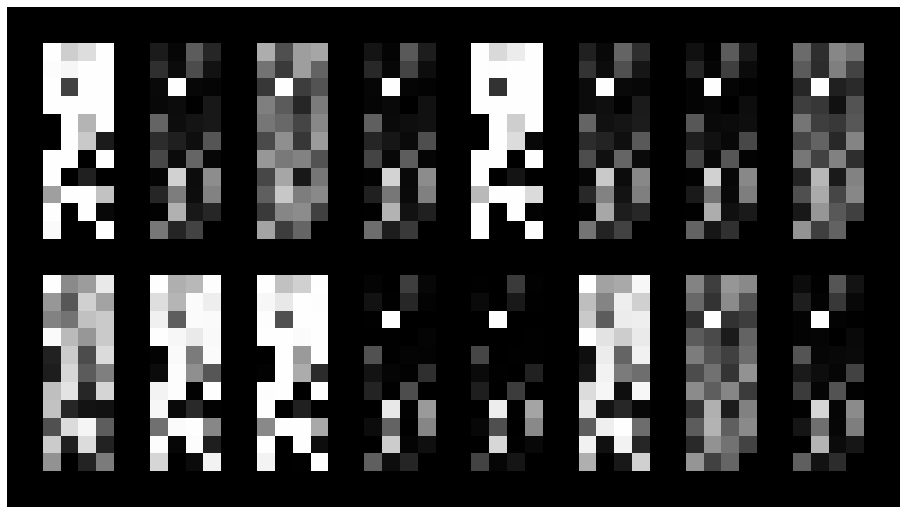

Epoch: [116/200], Batch Num: [0/10]
Discriminator Loss: 0.2515, Generator Loss: 3.8882
D(x): 0.9189, D(G(z)): 0.0890


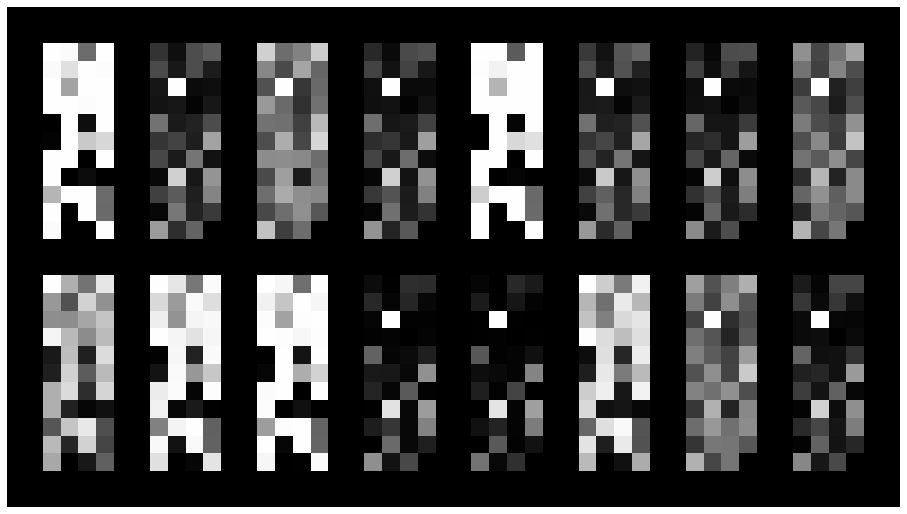

Epoch: [117/200], Batch Num: [0/10]
Discriminator Loss: 0.2895, Generator Loss: 3.5347
D(x): 0.9268, D(G(z)): 0.1127


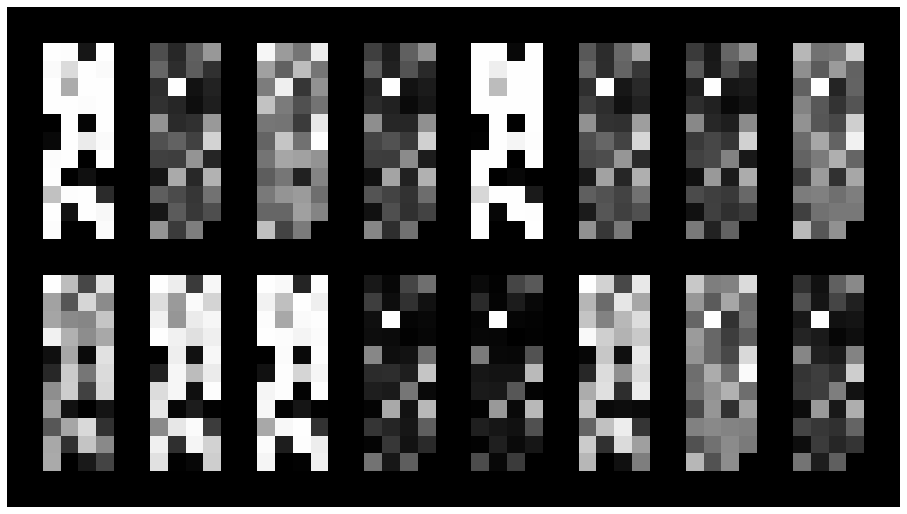

Epoch: [118/200], Batch Num: [0/10]
Discriminator Loss: 0.2447, Generator Loss: 4.2922
D(x): 0.9274, D(G(z)): 0.0824


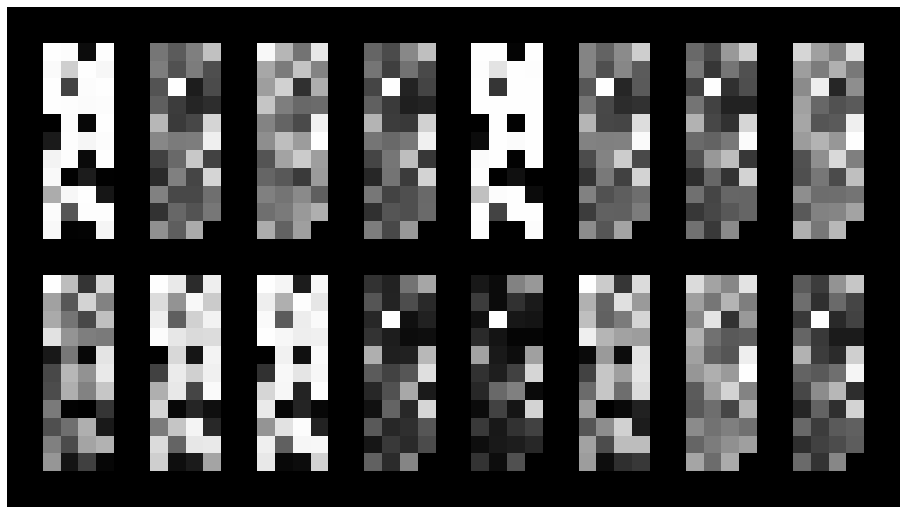

Epoch: [119/200], Batch Num: [0/10]
Discriminator Loss: 0.3073, Generator Loss: 3.6795
D(x): 0.9137, D(G(z)): 0.1084


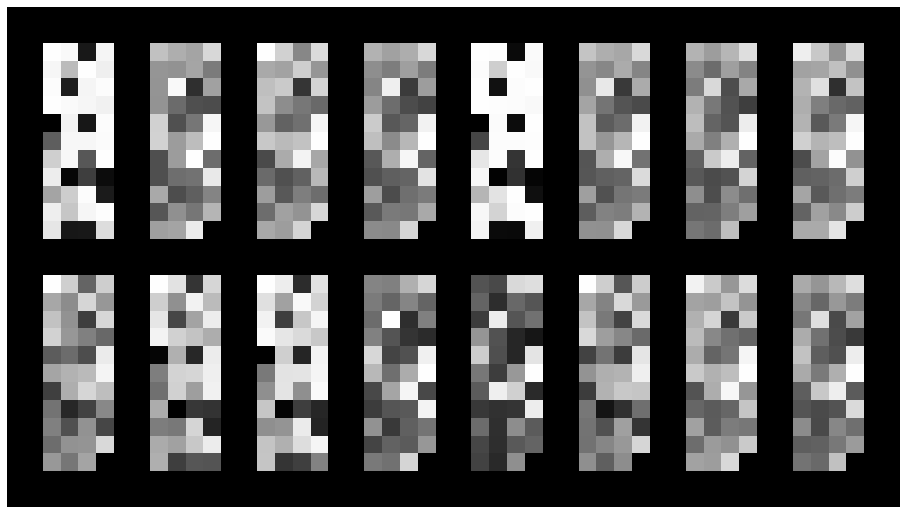

Epoch: [120/200], Batch Num: [0/10]
Discriminator Loss: 0.3383, Generator Loss: 3.2474
D(x): 0.9213, D(G(z)): 0.1530


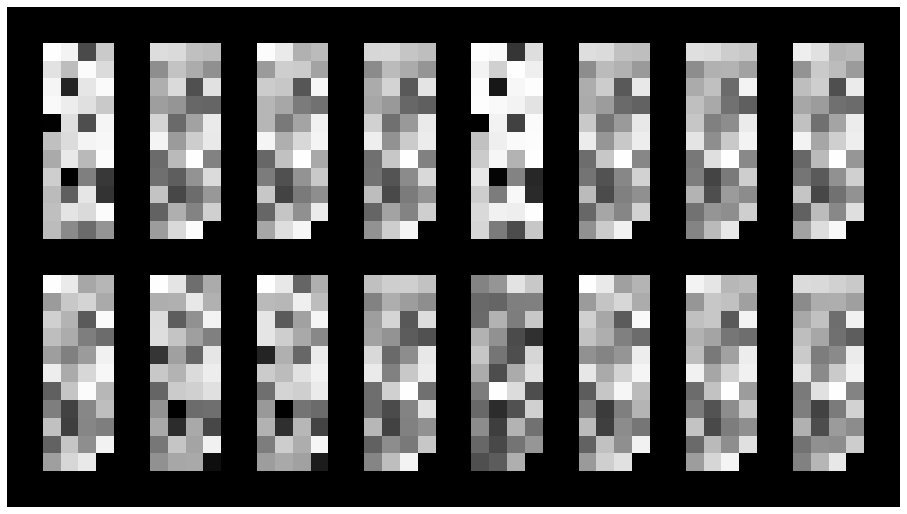

Epoch: [121/200], Batch Num: [0/10]
Discriminator Loss: 0.4693, Generator Loss: 3.0429
D(x): 0.8746, D(G(z)): 0.1055


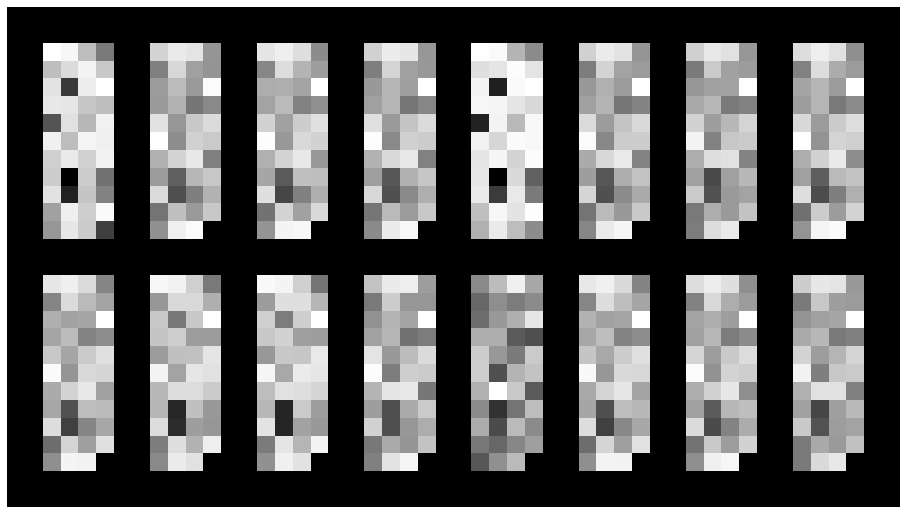

Epoch: [122/200], Batch Num: [0/10]
Discriminator Loss: 0.5903, Generator Loss: 3.1827
D(x): 0.8459, D(G(z)): 0.1003


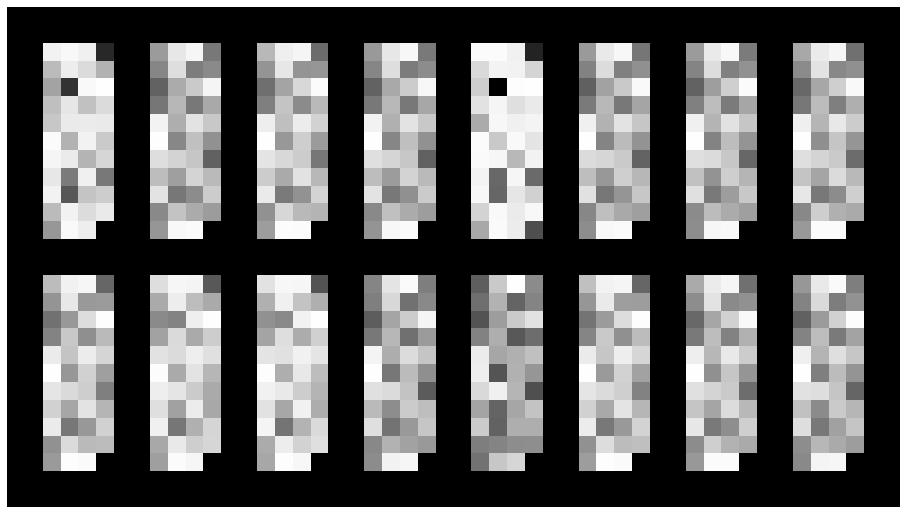

Epoch: [123/200], Batch Num: [0/10]
Discriminator Loss: 0.7436, Generator Loss: 2.8433
D(x): 0.8268, D(G(z)): 0.1568


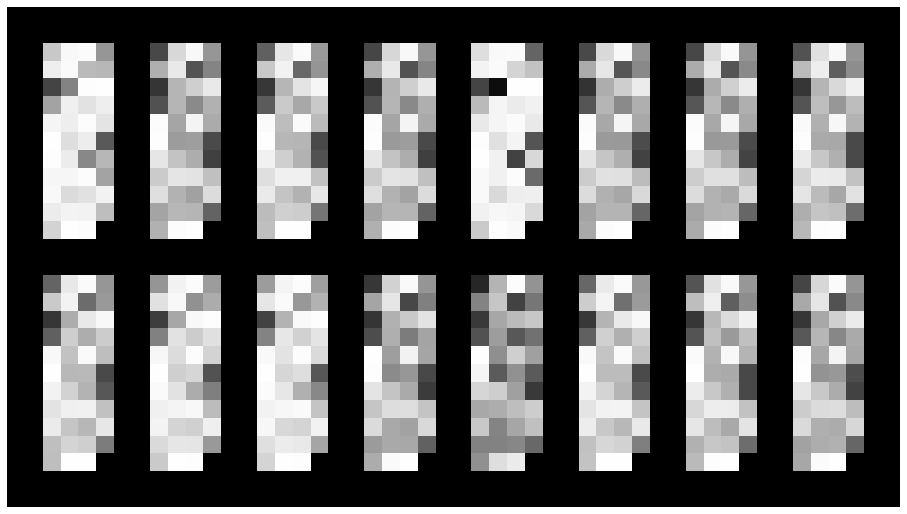

Epoch: [124/200], Batch Num: [0/10]
Discriminator Loss: 0.6134, Generator Loss: 3.0442
D(x): 0.8269, D(G(z)): 0.1185


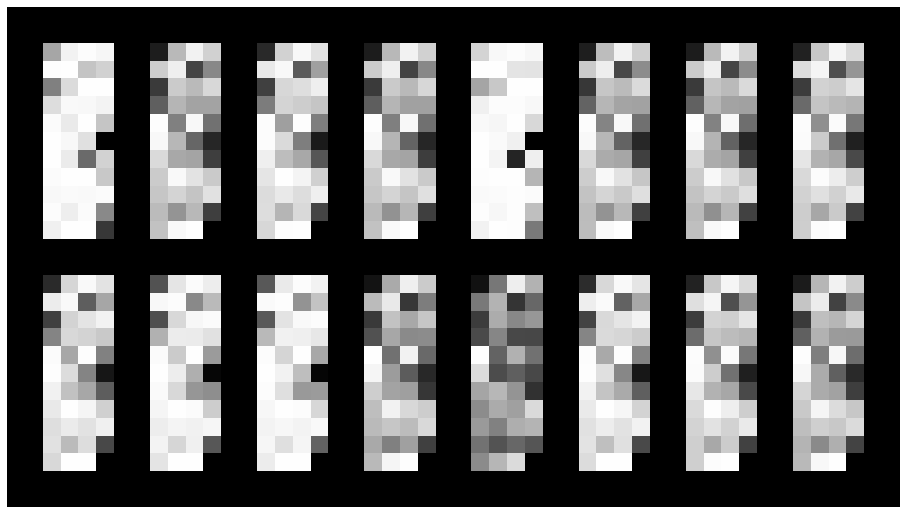

Epoch: [125/200], Batch Num: [0/10]
Discriminator Loss: 0.4116, Generator Loss: 3.3756
D(x): 0.8587, D(G(z)): 0.0849


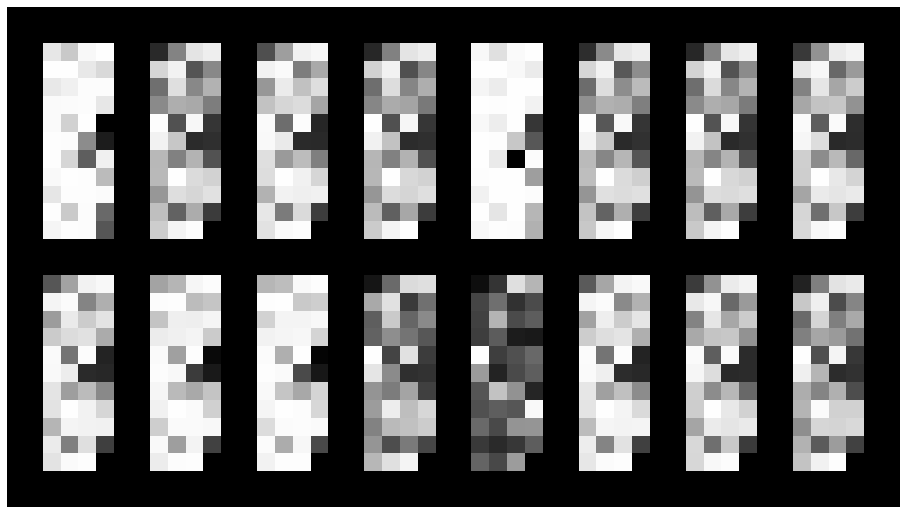

Epoch: [126/200], Batch Num: [0/10]
Discriminator Loss: 0.5603, Generator Loss: 2.8582
D(x): 0.8642, D(G(z)): 0.1438


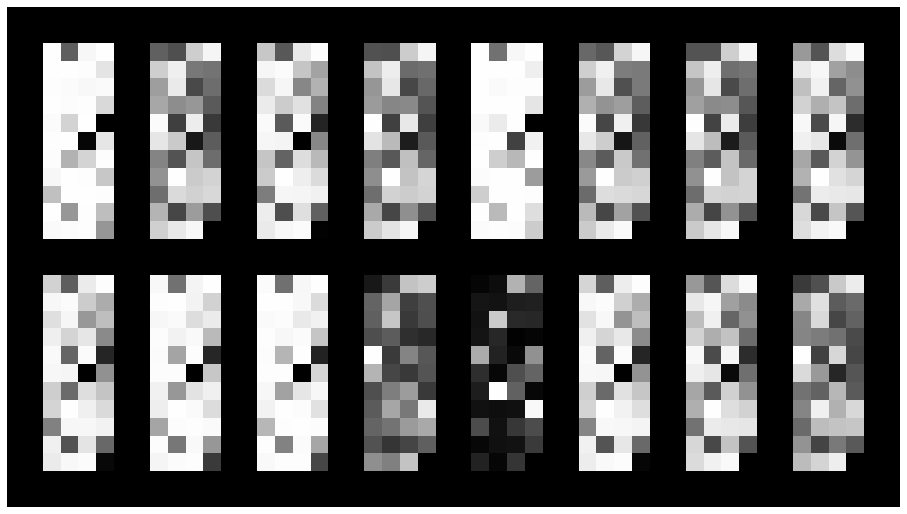

Epoch: [127/200], Batch Num: [0/10]
Discriminator Loss: 0.9483, Generator Loss: 2.6436
D(x): 0.8112, D(G(z)): 0.1669


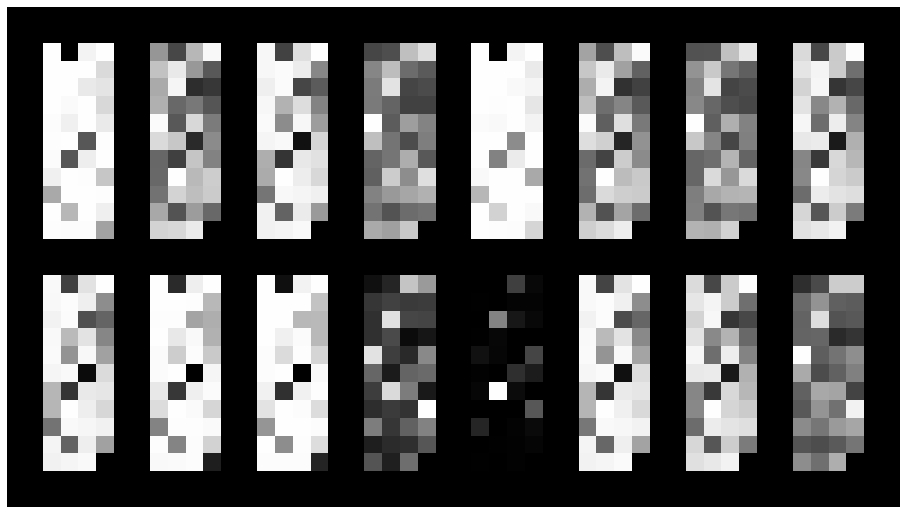

Epoch: [128/200], Batch Num: [0/10]
Discriminator Loss: 0.9266, Generator Loss: 2.3662
D(x): 0.8089, D(G(z)): 0.1978


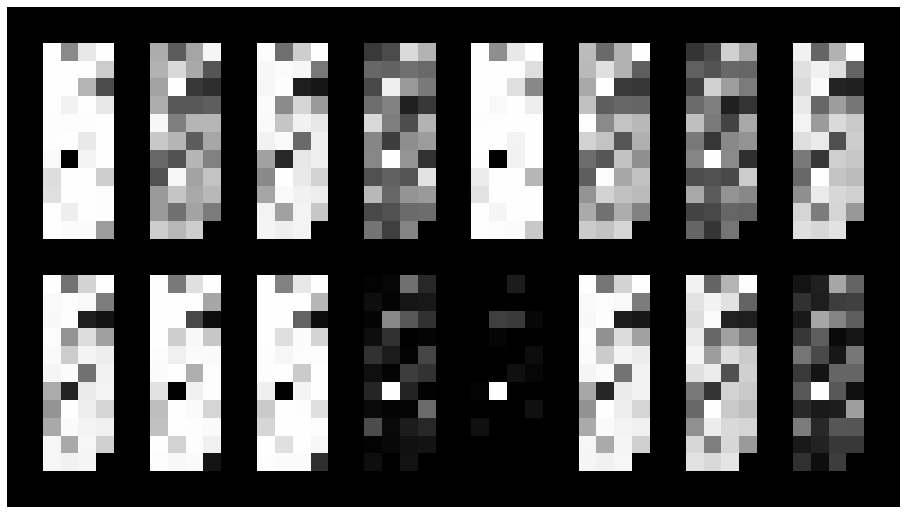

Epoch: [129/200], Batch Num: [0/10]
Discriminator Loss: 0.7408, Generator Loss: 2.1892
D(x): 0.7664, D(G(z)): 0.1777


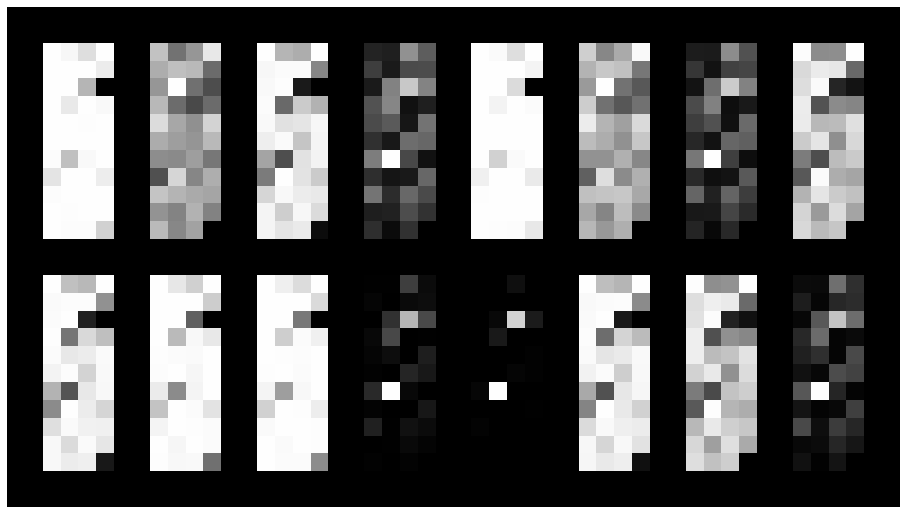

Epoch: [130/200], Batch Num: [0/10]
Discriminator Loss: 0.7920, Generator Loss: 1.8642
D(x): 0.7396, D(G(z)): 0.2167


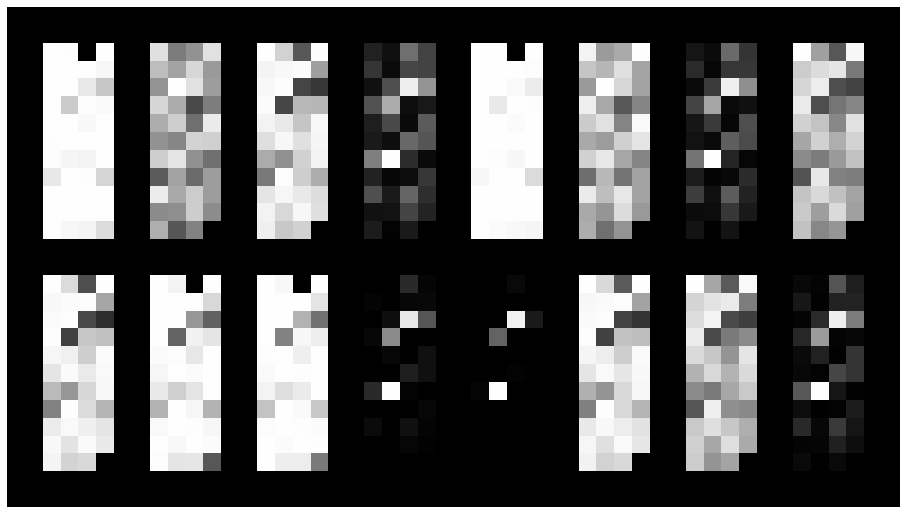

Epoch: [131/200], Batch Num: [0/10]
Discriminator Loss: 0.7470, Generator Loss: 1.6852
D(x): 0.7822, D(G(z)): 0.2655


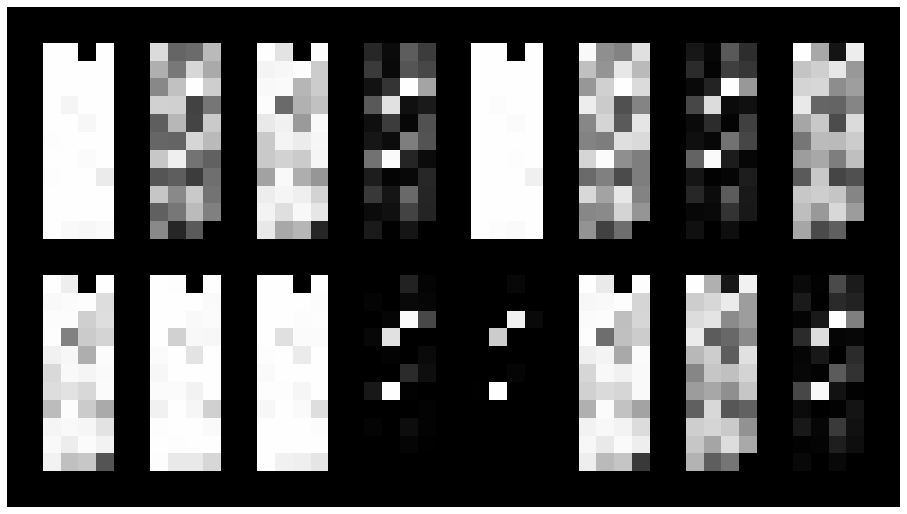

Epoch: [132/200], Batch Num: [0/10]
Discriminator Loss: 0.7543, Generator Loss: 1.7708
D(x): 0.7436, D(G(z)): 0.2383


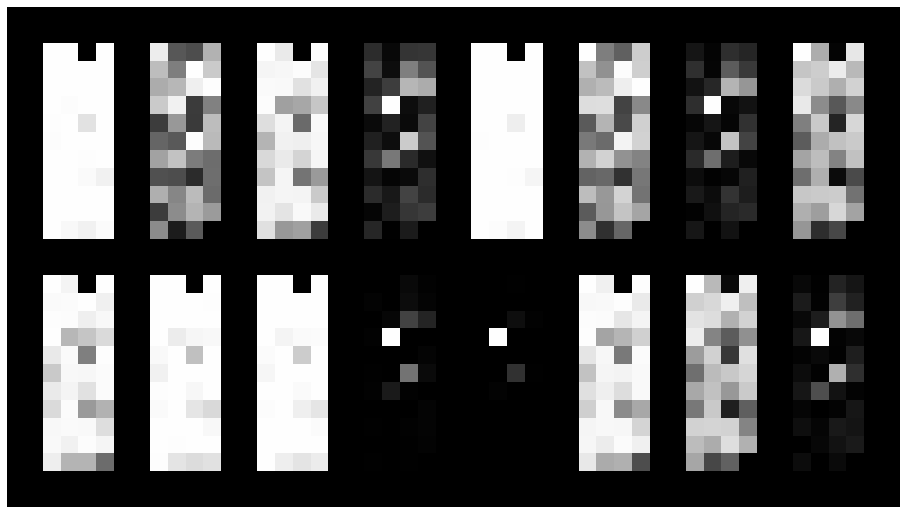

Epoch: [133/200], Batch Num: [0/10]
Discriminator Loss: 0.6038, Generator Loss: 1.8961
D(x): 0.8135, D(G(z)): 0.2437


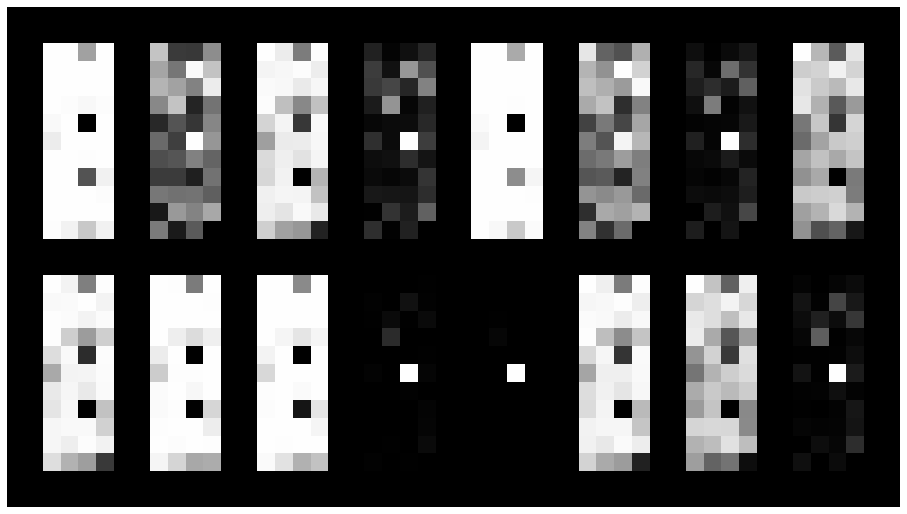

Epoch: [134/200], Batch Num: [0/10]
Discriminator Loss: 0.7565, Generator Loss: 1.8120
D(x): 0.7209, D(G(z)): 0.2410


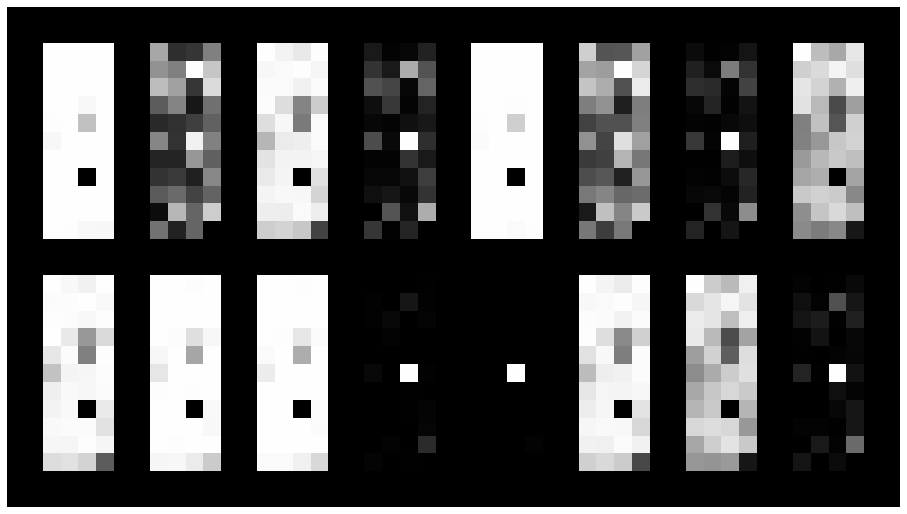

Epoch: [135/200], Batch Num: [0/10]
Discriminator Loss: 0.7141, Generator Loss: 1.8315
D(x): 0.7469, D(G(z)): 0.2306


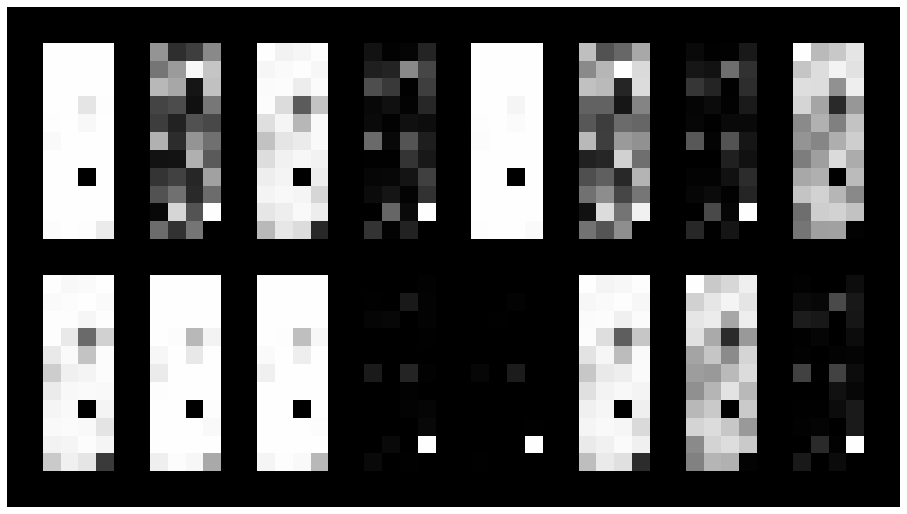

Epoch: [136/200], Batch Num: [0/10]
Discriminator Loss: 0.5513, Generator Loss: 2.0115
D(x): 0.8077, D(G(z)): 0.1921


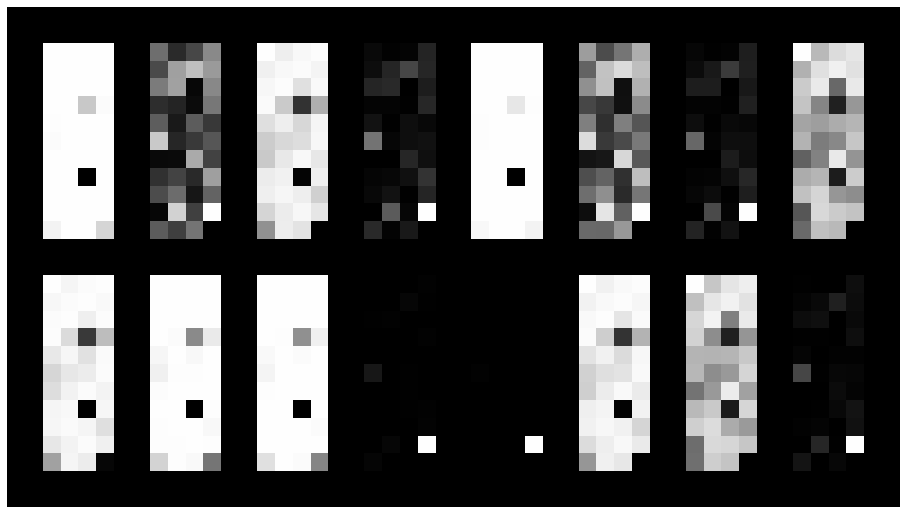

Epoch: [137/200], Batch Num: [0/10]
Discriminator Loss: 0.4605, Generator Loss: 2.5463
D(x): 0.8302, D(G(z)): 0.1502


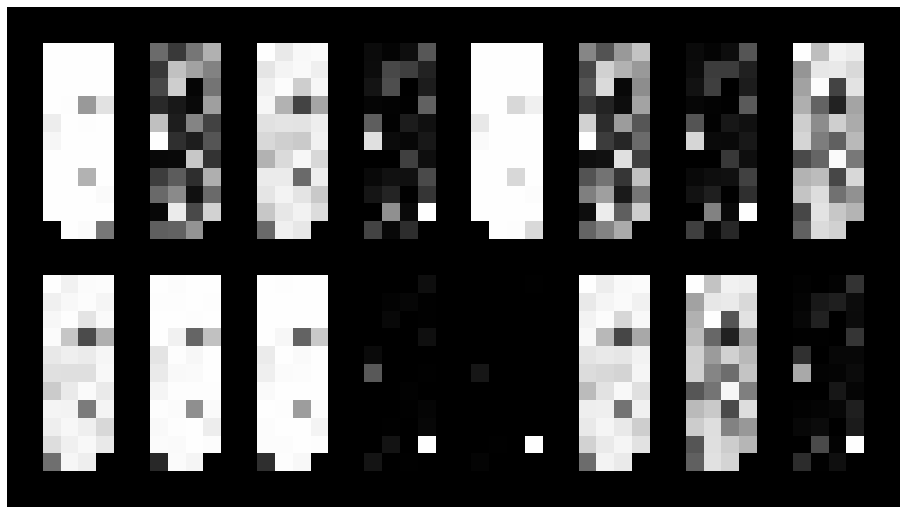

Epoch: [138/200], Batch Num: [0/10]
Discriminator Loss: 0.5200, Generator Loss: 2.5977
D(x): 0.8538, D(G(z)): 0.2025


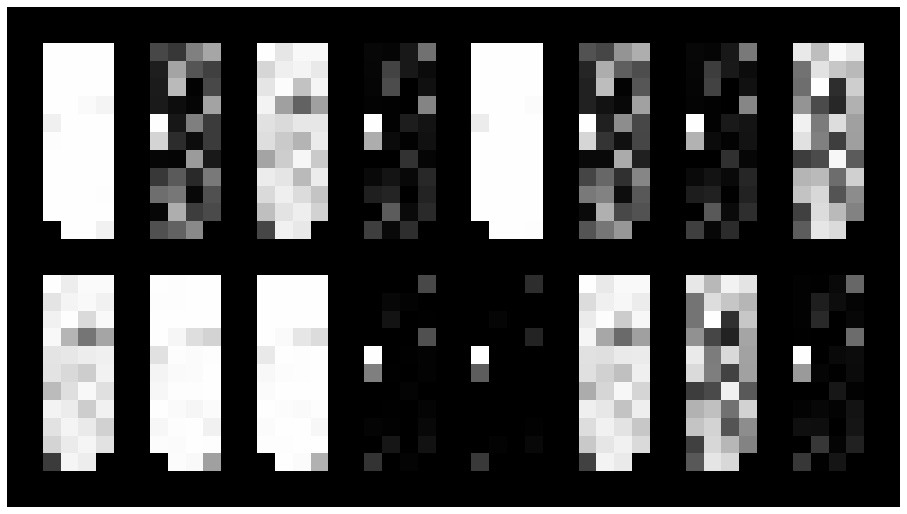

Epoch: [139/200], Batch Num: [0/10]
Discriminator Loss: 0.6769, Generator Loss: 1.7687
D(x): 0.7992, D(G(z)): 0.2531


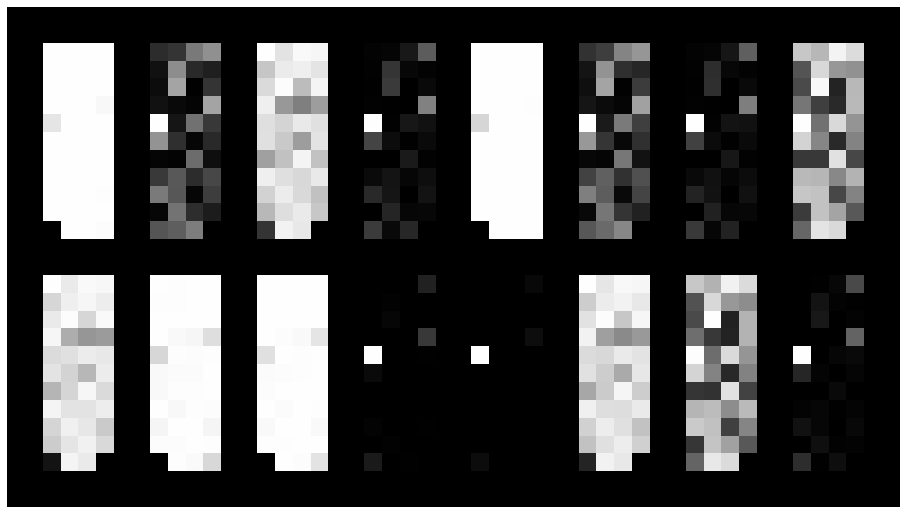

Epoch: [140/200], Batch Num: [0/10]
Discriminator Loss: 0.4232, Generator Loss: 2.2652
D(x): 0.8397, D(G(z)): 0.1466


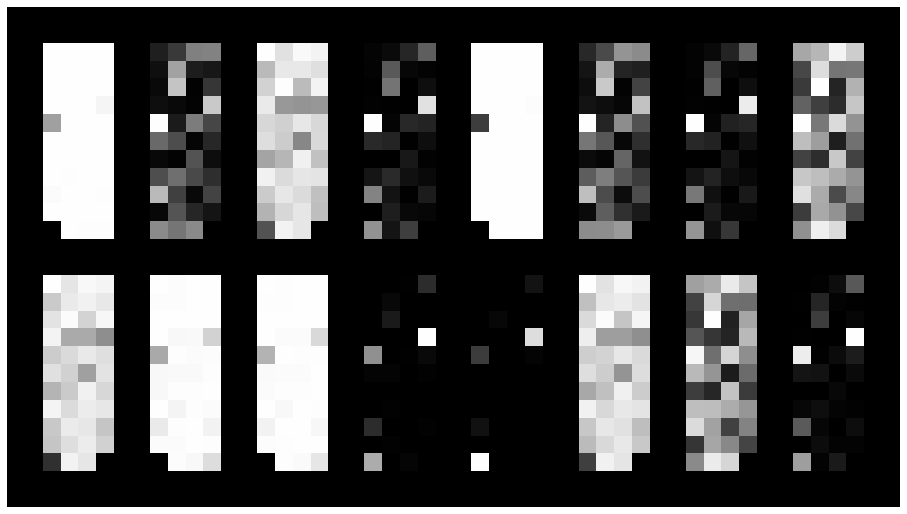

Epoch: [141/200], Batch Num: [0/10]
Discriminator Loss: 0.5039, Generator Loss: 2.1292
D(x): 0.8273, D(G(z)): 0.1851


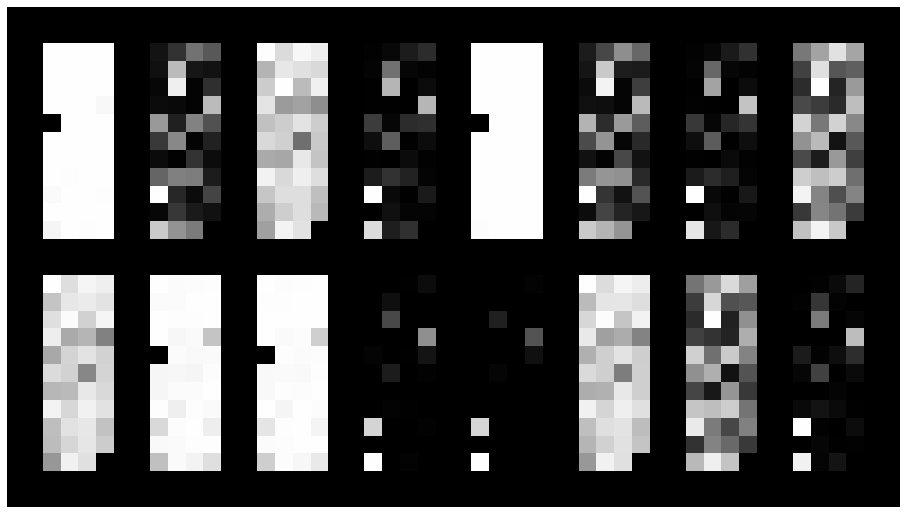

Epoch: [142/200], Batch Num: [0/10]
Discriminator Loss: 0.6506, Generator Loss: 2.1568
D(x): 0.7682, D(G(z)): 0.1926


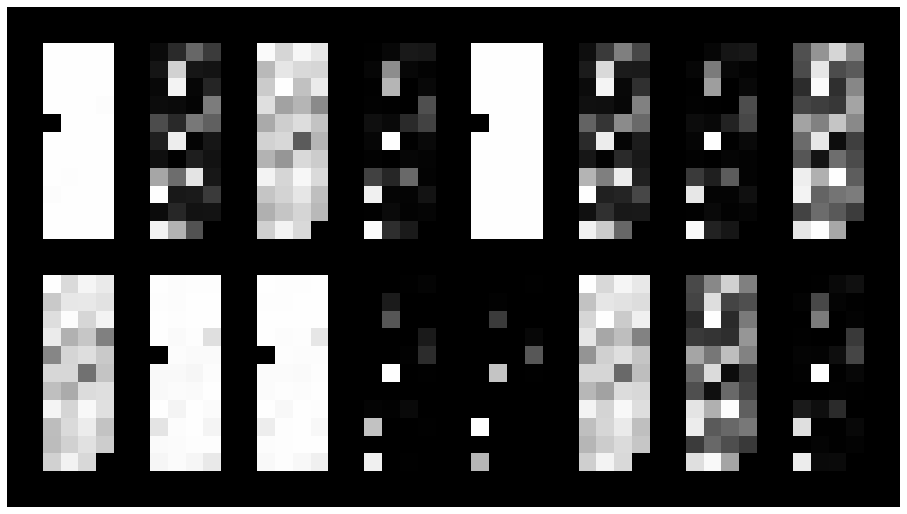

Epoch: [143/200], Batch Num: [0/10]
Discriminator Loss: 0.5669, Generator Loss: 2.4285
D(x): 0.7857, D(G(z)): 0.1704


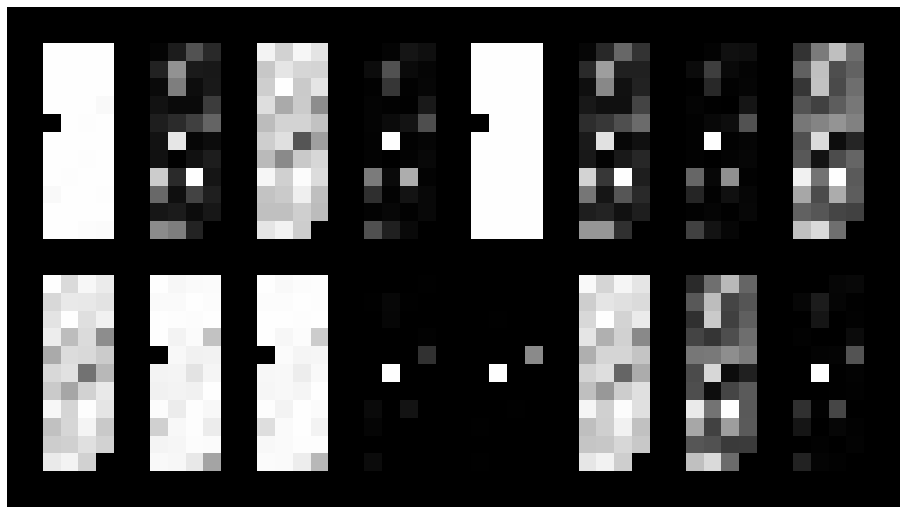

Epoch: [144/200], Batch Num: [0/10]
Discriminator Loss: 0.6182, Generator Loss: 2.1563
D(x): 0.7938, D(G(z)): 0.2031


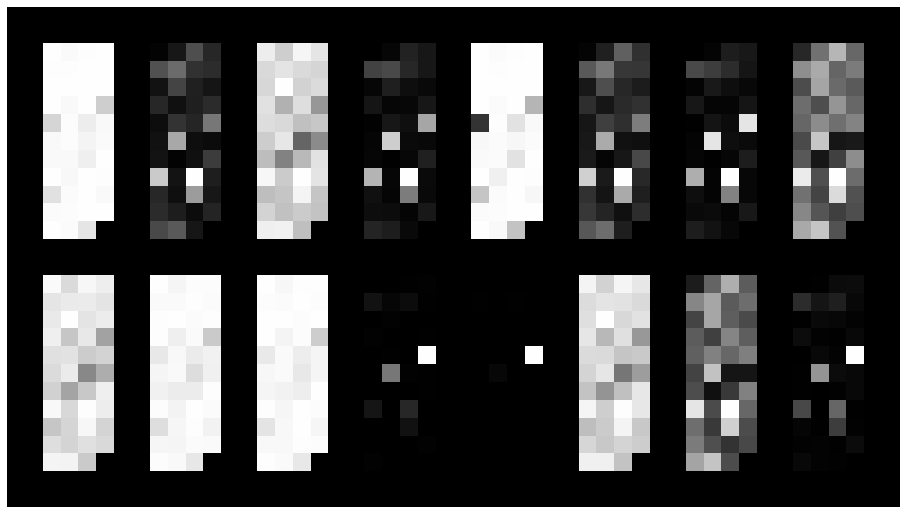

Epoch: [145/200], Batch Num: [0/10]
Discriminator Loss: 0.5375, Generator Loss: 2.1564
D(x): 0.8268, D(G(z)): 0.1940


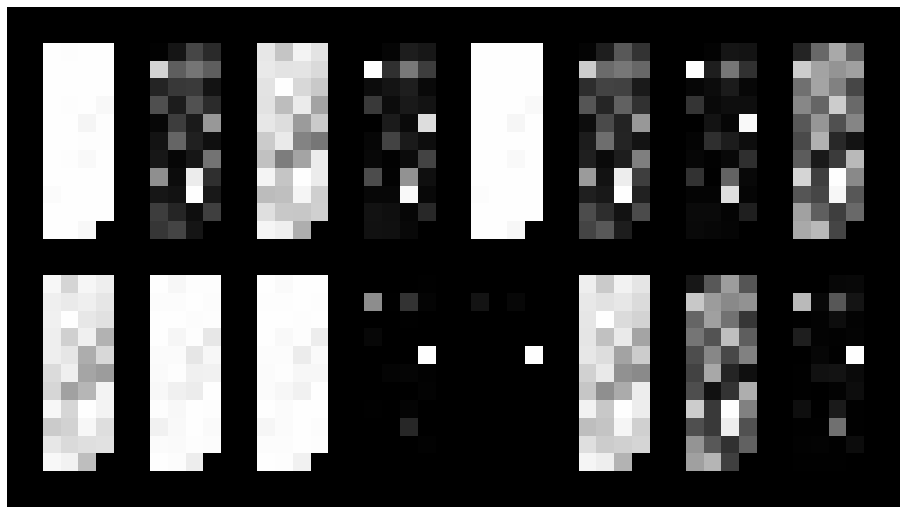

Epoch: [146/200], Batch Num: [0/10]
Discriminator Loss: 0.6220, Generator Loss: 2.0865
D(x): 0.7900, D(G(z)): 0.2128


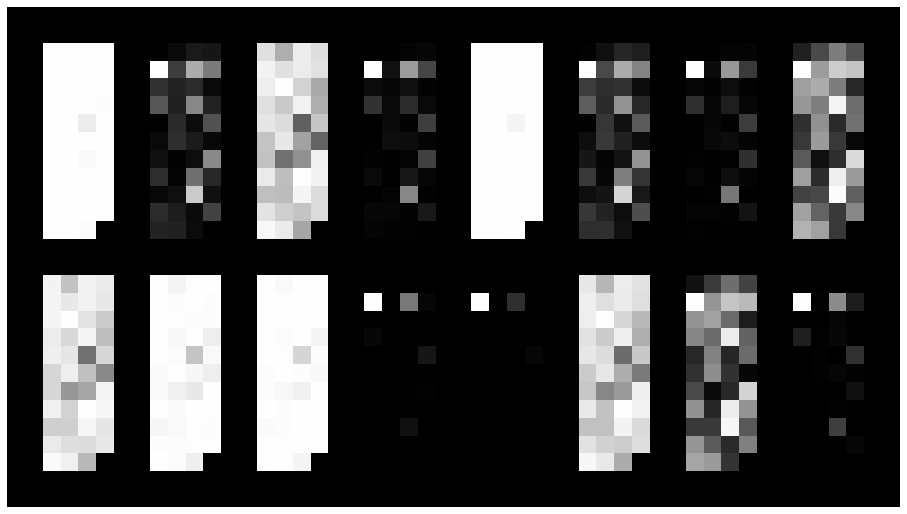

Epoch: [147/200], Batch Num: [0/10]
Discriminator Loss: 0.6541, Generator Loss: 2.3971
D(x): 0.7762, D(G(z)): 0.1799


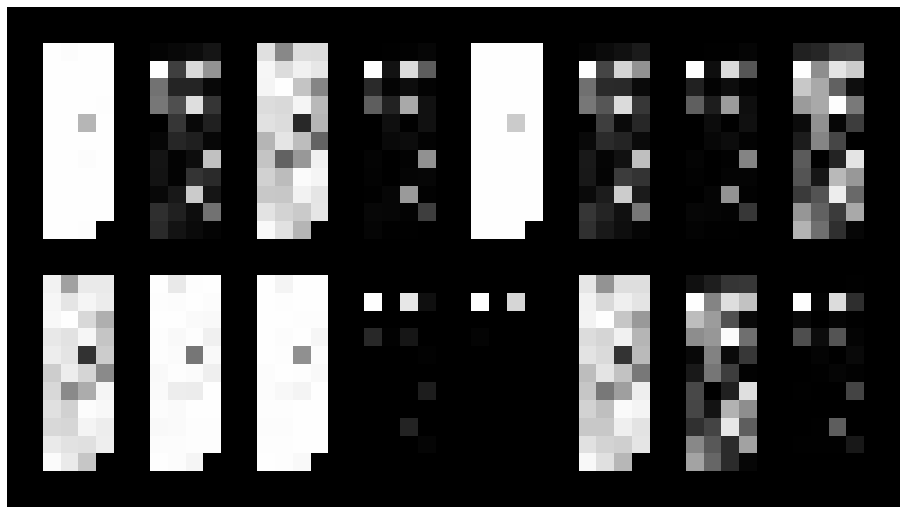

Epoch: [148/200], Batch Num: [0/10]
Discriminator Loss: 0.3239, Generator Loss: 3.3210
D(x): 0.8735, D(G(z)): 0.0732


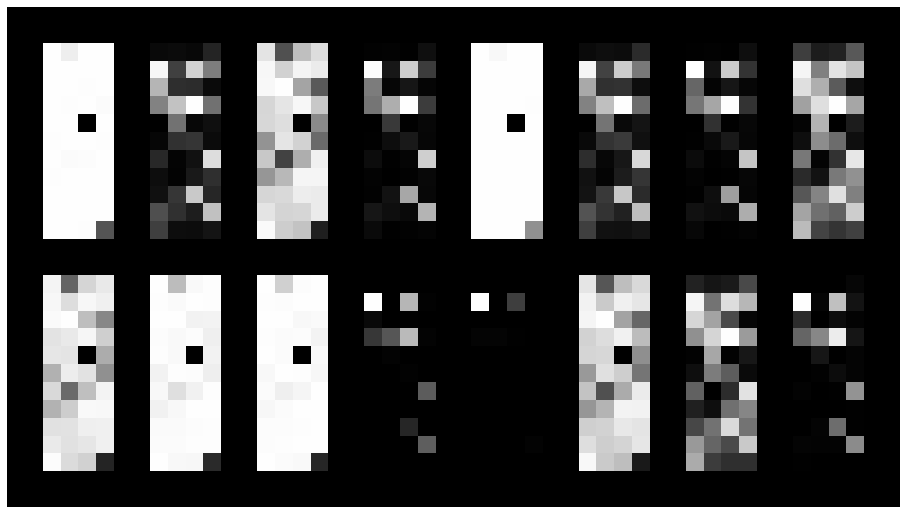

Epoch: [149/200], Batch Num: [0/10]
Discriminator Loss: 0.3455, Generator Loss: 3.3653
D(x): 0.8862, D(G(z)): 0.1128


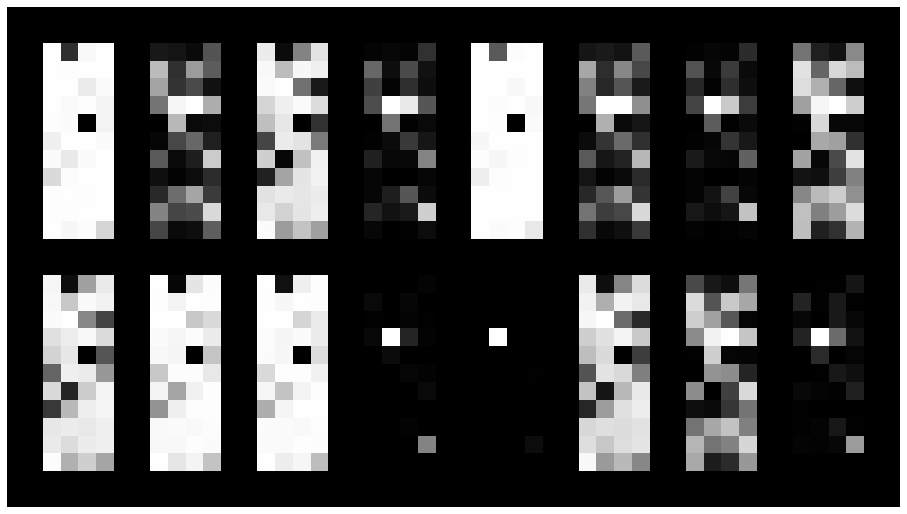

Epoch: [150/200], Batch Num: [0/10]
Discriminator Loss: 0.4954, Generator Loss: 3.4175
D(x): 0.8588, D(G(z)): 0.1380


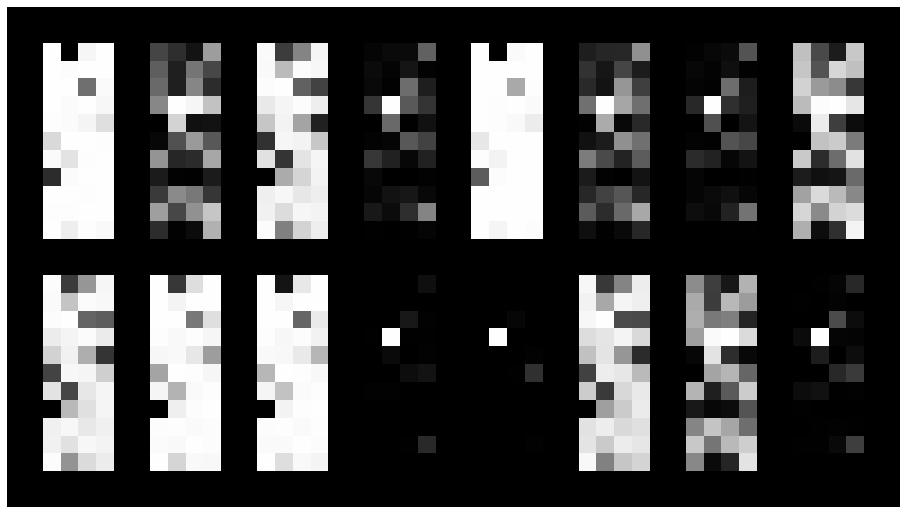

Epoch: [151/200], Batch Num: [0/10]
Discriminator Loss: 0.4636, Generator Loss: 2.4264
D(x): 0.8968, D(G(z)): 0.1579


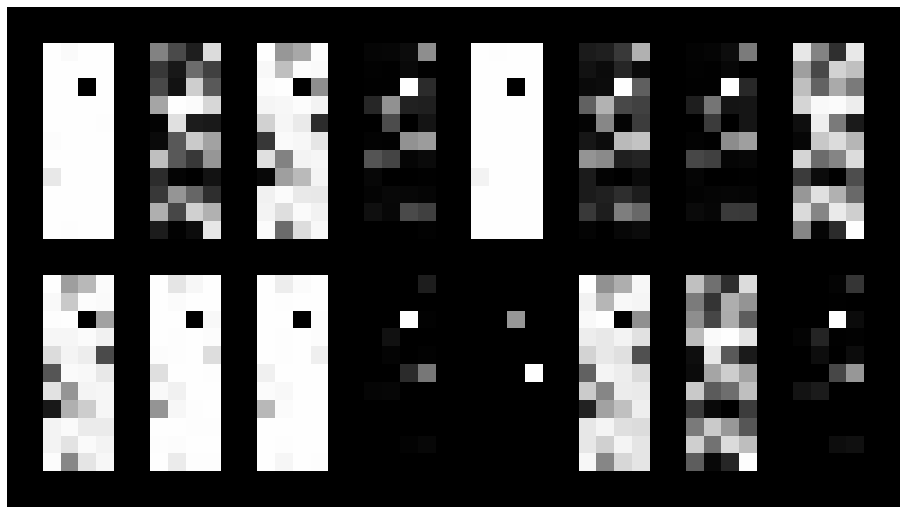

Epoch: [152/200], Batch Num: [0/10]
Discriminator Loss: 0.4471, Generator Loss: 2.9546
D(x): 0.8465, D(G(z)): 0.1141


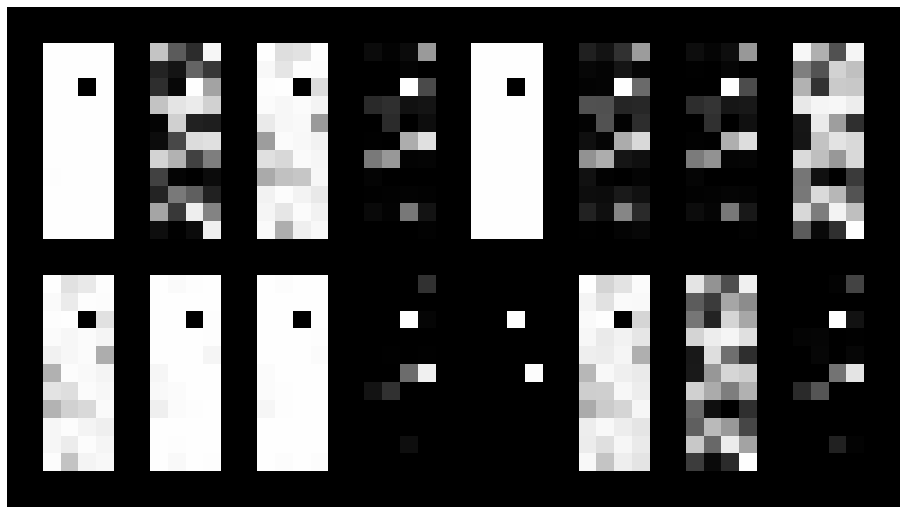

Epoch: [153/200], Batch Num: [0/10]
Discriminator Loss: 0.3569, Generator Loss: 3.2421
D(x): 0.8880, D(G(z)): 0.0805


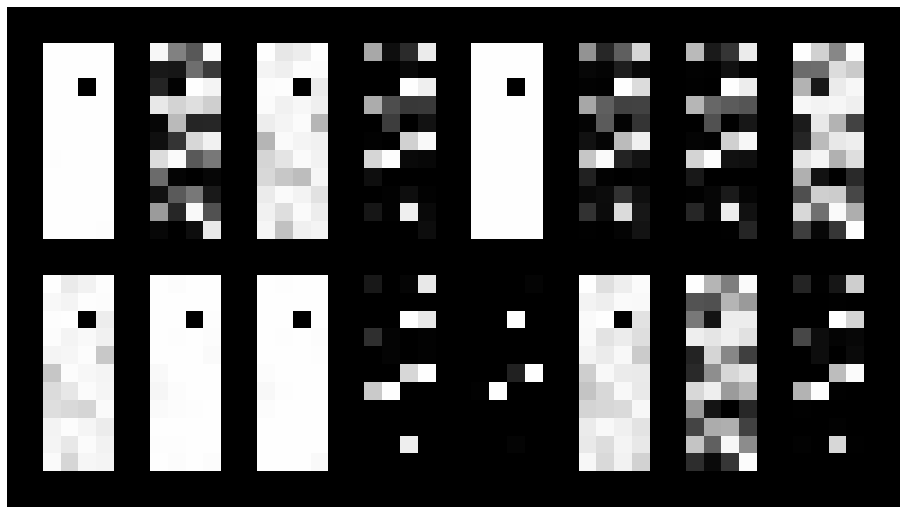

Epoch: [154/200], Batch Num: [0/10]
Discriminator Loss: 0.3271, Generator Loss: 3.8290
D(x): 0.9354, D(G(z)): 0.0756


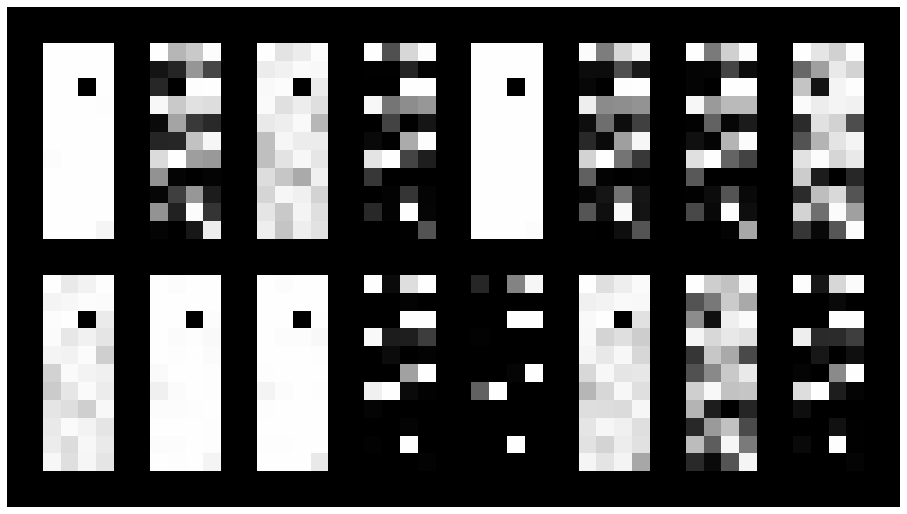

Epoch: [155/200], Batch Num: [0/10]
Discriminator Loss: 0.2028, Generator Loss: 4.3346
D(x): 0.9519, D(G(z)): 0.0574


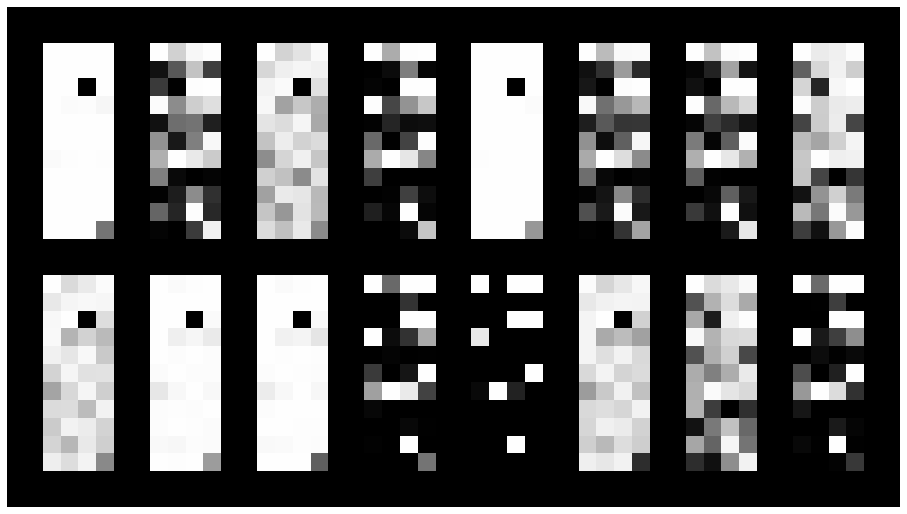

Epoch: [156/200], Batch Num: [0/10]
Discriminator Loss: 0.3682, Generator Loss: 3.8363
D(x): 0.9184, D(G(z)): 0.1067


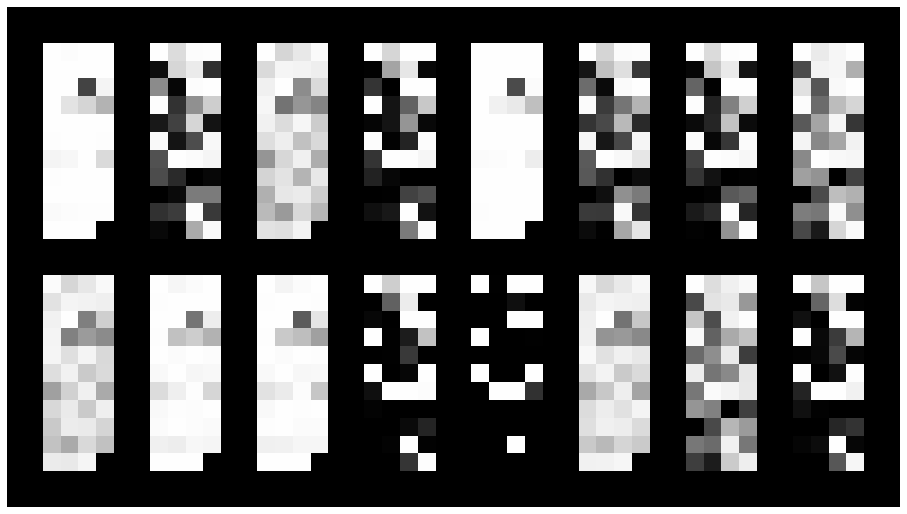

Epoch: [157/200], Batch Num: [0/10]
Discriminator Loss: 0.6370, Generator Loss: 3.2365
D(x): 0.8609, D(G(z)): 0.1599


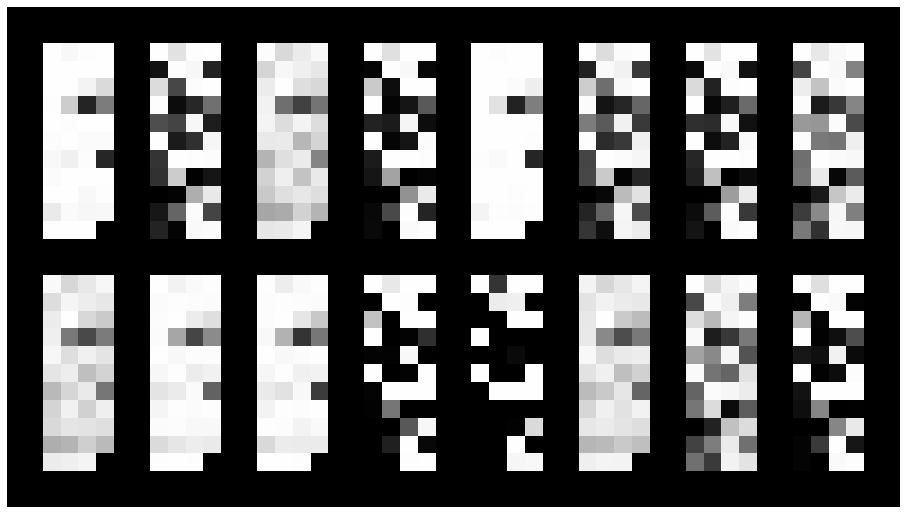

Epoch: [158/200], Batch Num: [0/10]
Discriminator Loss: 0.7006, Generator Loss: 3.2944
D(x): 0.8010, D(G(z)): 0.1212


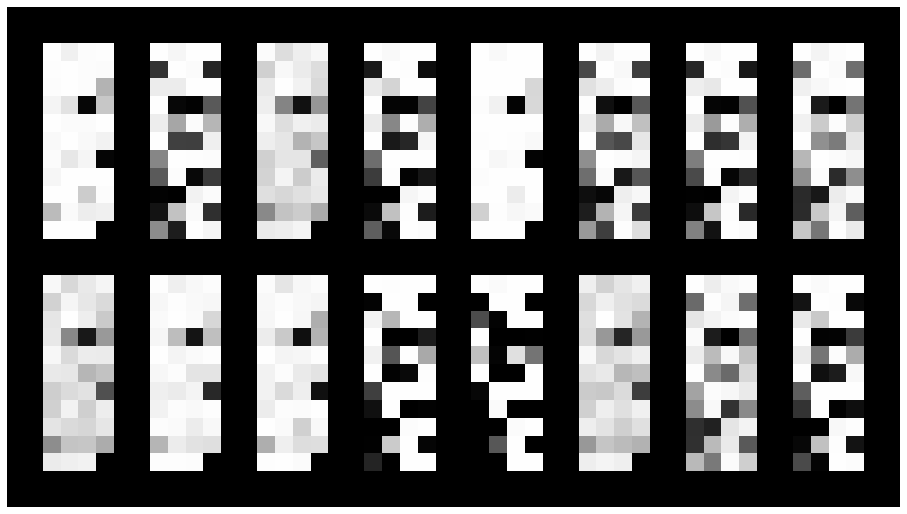

Epoch: [159/200], Batch Num: [0/10]
Discriminator Loss: 0.4798, Generator Loss: 3.2399
D(x): 0.8393, D(G(z)): 0.0857


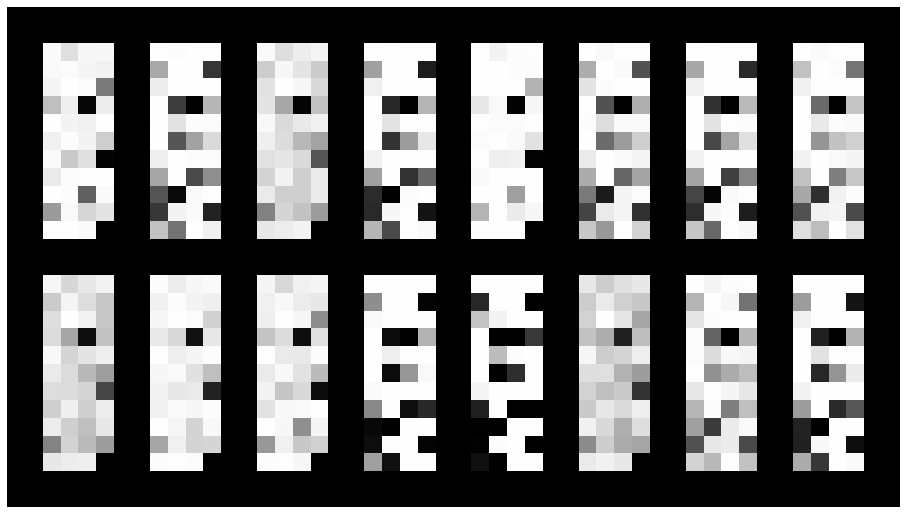

Epoch: [160/200], Batch Num: [0/10]
Discriminator Loss: 0.3428, Generator Loss: 3.4983
D(x): 0.8744, D(G(z)): 0.0596


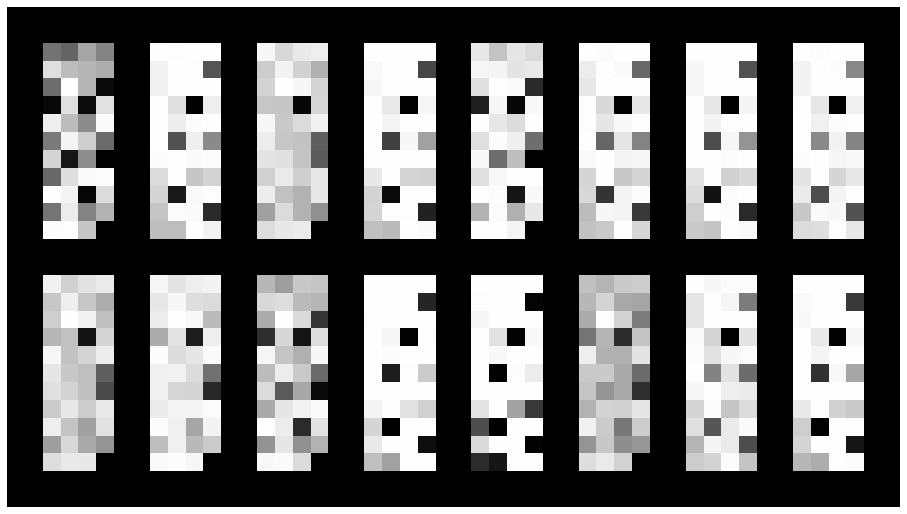

Epoch: [161/200], Batch Num: [0/10]
Discriminator Loss: 0.4759, Generator Loss: 3.3250
D(x): 0.8723, D(G(z)): 0.1241


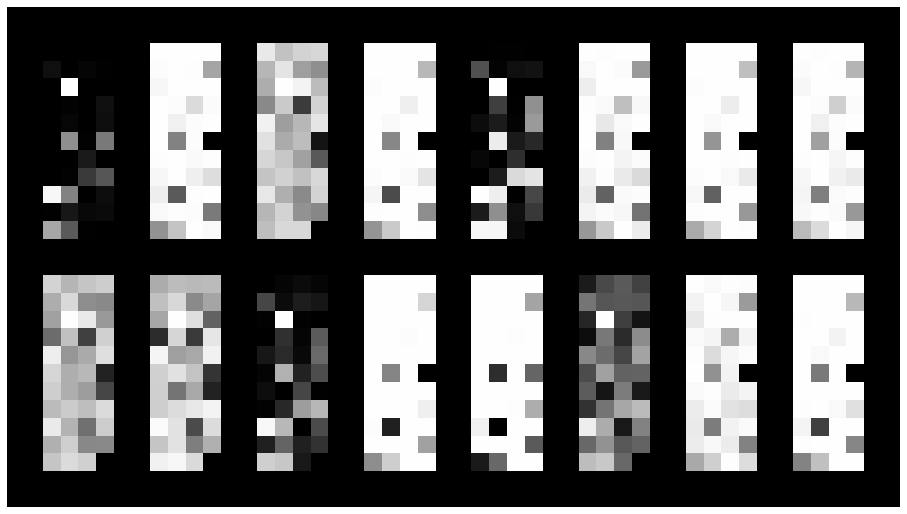

Epoch: [162/200], Batch Num: [0/10]
Discriminator Loss: 1.0286, Generator Loss: 3.1543
D(x): 0.8342, D(G(z)): 0.2618


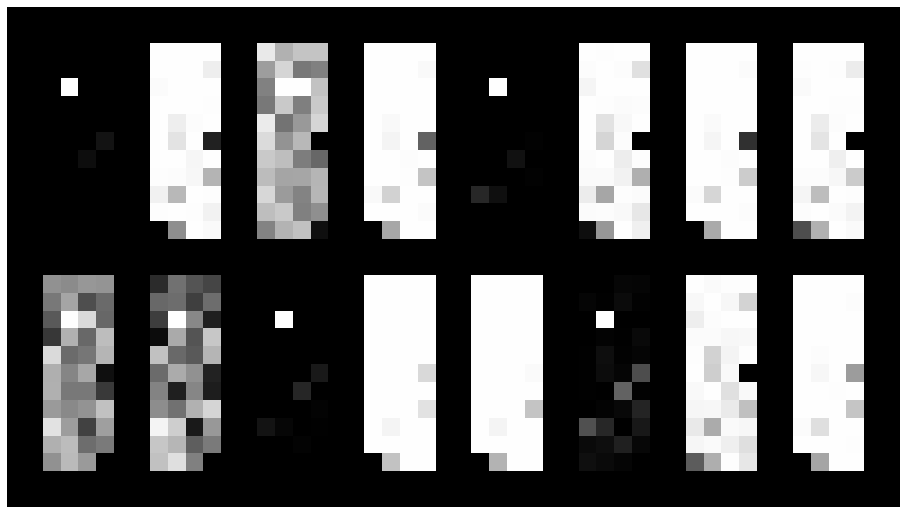

Epoch: [163/200], Batch Num: [0/10]
Discriminator Loss: 1.0235, Generator Loss: 2.8952
D(x): 0.6769, D(G(z)): 0.1645


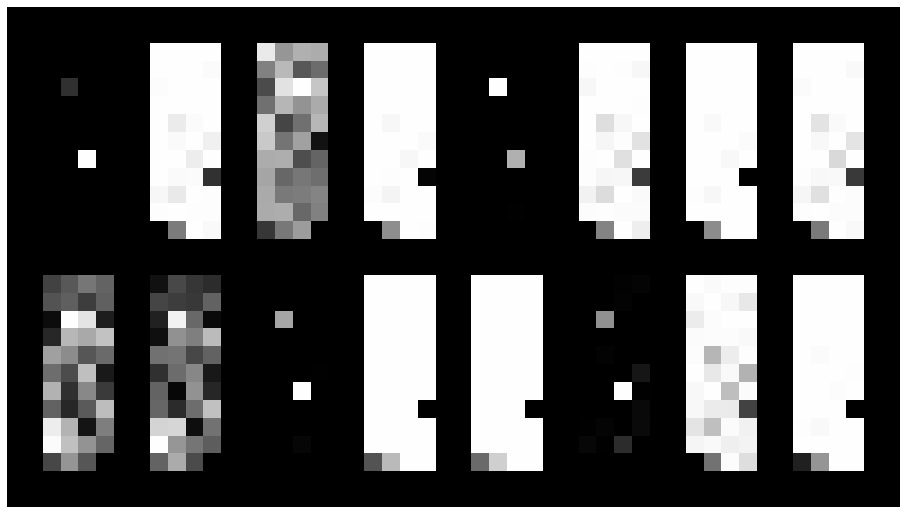

Epoch: [164/200], Batch Num: [0/10]
Discriminator Loss: 1.0216, Generator Loss: 1.3029
D(x): 0.7347, D(G(z)): 0.3322


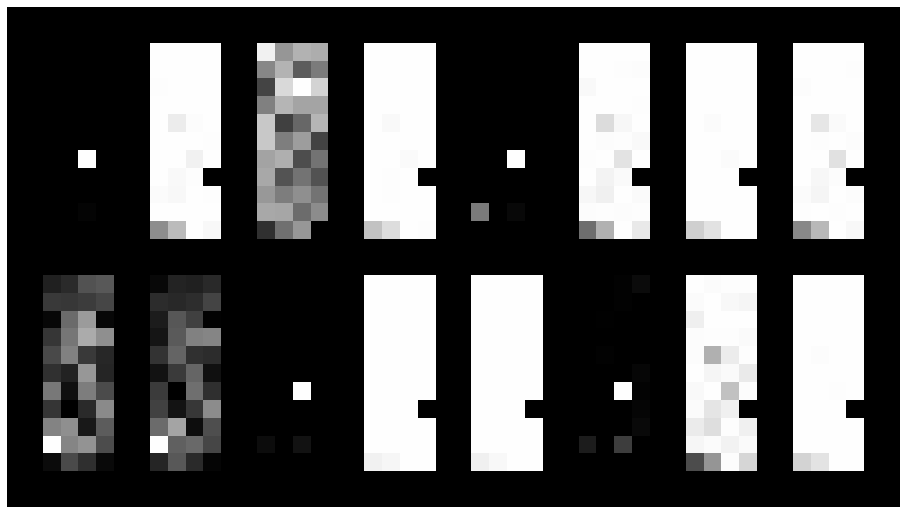

Epoch: [165/200], Batch Num: [0/10]
Discriminator Loss: 0.8822, Generator Loss: 1.8167
D(x): 0.6611, D(G(z)): 0.2518


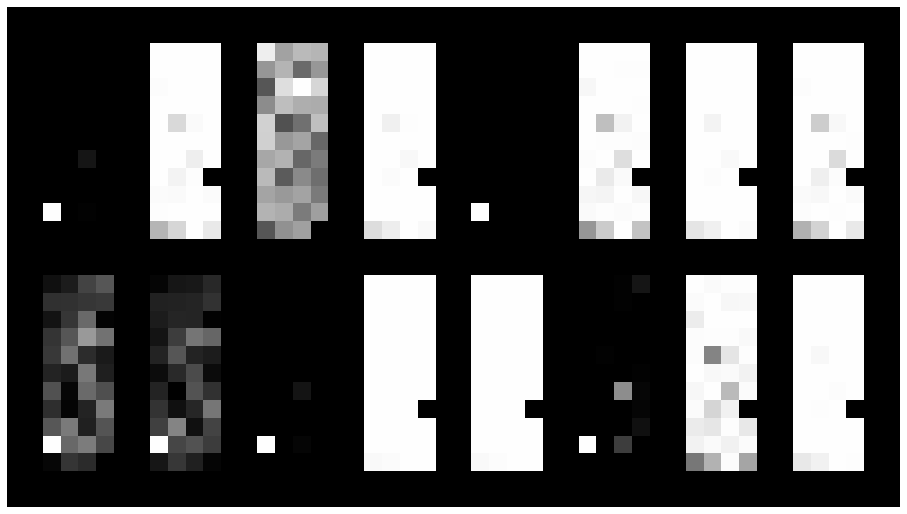

Epoch: [166/200], Batch Num: [0/10]
Discriminator Loss: 0.5645, Generator Loss: 1.8105
D(x): 0.7908, D(G(z)): 0.2259


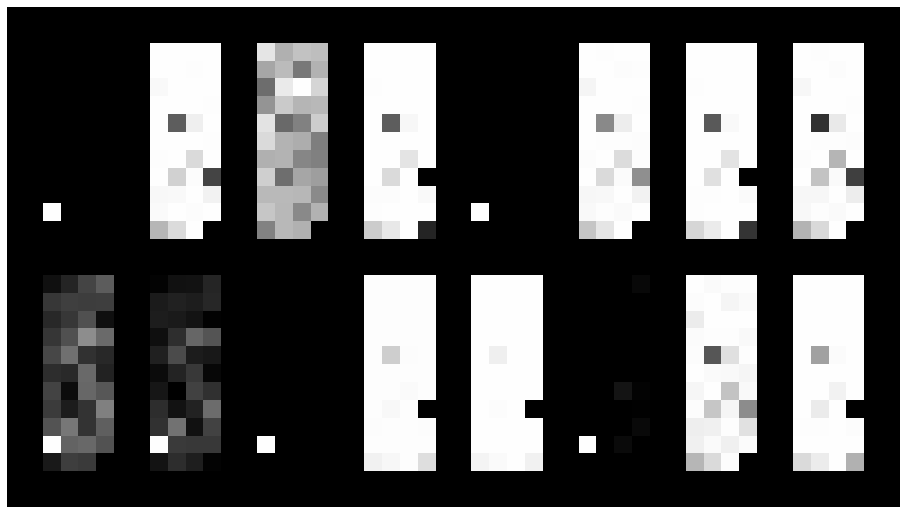

Epoch: [167/200], Batch Num: [0/10]
Discriminator Loss: 0.4277, Generator Loss: 1.9419
D(x): 0.8396, D(G(z)): 0.1865


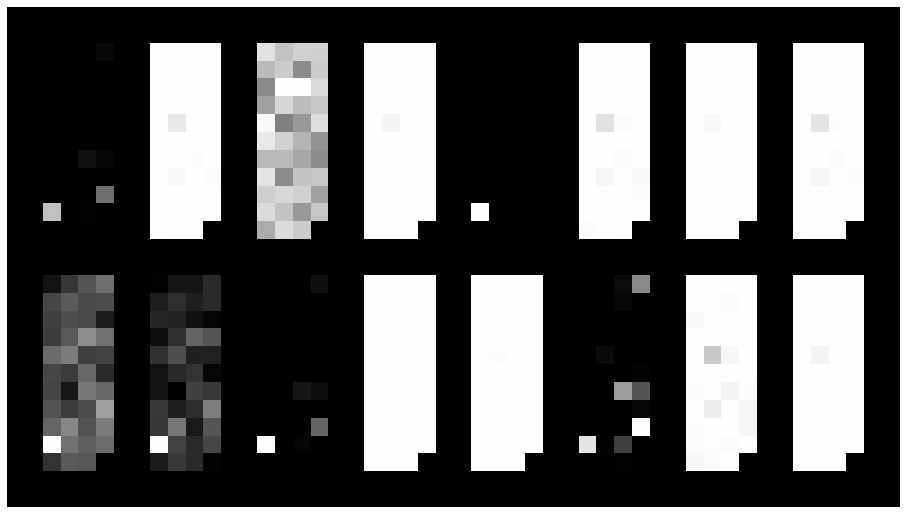

Epoch: [168/200], Batch Num: [0/10]
Discriminator Loss: 0.4474, Generator Loss: 2.1312
D(x): 0.8951, D(G(z)): 0.2292


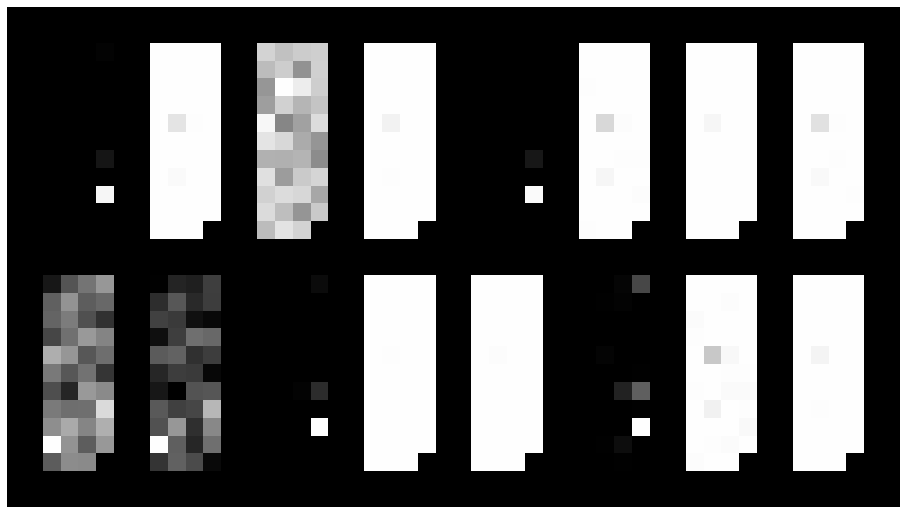

Epoch: [169/200], Batch Num: [0/10]
Discriminator Loss: 0.4508, Generator Loss: 2.2527
D(x): 0.8391, D(G(z)): 0.1521


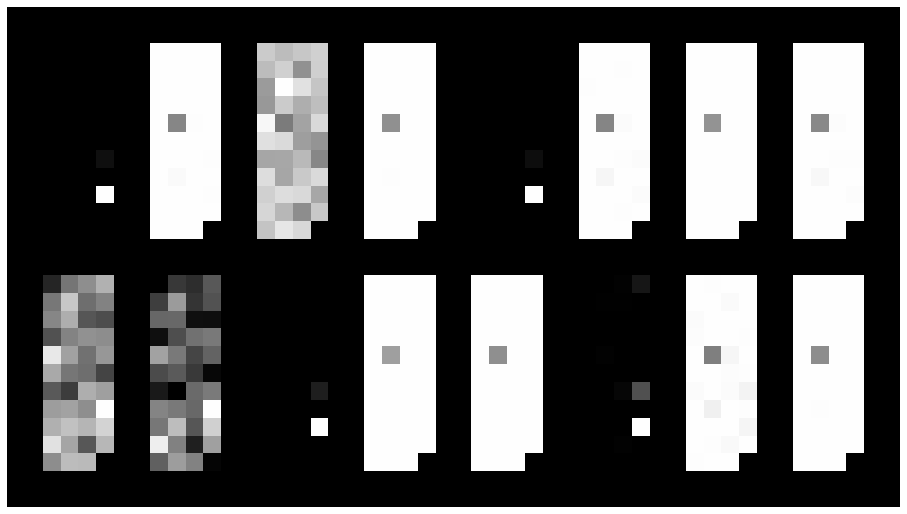

Epoch: [170/200], Batch Num: [0/10]
Discriminator Loss: 0.3335, Generator Loss: 2.4813
D(x): 0.8954, D(G(z)): 0.1505


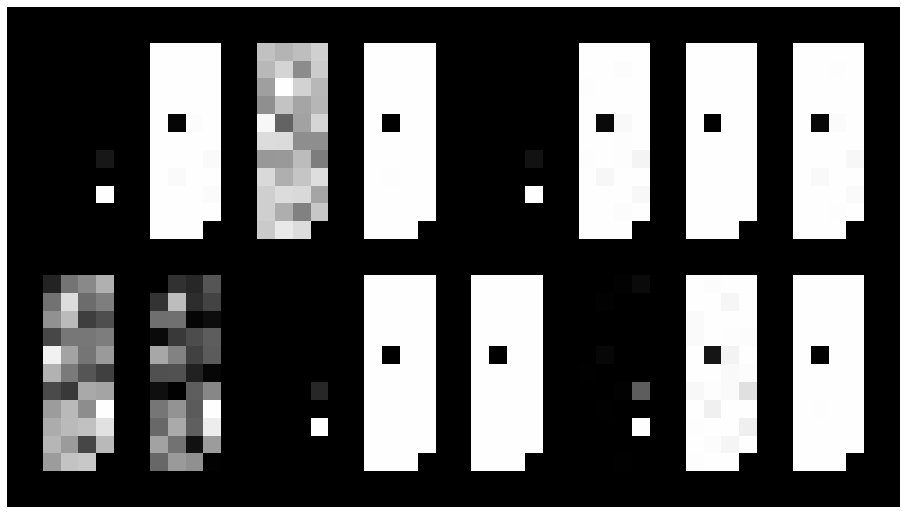

Epoch: [171/200], Batch Num: [0/10]
Discriminator Loss: 0.4092, Generator Loss: 3.1932
D(x): 0.8667, D(G(z)): 0.1264


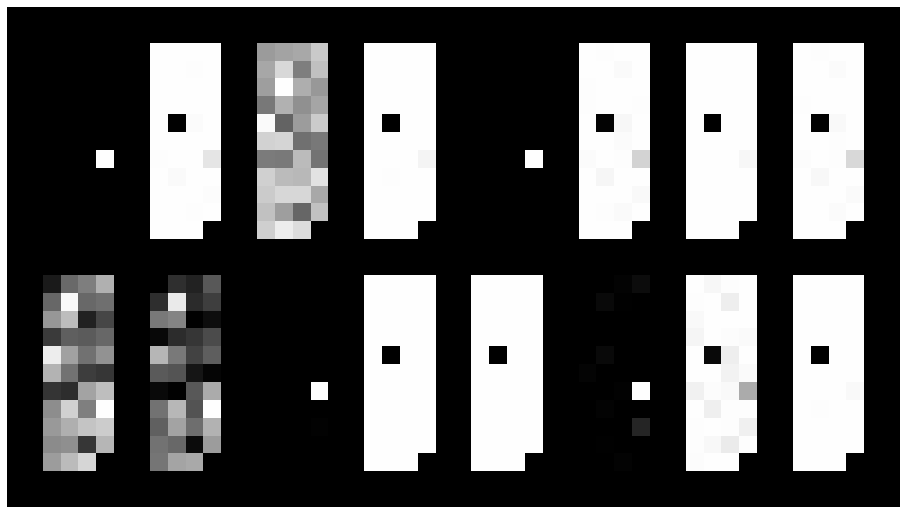

Epoch: [172/200], Batch Num: [0/10]
Discriminator Loss: 0.3183, Generator Loss: 3.1828
D(x): 0.9263, D(G(z)): 0.1471


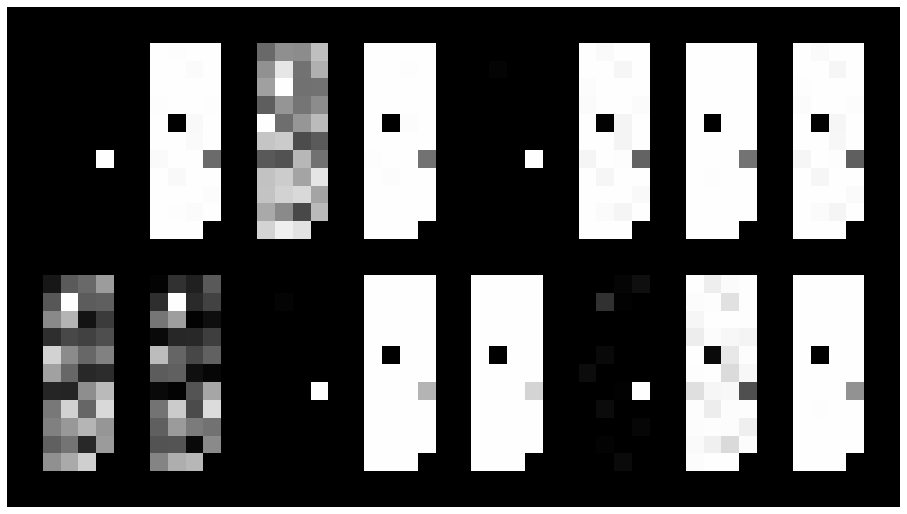

Epoch: [173/200], Batch Num: [0/10]
Discriminator Loss: 0.3274, Generator Loss: 3.5237
D(x): 0.8797, D(G(z)): 0.1163


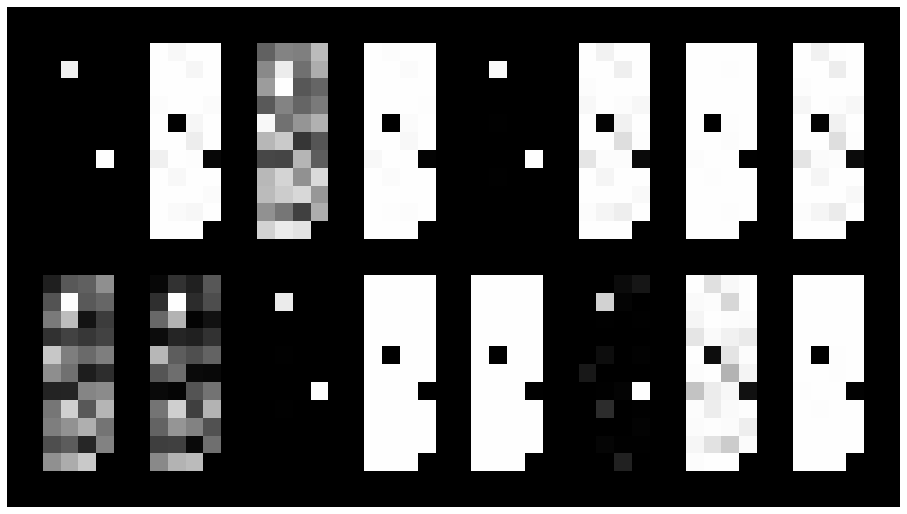

Epoch: [174/200], Batch Num: [0/10]
Discriminator Loss: 0.2850, Generator Loss: 3.2657
D(x): 0.8974, D(G(z)): 0.0966


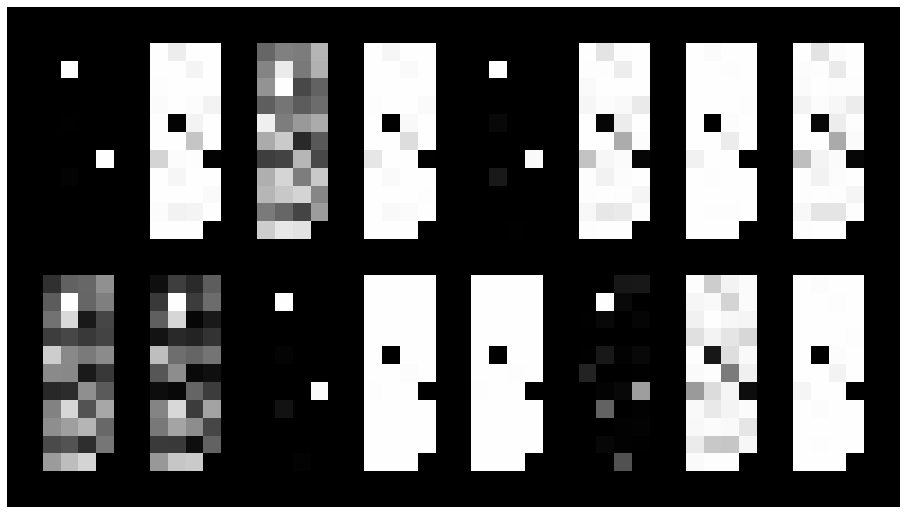

Epoch: [175/200], Batch Num: [0/10]
Discriminator Loss: 0.2759, Generator Loss: 3.6037
D(x): 0.8987, D(G(z)): 0.0740


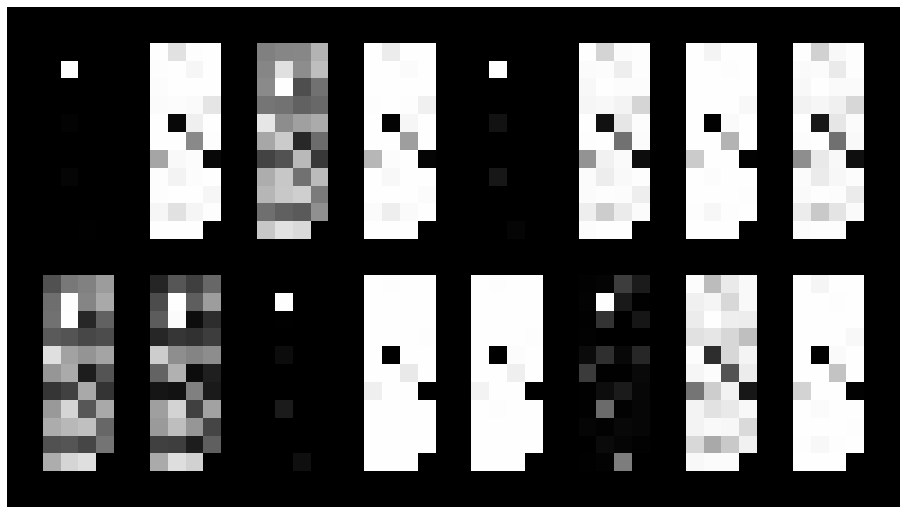

Epoch: [176/200], Batch Num: [0/10]
Discriminator Loss: 0.2558, Generator Loss: 3.5377
D(x): 0.8966, D(G(z)): 0.0771


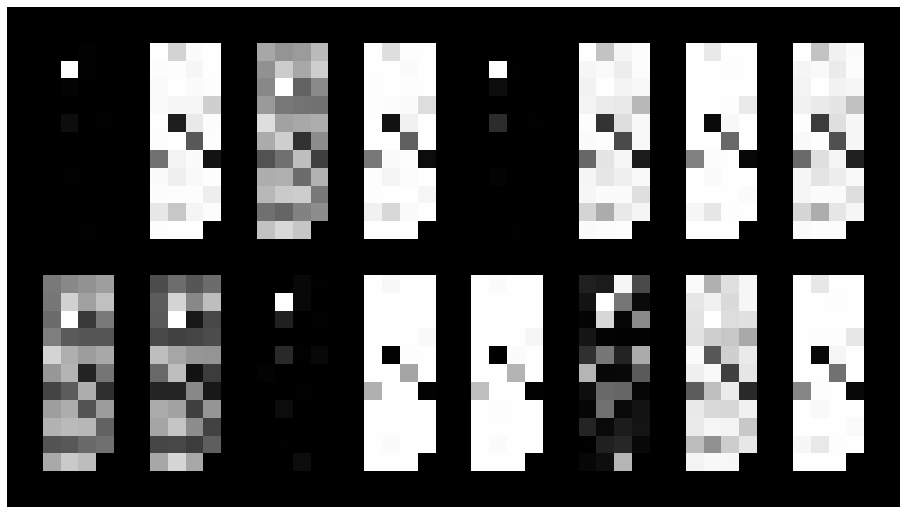

Epoch: [177/200], Batch Num: [0/10]
Discriminator Loss: 0.2977, Generator Loss: 3.3073
D(x): 0.9032, D(G(z)): 0.1134


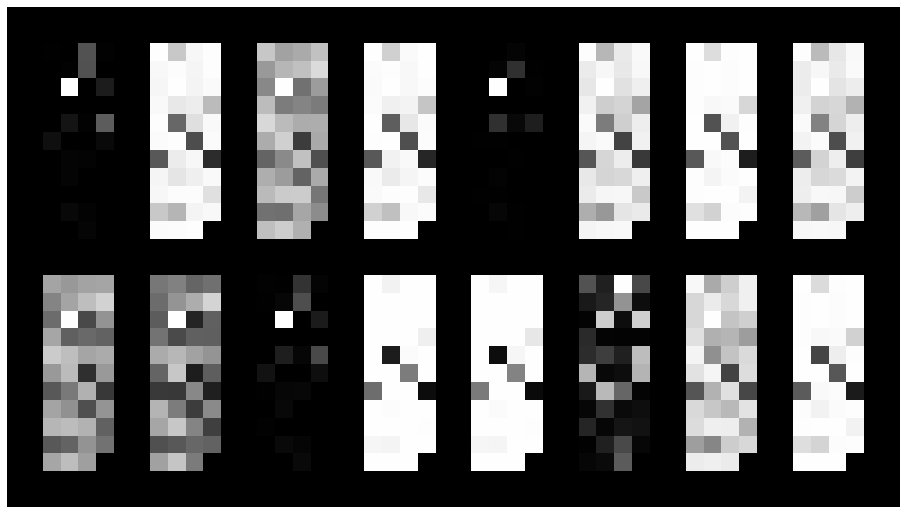

Epoch: [178/200], Batch Num: [0/10]
Discriminator Loss: 0.5454, Generator Loss: 2.5923
D(x): 0.8315, D(G(z)): 0.1834


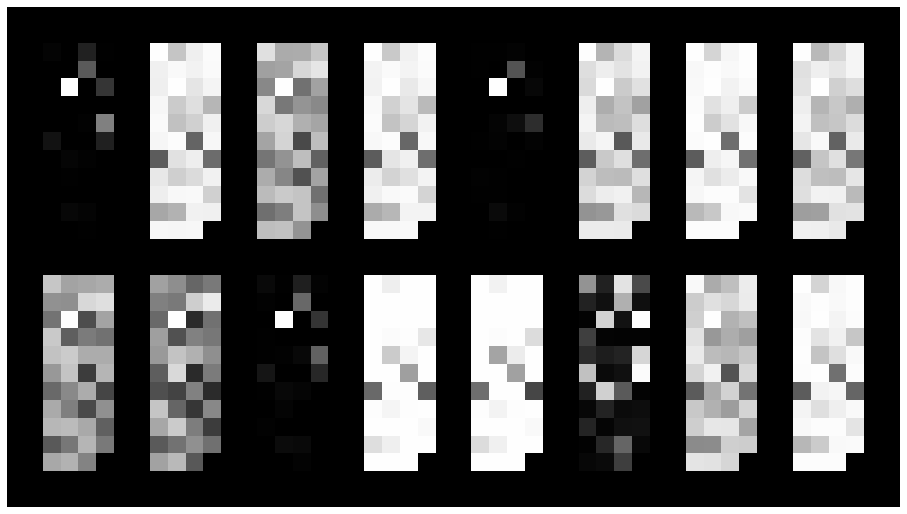

Epoch: [179/200], Batch Num: [0/10]
Discriminator Loss: 0.4056, Generator Loss: 2.4328
D(x): 0.8877, D(G(z)): 0.1701


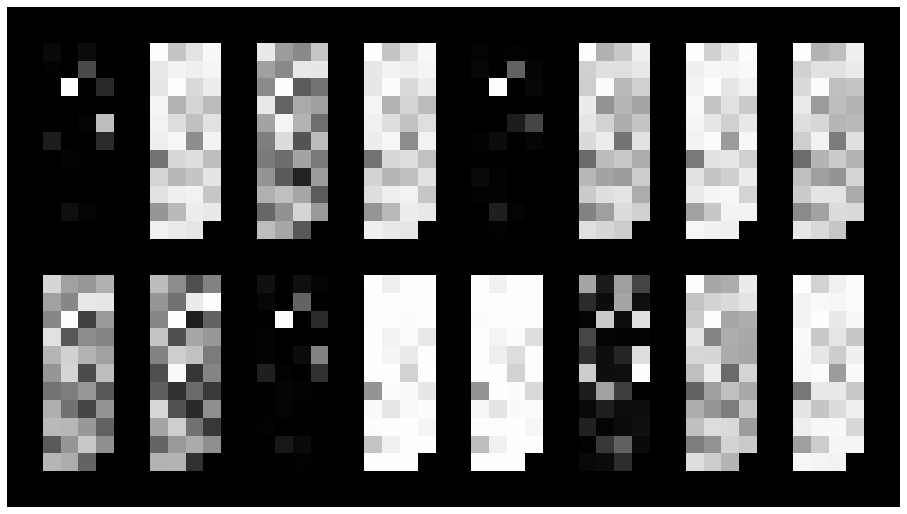

Epoch: [180/200], Batch Num: [0/10]
Discriminator Loss: 0.4519, Generator Loss: 2.3434
D(x): 0.8601, D(G(z)): 0.1644


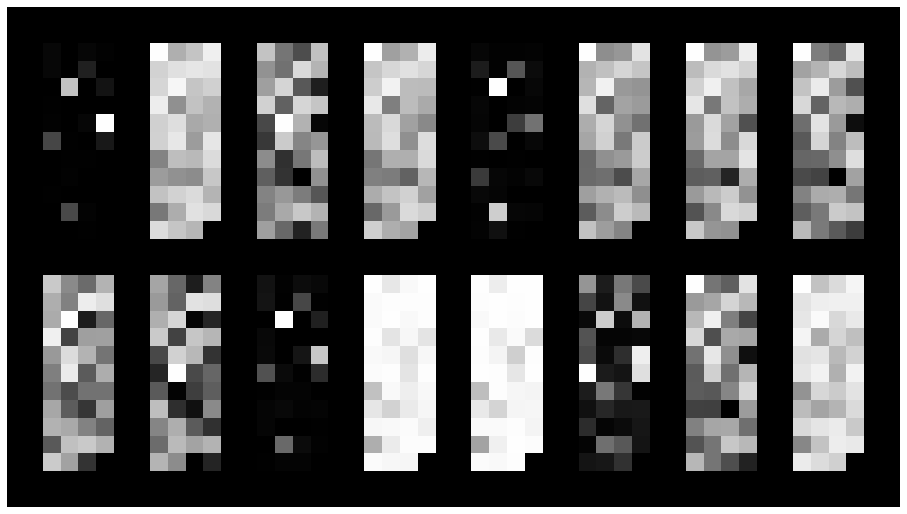

Epoch: [181/200], Batch Num: [0/10]
Discriminator Loss: 0.7323, Generator Loss: 1.8950
D(x): 0.8272, D(G(z)): 0.2571


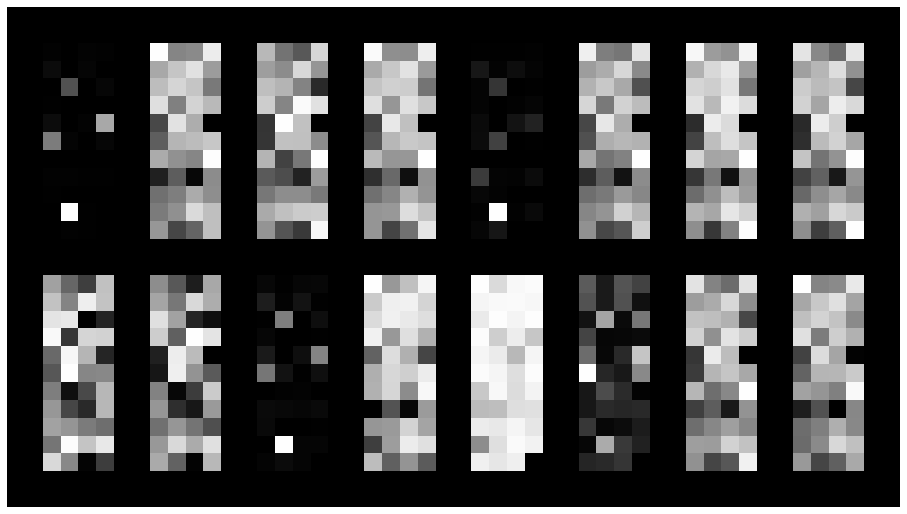

Epoch: [182/200], Batch Num: [0/10]
Discriminator Loss: 0.7957, Generator Loss: 1.9281
D(x): 0.7928, D(G(z)): 0.2379


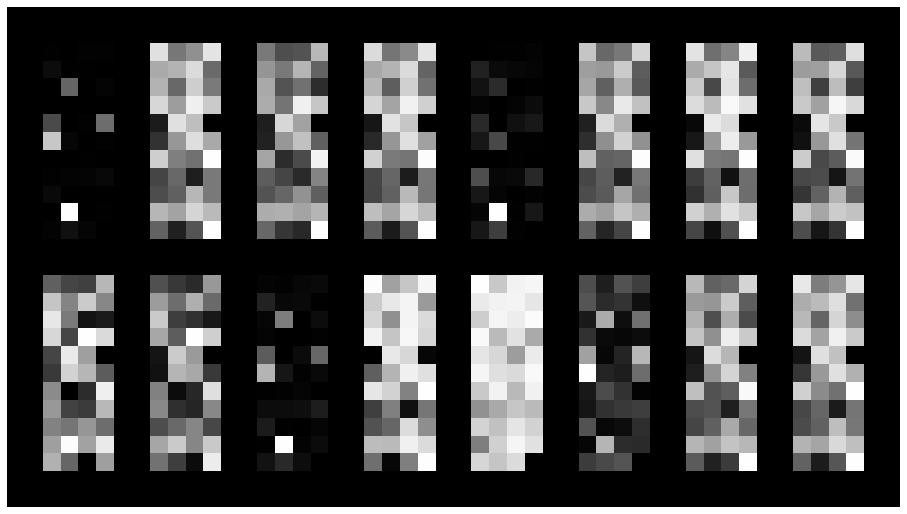

Epoch: [183/200], Batch Num: [0/10]
Discriminator Loss: 0.6035, Generator Loss: 2.4821
D(x): 0.8299, D(G(z)): 0.1731


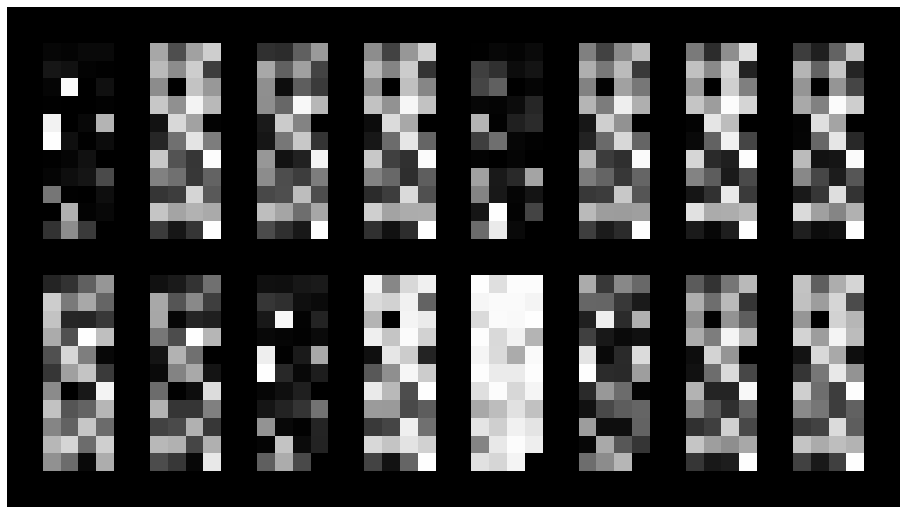

Epoch: [184/200], Batch Num: [0/10]
Discriminator Loss: 0.6217, Generator Loss: 2.5032
D(x): 0.8724, D(G(z)): 0.1985


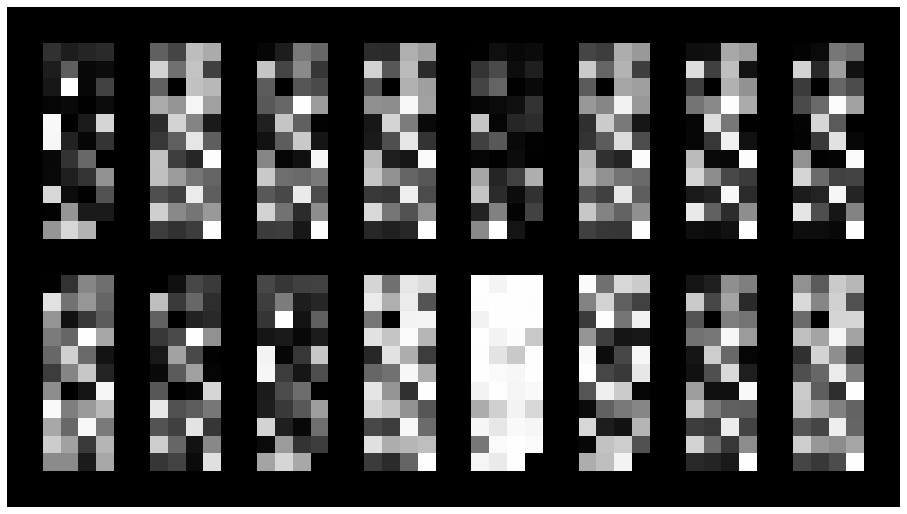

Epoch: [185/200], Batch Num: [0/10]
Discriminator Loss: 0.6599, Generator Loss: 2.4044
D(x): 0.8413, D(G(z)): 0.1926


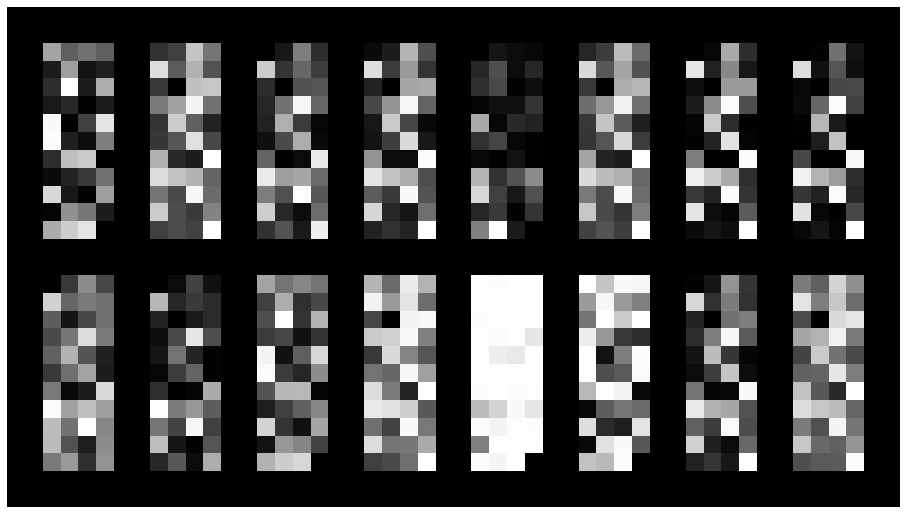

Epoch: [186/200], Batch Num: [0/10]
Discriminator Loss: 0.7230, Generator Loss: 2.2923
D(x): 0.7990, D(G(z)): 0.2024


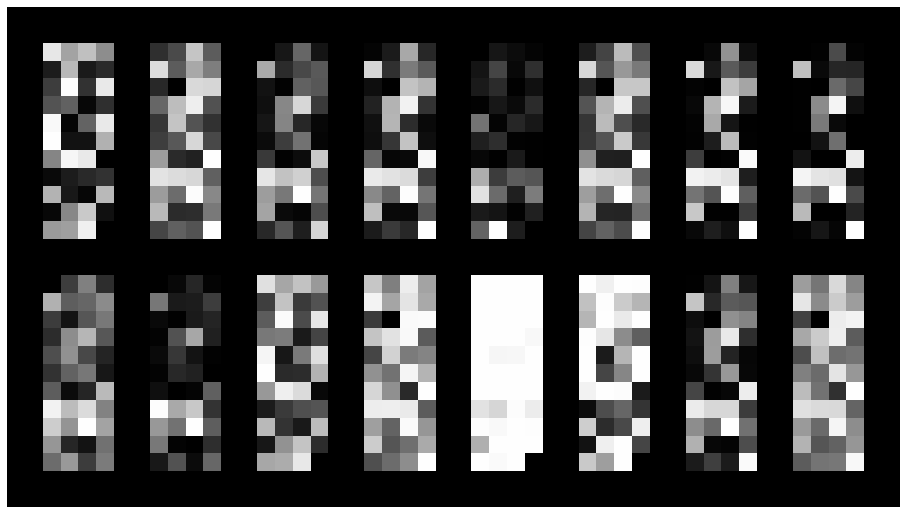

Epoch: [187/200], Batch Num: [0/10]
Discriminator Loss: 0.5976, Generator Loss: 2.3965
D(x): 0.8124, D(G(z)): 0.1665


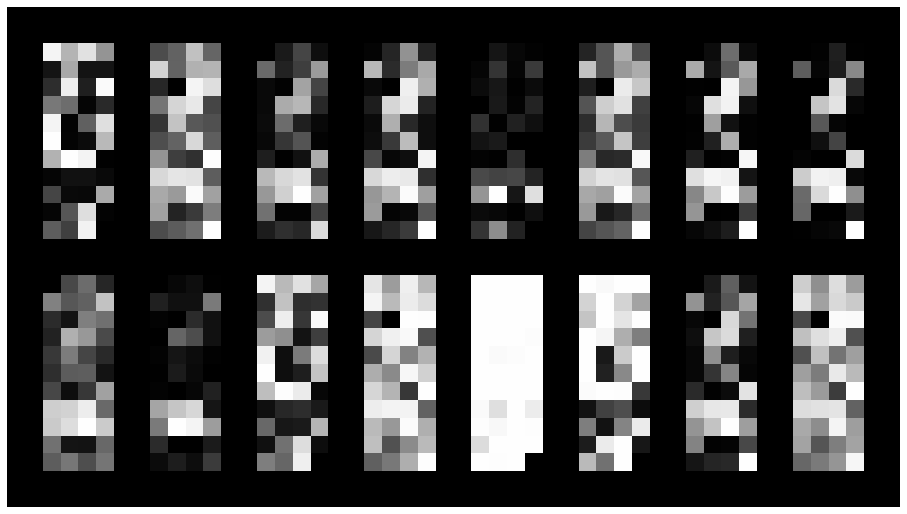

Epoch: [188/200], Batch Num: [0/10]
Discriminator Loss: 0.7098, Generator Loss: 2.3670
D(x): 0.8017, D(G(z)): 0.2082


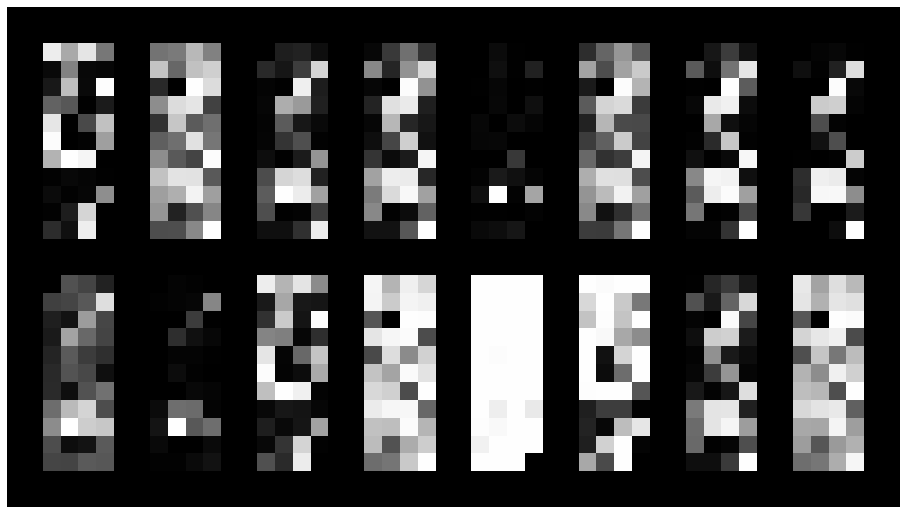

Epoch: [189/200], Batch Num: [0/10]
Discriminator Loss: 0.7592, Generator Loss: 2.4603
D(x): 0.7473, D(G(z)): 0.1994


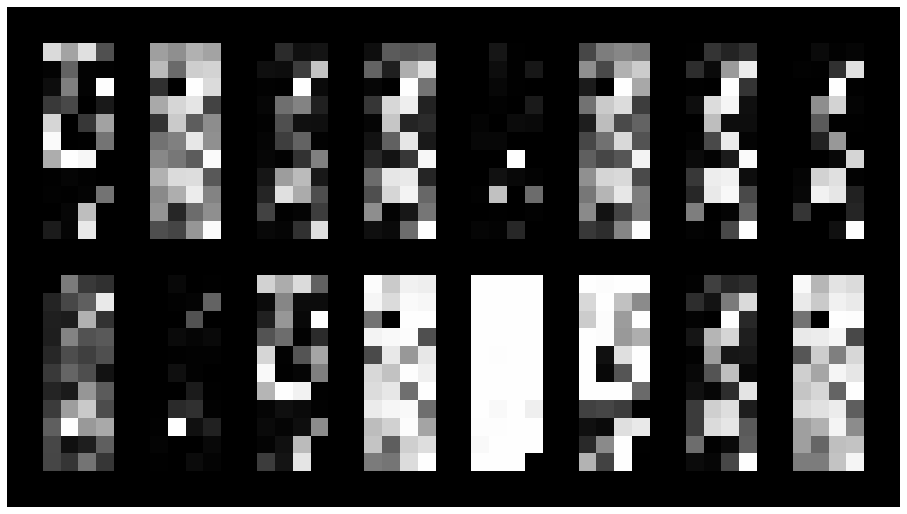

Epoch: [190/200], Batch Num: [0/10]
Discriminator Loss: 0.5079, Generator Loss: 2.3239
D(x): 0.8415, D(G(z)): 0.1791


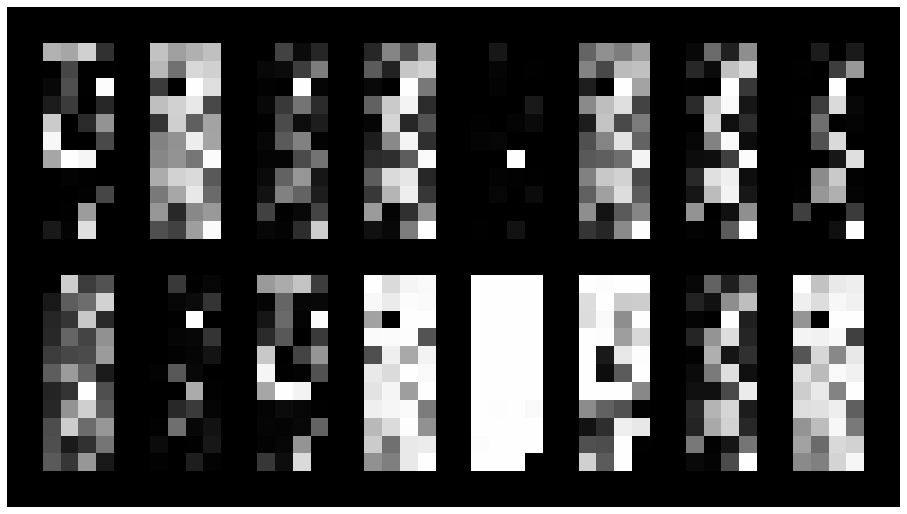

Epoch: [191/200], Batch Num: [0/10]
Discriminator Loss: 0.4671, Generator Loss: 2.2809
D(x): 0.8406, D(G(z)): 0.1555


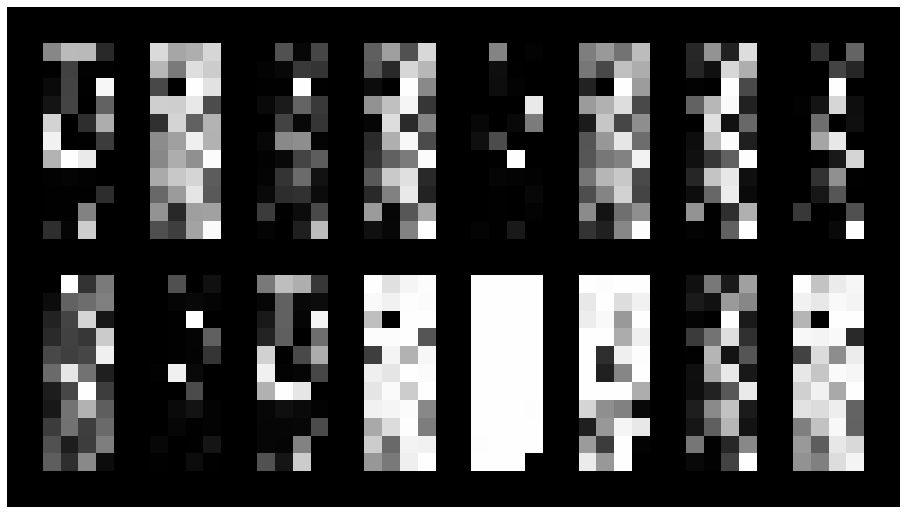

Epoch: [192/200], Batch Num: [0/10]
Discriminator Loss: 0.4972, Generator Loss: 2.2001
D(x): 0.8264, D(G(z)): 0.1653


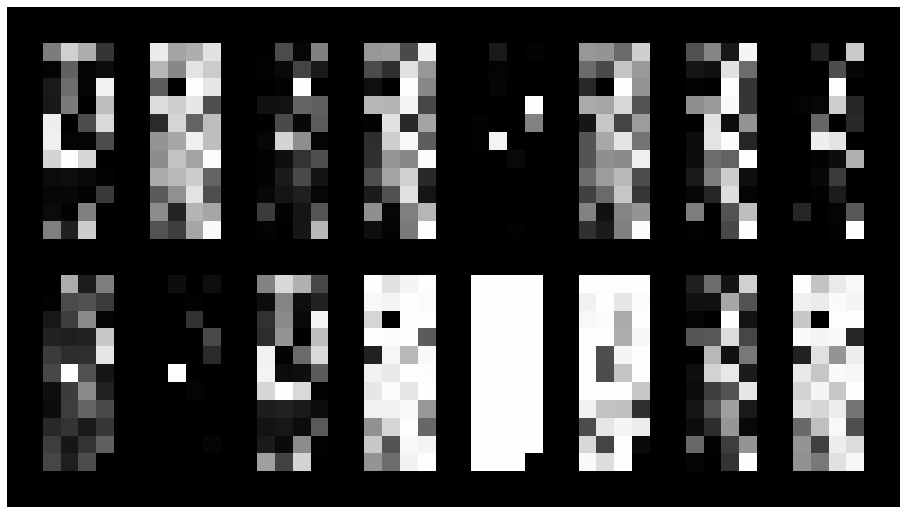

Epoch: [193/200], Batch Num: [0/10]
Discriminator Loss: 0.5312, Generator Loss: 2.1379
D(x): 0.8416, D(G(z)): 0.1842


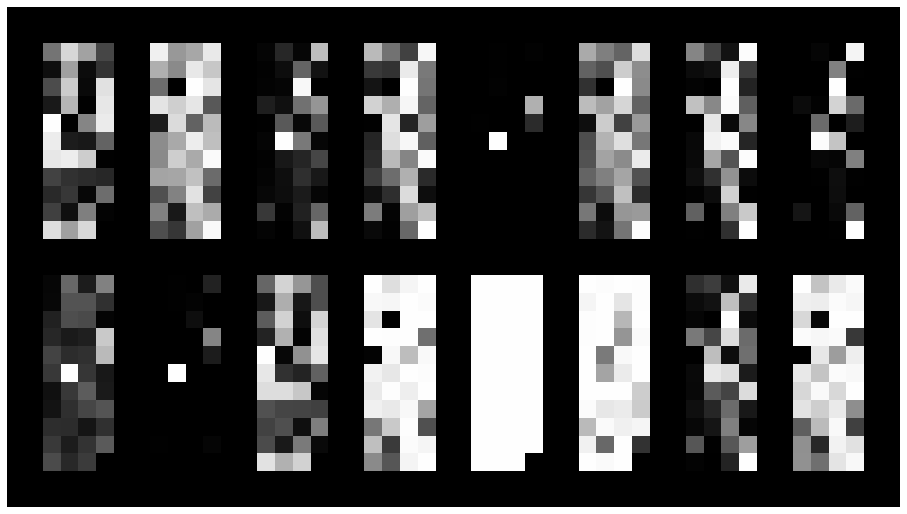

Epoch: [194/200], Batch Num: [0/10]
Discriminator Loss: 0.4493, Generator Loss: 2.3352
D(x): 0.8488, D(G(z)): 0.1514


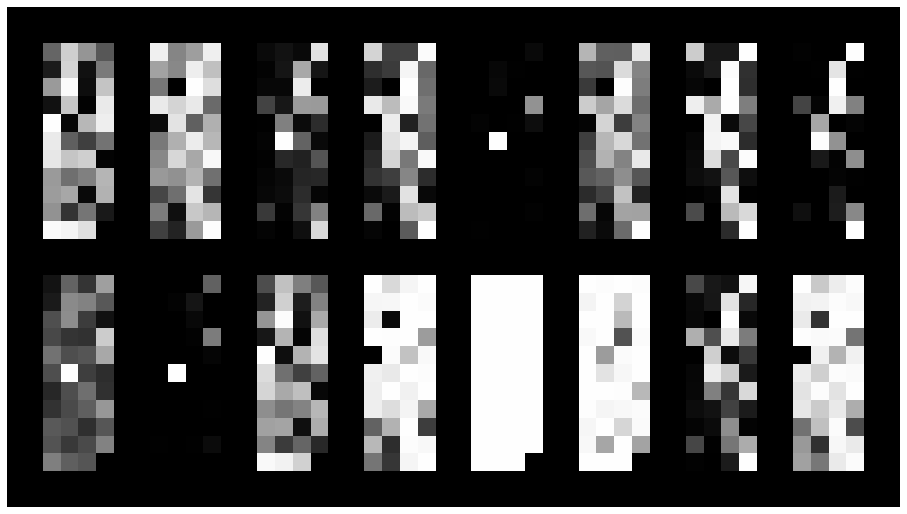

Epoch: [195/200], Batch Num: [0/10]
Discriminator Loss: 0.4903, Generator Loss: 2.4590
D(x): 0.8448, D(G(z)): 0.1797


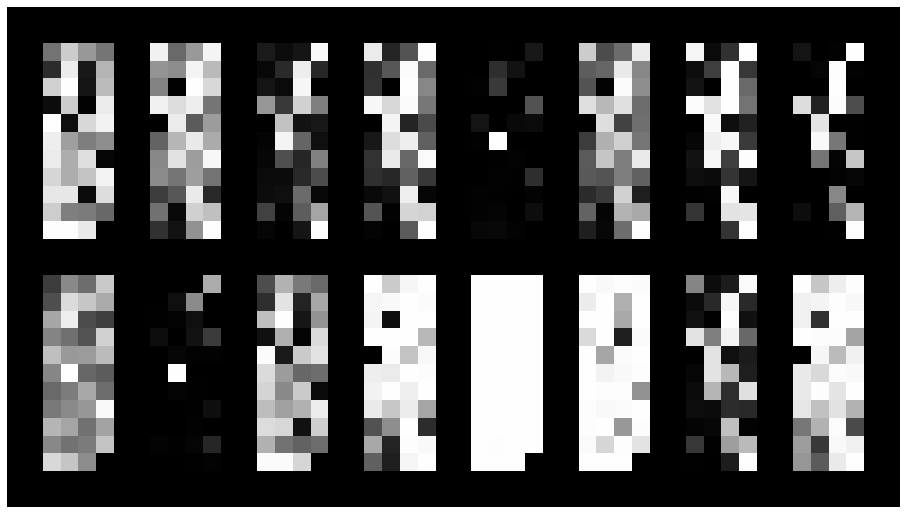

Epoch: [196/200], Batch Num: [0/10]
Discriminator Loss: 0.4366, Generator Loss: 2.4652
D(x): 0.8706, D(G(z)): 0.1662


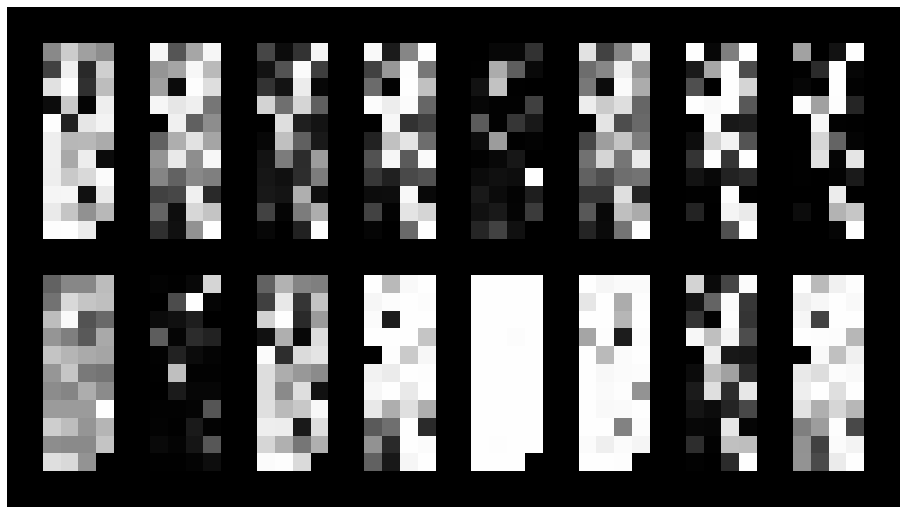

Epoch: [197/200], Batch Num: [0/10]
Discriminator Loss: 0.5057, Generator Loss: 2.3188
D(x): 0.8422, D(G(z)): 0.1639


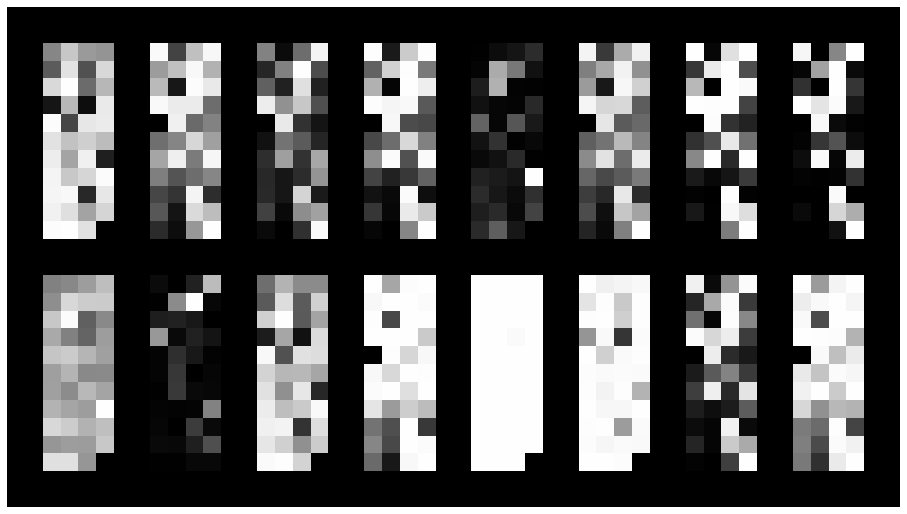

Epoch: [198/200], Batch Num: [0/10]
Discriminator Loss: 0.5034, Generator Loss: 2.1455
D(x): 0.8507, D(G(z)): 0.1867


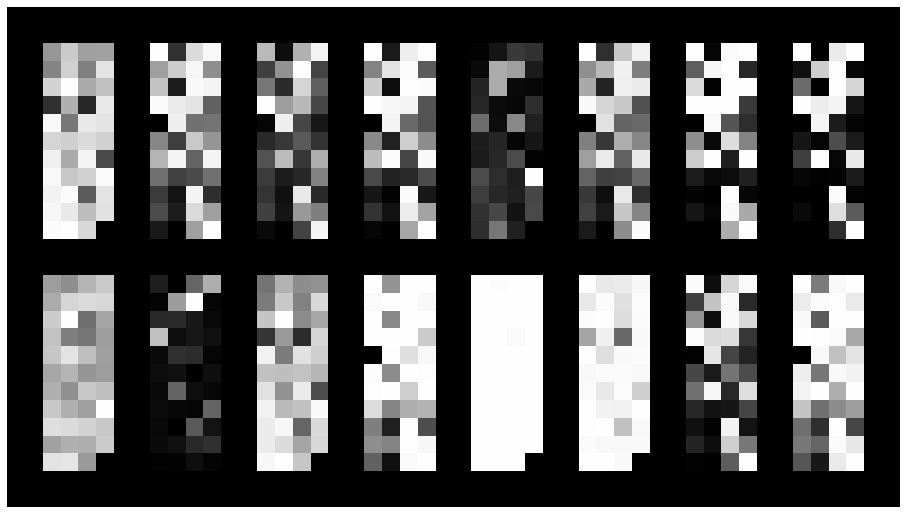

Epoch: [199/200], Batch Num: [0/10]
Discriminator Loss: 0.4992, Generator Loss: 2.1602
D(x): 0.8521, D(G(z)): 0.1873


In [14]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):
        N = real_batch.size(0)
        # print('real')
        # print(real_batch.dtype)
        # 1. Train Discriminator
        real_batch = real_batch - real_batch.mean(axis=0)
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches_train
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [ ]:
test_data = generator(noise(1))

In [ ]:
test_data = generator(noise(10))
plt.imshow(test_data[6].reshape(11,4).detach().numpy())
plt.colorbar()

In [ ]:
generator(noise(1)).mean()

In [ ]:
noise(1)

In [ ]:
generator(noise(1))

In [17]:
tt1 = noise(1)
print(tt1)
t1 = generator(tt1)
print(t1)
print(t1.mean())
print(t1.std())

tensor([[-1.0467,  0.5476, -0.4183,  0.7360,  0.3630,  0.6788, -0.9540, -1.4845,
          0.4858,  1.1003, -0.3731, -0.0566,  0.0994, -0.6135,  0.4702, -2.0642,
          0.6526,  0.1469,  1.1527, -0.0420, -1.2699,  0.9861,  1.9010, -1.0439,
         -0.3130,  0.1948, -0.8037, -0.1314, -0.8168,  0.5759,  0.6526,  0.3398,
         -1.0820, -1.4323,  1.2714, -1.0094, -0.2269, -0.2076,  2.4217, -0.6382,
          0.1255, -0.3127, -0.3237,  0.2521,  0.2591, -0.2408, -1.5336,  0.4670,
         -2.2253, -1.7216, -0.3725,  0.0273, -0.6487,  1.1178, -0.2546, -0.9963,
         -0.8177, -0.2946,  0.3120,  1.1059,  0.9849,  0.9513,  1.2429, -1.6965,
          1.0502,  1.1044, -0.1537,  1.1547, -0.6492, -0.2902, -0.4478, -0.3466,
          1.2710, -0.9714,  1.0846, -0.7705, -0.7400,  0.4978,  1.8464,  1.1247,
          0.0647,  0.1449, -0.0204, -1.6560, -0.4400, -0.9240, -1.4705, -1.1013,
          0.3468, -0.3788,  0.3850,  0.1277,  0.3163,  0.2619, -1.2746, -1.2816,
         -0.4996,  0.6445,  

In [16]:
tt2 = noise(1)
print(tt2)
t2 = generator(tt2)
print(t2)
print(t2.mean())
print(t2.std())

tensor([[-1.4284,  0.0860,  1.0985, -1.7795, -1.0252, -1.0660,  0.6968, -1.8518,
          0.2453, -0.0441, -0.6277, -0.7943,  0.8118,  1.5244, -1.8160, -0.6808,
          0.4404,  1.6545,  0.8018,  1.3987,  1.0080,  0.8195, -0.2759, -0.3596,
          0.4624,  0.4810,  0.5694, -0.4815,  0.2947, -0.1934,  0.7124,  0.7817,
         -0.3969,  1.3360, -0.3793, -0.0166,  0.8607,  0.6713, -1.2244, -1.2644,
          0.1975,  0.5428,  0.3395, -0.8586,  0.2617, -0.1153, -0.4225, -0.5898,
          1.7104,  0.9744,  1.3040,  1.4649,  0.3118, -1.6869,  0.0174,  0.6912,
          1.1729,  0.3179, -0.4489, -0.9104,  0.2139,  0.7146,  0.1054,  0.9972,
          0.7786,  0.0041, -0.0761,  0.5781, -0.0317,  1.8923,  0.9836,  0.1443,
          0.2368,  1.5786,  2.5979, -1.3573,  0.1760, -1.3127,  0.3239, -0.0455,
          0.3085, -0.6454,  0.7284,  0.9485, -0.2413, -0.8181, -0.2275,  2.1184,
         -0.0670, -0.4697,  0.2076, -1.3785, -0.1941, -0.0654,  1.0073, -0.3938,
          0.5580,  1.0777,  

tensor(0.3990, grad_fn=<StdBackward0>)

In [ ]:
t2-t2.mean()

In [24]:
discriminator(real_batch[0]-real_batch[0].mean())

tensor([0.1239], grad_fn=<SigmoidBackward>)

In [ ]:
plt.imshow((real_batch[0]-real_batch[0].mean()).reshape(11,4))
plt.colorbar()

In [ ]:
means = []
for i in range(len(real_batch)):
    means.append(real_batch[i].mean())

In [ ]:
import numpy as np

In [ ]:
means[3]

In [ ]:
discriminator(real_batch[0])

In [ ]:
real_batch[0].mean()

In [ ]:
real_batch[0].std()

In [ ]:
means = real_batch.mean(axis=1)

In [ ]:
ff = (real_batch.T-means).T

In [28]:
import matplotlib.pyplot as plt

In [ ]:
tmp1 = real_batch[0] - real_batch[0].mean()
print(tmp1)
print(real_batch[0].std())

In [ ]:
tmp2 = real_batch[1] - real_batch[1].mean()
print(tmp2)
print(real_batch[1].mean())
print(real_batch[1])
print(real_batch[1].std())

In [ ]:
real_batch.std(axis=1)
plt.hist(real_batch.std(axis=1),bins=100)

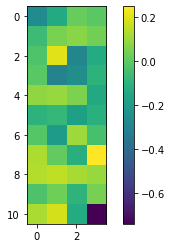

In [77]:
a = generator(noise(1))
a = a.detach().numpy()
plt.imshow(a.reshape(11,4))
plt.colorbar()

In [148]:
c = torch.tensor(a)

In [86]:
c += b.mean()

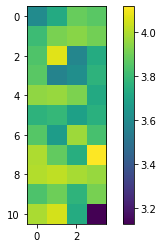

In [91]:
plt.imshow(c.reshape(11,4))
plt.colorbar()

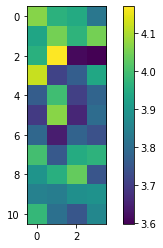

In [90]:
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [133]:
b

tensor([2.1663, 1.2254, 1.1976, 2.4664, 1.8543, 2.0917, 3.0614, 2.6122, 2.1624,
        1.2210, 1.7120, 1.2284, 3.6033, 2.0725, 1.1992, 2.0196, 1.1767, 3.0549,
        1.7458, 2.1929, 0.5548, 1.6300, 2.4808, 1.7998, 2.1091, 1.4339, 2.2108,
        2.8506, 2.4809, 2.2975, 1.6516, 1.4294, 1.4937, 2.0903, 2.1746, 1.5794,
        2.5794, 1.3217, 1.9039, 2.3310, 1.8786, 1.1306, 1.3717, 6.7531])

In [141]:
abs(c+b.mean()-b).sum()

tensor(5.7299)

In [151]:
c += b.mean()

tensor([[3.6074, 3.7339, 3.8892, 3.8634, 3.8087, 3.9200, 3.9418, 3.9062, 3.8451,
         4.0747, 3.5851, 3.7365, 3.8655, 3.5709, 3.6171, 3.7687, 3.9544, 3.9673,
         3.9219, 3.7321, 3.7694, 3.7876, 3.6911, 3.7589, 3.8563, 3.6751, 3.9737,
         3.8306, 3.9981, 3.8800, 3.7489, 4.1180, 4.0038, 4.0243, 3.9904, 3.9644,
         3.8417, 3.9018, 3.7733, 3.9150, 3.9917, 4.0552, 3.7364, 3.1301]])

In [152]:
print(abs(c-b))
print(abs(c-b).sum())

tensor([[0.3934, 0.6740, 0.8571, 0.4375, 0.1198, 0.0062, 0.9542, 0.5405, 0.1518,
         1.0192, 0.0385, 0.6736, 1.5723, 0.3361, 0.5833, 0.0854, 0.9432, 0.9222,
         0.3415, 0.2953, 1.3801, 0.3230, 0.6243, 0.1246, 0.0873, 0.4067, 0.0716,
         0.8545, 0.3173, 0.2520, 0.2627, 0.8541, 0.6756, 0.0995, 0.0188, 0.5504,
         0.5722, 0.7456, 0.0348, 0.2505, 0.2785, 1.0901, 0.5302, 5.4575]])
tensor(26.8072)


tensor(2.0364)
tensor(0.9510)


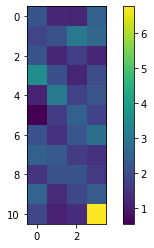

In [146]:
b = real_data[50]
print(b.mean())
print(b.std())
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [107]:
print(b.mean())
print(b.std())

tensor(3.8709)
tensor(0.1422)


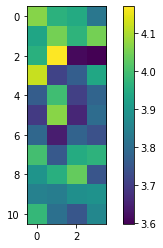

In [74]:
plt.imshow(b.reshape(11,4))
plt.colorbar()